In [ ]:
pip install stable-baselines3 shimmy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.7 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np

env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode='ansi')

print(f"Action space : {env.action_space}") # Left, Down, Right, Up
print(f"Observation space : {env.observation_space}") # 4x4 table

action_space_size = env.action_space.n
observation_space_size = env.observation_space.n

Q = np.zeros((observation_space_size, action_space_size))
print(f"Shape of the Q-Table {Q.shape}")

# Hyperparameters
episode = 50000
epsilon = 1.0       # start with total exploration
epsilon_min = 0.01
epsilon_decay = 0.999 # decay epsilon per-episode
alpha = 0.8         # learning rate
gamma = 0.99        # discount factor

total_reward = 0

for i in range(episode):
    state, info = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # Explore
        else:
            action = np.argmax(Q[state]) # Exploit

        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward

        # Bellman equation update
        Q[state, action] += alpha * ( reward + gamma * np.max(Q[next_state]) - Q[state, action])

        done = truncated or terminated
        state = next_state # Move to the next state

    # Decay epsilon once per episode (outside the 'while' loop)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    total_reward += episode_reward

print(f"Total reward over {episode} episodes: {total_reward}")
print("--- Final Q-Table ---") # For state 1 : Quality of going left, Quality of going Down, Quality of going Right, Quality of going Up
print(Q)

env.close()

Action space : Discrete(4)
Observation space : Discrete(16)
Shape of the Q-Table (16, 4)
Total reward over 50000 episodes: 48463
--- Final Q-Table ---
[[0.94148015 0.95099005 0.95099005 0.94148015]
 [0.94148015 0.         0.96059601 0.95099005]
 [0.95099005 0.970299   0.95099005 0.96059601]
 [0.96059601 0.         0.95098985 0.95099005]
 [0.95099005 0.96059601 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.96059601]
 [0.         0.         0.         0.        ]
 [0.96059601 0.         0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.        ]
 [0.970299   0.99       0.         0.970299  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.99       0.970299  ]
 [0.9801     0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]


In [ ]:
eval_env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode='ansi')

eval_episodes = 5
total_eval_reward = 0

for i in range(eval_episodes):
  state, info = eval_env.reset()
  done = False
  episode_reward = 0

  print(f"\nPlaying Game {i+1}...")

  while not done:
    action = np.argmax(Q[state])
    next_state, reward, terminated, truncated, info = eval_env.step(action)
    episode_reward += reward
    print(eval_env.render()) # S(start), F(frozen), H(hole), G(goal)
    done = truncated or terminated
    state = next_state

  print(f"Reward for game {i+1}: {episode_reward}")
  total_eval_reward += episode_reward

print(f"\nTotal reward over {eval_episodes} evaluation games: {total_eval_reward}")
print(f"Average reward per game: {total_eval_reward / eval_episodes}")

eval_env.close()



Playing Game 1...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 1: 1

Playing Game 2...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 2: 1

Playing Game 3...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 3: 1

Playing Game 4...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 4: 1

Playing Game 5...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

With is_slipperry True

In [ ]:
eval_env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode='ansi')

eval_episodes = 5
total_eval_reward = 0

for i in range(eval_episodes):
  state, info = eval_env.reset()
  done = False
  episode_reward = 0

  print(f"\nPlaying Game {i+1}...")

  while not done:
    action = np.argmax(Q[state])
    next_state, reward, terminated, truncated, info = eval_env.step(action)
    episode_reward += reward
    print(eval_env.render())
    done = truncated or terminated
    state = next_state

  print(f"Reward for game {i+1}: {episode_reward}")
  total_eval_reward += episode_reward

print(f"\nTotal reward over {eval_episodes} evaluation games: {total_eval_reward}")
print(f"Average reward per game: {total_eval_reward / eval_episodes}")

eval_env.close()



Playing Game 1...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 1: 0

Playing Game 2...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 2: 0

Playing Game 3...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 3: 0

Playing Game 4...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Reward for game 4: 0

Playing Game 5...
  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

# is_slippery True : 33% chance of succeeding

In [ ]:
import gymnasium as gym
import numpy as np

env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode='ansi')

print(f"Action space : {env.action_space}") # Left, Down, Right, Up
print(f"Observation space : {env.observation_space}") # 4x4 table

action_space_size = env.action_space.n
observation_space_size = env.observation_space.n

Q = np.zeros((observation_space_size, action_space_size))
print(f"Shape of the Q-Table {Q.shape}") # states, action

# Hyperparameters
episode = 50000
epsilon = 1.0       # start with total exploration
epsilon_min = 0.01
epsilon_decay = 0.999 # decay epsilon per-episode
alpha = 0.8         # learning rate
gamma = 0.99        # discount factor

total_reward = 0

for i in range(episode):
    state, info = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # Explore
        else:
            action = np.argmax(Q[state]) # Exploit

        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward

        # Bellman equation update
        Q[state, action] += alpha * ( reward + gamma * np.max(Q[next_state]) - Q[state, action])

        done = truncated or terminated
        state = next_state # Move to the next state

    # Decay epsilon once per episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    total_reward += episode_reward

print(f"Total reward over {episode} episodes: {total_reward}")
print("--- Final Q-Table ---")
print(Q)

env.close()

Action space : Discrete(4)
Observation space : Discrete(16)
Shape of the Q-Table (16, 4)
Total reward over 50000 episodes: 23392
--- Final Q-Table ---
[[1.37398982e-01 1.47440312e-01 1.47458943e-01 1.47640317e-01]
 [7.13906528e-02 3.18400231e-02 6.14210126e-02 1.38336314e-01]
 [1.02176016e-01 4.61263436e-02 7.72552199e-02 1.35707901e-01]
 [3.32126432e-02 5.49605082e-02 5.05409102e-02 1.35689553e-01]
 [1.50275977e-01 1.12699711e-03 8.70756669e-02 3.88279839e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.60759952e-01 2.00650732e-06 1.04438173e-04 1.08049319e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.74722885e-04 2.76808610e-02 2.30534789e-02 1.21244083e-01]
 [2.73839314e-02 1.19170927e-01 2.83684296e-02 2.36347696e-02]
 [7.80184689e-01 2.14307701e-03 6.18384805e-03 2.84388725e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.24385631e-02 1.63872183e-0

In [ ]:
eval_env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode='ansi')

eval_episodes = 5
total_eval_reward = 0

for i in range(eval_episodes):
  state, info = eval_env.reset()
  done = False
  episode_reward = 0

  print(f"\nPlaying Game {i+1}...")

  while not done:
    action = np.argmax(Q[state])
    next_state, reward, terminated, truncated, info = eval_env.step(action)
    episode_reward += reward
    print(eval_env.render())
    done = truncated or terminated
    state = next_state

  print(f"Reward for game {i+1}: {episode_reward}")
  total_eval_reward += episode_reward

print(f"\nTotal reward over {eval_episodes} evaluation games: {total_eval_reward}")
print(f"Average reward per game: {total_eval_reward / eval_episodes}")

eval_env.close()



Playing Game 1...
  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

 

# Lunar lander

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398999 sha256=8e448a1c62a89dc070096e214a61f97538e549a61044ccd68076aa2c5b46a6f4
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


Using device: cuda
Action space : Discrete(4)
Observation space : Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Dimension of state : 8
Dimension of action : 4
Début de l'entraînement...
Épisode 10/1000 | Récompense: -100.48
Épisode 20/1000 | Récompense: -167.26
Épisode 30/1000 | Récompense: -147.97
Épisode 40/1000 | Récompense: -157.30
Épisode 50/1000 | Récompense: -199.30
Épisode 60/1000 | Récompense: -143.91
Épisode 70/1000 | Récompense: -62.72
Épisode 80/1000 | Récompense: -125.98
Épisode 90/1000 | Récompense: -70.16
Épisode 100/1000 | Récompense: -266.46
Épisode 110/1000 | Récompense: -157.12
Épisode 120/1000 | Récompense: -106.87
Épisode 130/1000 | Récompense: -49.87
Épisode 140/1000 | Récompense: -168.16
Épisode 150/1000 | Récompense: -204.70
Épisode 160/1000 | Récompense: -73.94
Épisode 170/1000 | Récompense: -15.38
Épisode 180/10

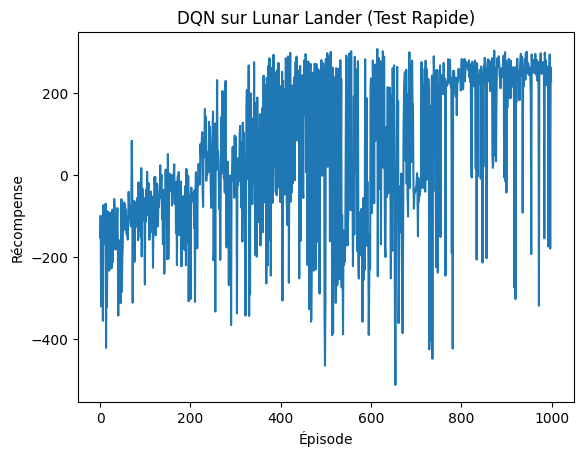

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configuration du Périphérique (GPU/CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Création de l'Environnement (Version Discrète) ---
# continuous=False est la valeur par défaut pour "LunarLander-v3"
env = gym.make(id="LunarLander-v3", gravity=-10, enable_wind=False)

print(f"Action space : {env.action_space}")
print(f"Observation space : {env.observation_space}")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Dimension of state : {state_dim}")
print(f"Dimension of action : {action_dim}")

# --- 3. Définition du Réseau (DQN) ---
class DQN(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(state_dim, 128, bias=True)
    self.fc2 = nn.Linear(128, 128, bias=True)
    self.fc3 = nn.Linear(128, action_dim, bias=True)
    self.relu = nn.ReLU()

  def forward(self, input):
    x = self.relu(self.fc1(input))
    x = self.relu(self.fc2(x))
    return self.fc3(x)

# --- 4. Hyperparamètres ---
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000  # Moins pertinent pour 50 épisodes, mais garde la logique
memory_size = 10000
episodes = 1000  # Nombre d'épisodes réduit pour un test rapide

# --- 5. Initialisation ---
# Déplace les réseaux sur le GPU
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Mettre le réseau cible en mode évaluation

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# --- 6. Fonction de Sélection d'Action (Epsilon-Greedy) ---
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        # Convertir l'état en tenseur et le déplacer sur le GPU
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad(): # Pas besoin de calculer les gradients pour l'inférence
            q_values = policy_net(state_tensor)
        return torch.argmax(q_values).item()  # Exploit

# --- 7. Fonction d'Optimisation (CORRIGÉE pour la performance) ---
def optimize_model():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    # --- CORRECTION PERFORMANCE ---
    # Convertir la liste de np.array en UN SEUL np.array, PUIS en tenseur GPU
    state_batch = torch.FloatTensor(np.array(state_batch)).to(device)
    next_state_batch = torch.FloatTensor(np.array(next_state_batch)).to(device)
    # --- FIN CORRECTION ---

    action_batch = torch.LongTensor(action_batch).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(reward_batch).to(device)
    done_batch = torch.FloatTensor(done_batch).to(device)

    # Calculer Q(s, a)
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Calculer V(s') = max_a' Q_target(s', a')
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        # Calculer la valeur cible : r + gamma * V(s')
        # (1 - done_batch) assure que la valeur future est 0 si l'épisode est terminé
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    # Calculer la perte (Loss)
    loss = nn.MSELoss()(q_values, target_q_values)

    # Rétropropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# --- 8. Boucle d'Entraînement Principale ---
rewards_per_episode = []
steps_done = 0

print("Début de l'entraînement...")

for episode in range(episodes):
    # Réinitialiser l'env et dépacker le tuple (state, info)
    state, info = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)

        # Récupérer les 5 valeurs de env.step()
        next_state, reward, terminated, truncated, info = env.step(action)

        # L'épisode est terminé si "terminated" OU "truncated"
        done = terminated or truncated

        # Stocker la transition dans la mémoire
        memory.append((state, action, reward, next_state, done))

        state = next_state
        episode_reward += reward

        optimize_model()

        # Mise à jour du réseau cible (Target Network)
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

    # Décroissance d'Epsilon à la fin de chaque épisode
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

    rewards_per_episode.append(episode_reward)

    if (episode + 1) % 10 == 0:
        print(f"Épisode {episode + 1}/{episodes} | Récompense: {episode_reward:.2f}")

print("Entraînement terminé.")

# --- 9. Affichage des Résultats ---
plt.plot(rewards_per_episode)
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.title('DQN sur Lunar Lander (Test Rapide)')
plt.show()

In [ ]:
# À exécuter dans une cellule
!pip install moviepy

In [ ]:
import base64
import glob
from IPython.display import HTML, display

def show_video(video_folder="videos"):
  """
  Affiche la vidéo la plus récente trouvée dans le dossier spécifié.
  """
  mp4list = glob.glob(f'./{video_folder}/*.mp4')
  if len(mp4list) > 0:
    # Prend la vidéo la plus récente
    mp4 = sorted(mp4list, key=lambda x: x.split("-")[-1])[-1]
    video = open(mp4, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(video).decode()

    print(f"Affichage de la vidéo : {mp4}")
    display(HTML(f"""
    <video width=400 controls style="margin: 0 auto;">
          <source src="{data_url}" type="video/mp4">
    </video>"""))
  else:
    print(f"Erreur : Aucune vidéo trouvée dans le dossier '{video_folder}'")

In [ ]:
from gymnasium.wrappers import RecordVideo

# 1. Recréer l'environnement, mais cette fois-ci pour l'enregistrement
# render_mode="rgb_array" est nécessaire pour que RecordVideo puisse capturer les images
eval_env = gym.make("LunarLander-v3", render_mode="rgb_array")

# 2. Envelopper l'environnement avec le wrapper RecordVideo
# Il enregistrera dans le dossier "videos"
# episode_trigger=lambda e: e == 0 signifie qu'il n'enregistrera que le premier épisode
eval_env = RecordVideo(eval_env, "videos",
                       episode_trigger=lambda e: e == 0,
                       name_prefix="dqn-lunar-lander")

print("Début de l'évaluation vidéo (l'agent utilise sa politique apprise)...")

# 3. Réinitialiser l'environnement (commence l'enregistrement)
state, info = eval_env.reset()
done = False
total_reward = 0

while not done:
    # 4. SÉLECTION D'ACTION :
    # Utiliser le réseau entraîné (policy_net) en mode "exploitation"
    # (epsilon = 0, pas d'action aléatoire)
    state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = policy_net(state_tensor)

    action = torch.argmax(q_values).item()

    # 5. Agir dans l'environnement vidéo
    next_state, reward, terminated, truncated, info = eval_env.step(action)

    state = next_state
    total_reward += reward
    done = terminated or truncated

print(f"Évaluation terminée. Récompense totale: {total_reward:.2f}")

# 6. Fermer l'environnement (ceci finalise et sauvegarde la vidéo)
eval_env.close()

Début de l'évaluation vidéo (l'agent utilise sa politique apprise)...
Évaluation terminée. Récompense totale: 158.36


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


In [ ]:
# Appelle la fonction pour afficher la vidéo du dossier "videos"
show_video("videos")

Affichage de la vidéo : ./videos/dqn-lunar-lander-episode-0.mp4


In [ ]:
import gym
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# ==========================================
# 1. LE CERVEAU (Neural Network)
# ==========================================
# C'est l'artiste. Il prend l'état (4 chiffres) et dessine la valeur de chaque action.
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # Couche cachée 1
            nn.ReLU(),                  # Activation (Non-linéarité)
            nn.Linear(128, 128),        # Couche cachée 2
            nn.ReLU(),
            nn.Linear(128, output_dim)  # Sortie: [Q(gauche), Q(droite)]
        )

    def forward(self, x):
        return self.net(x)

# ==========================================
# 2. LA MÉMOIRE (Replay Buffer)
# ==========================================
# C'est le sac où on mélange les cartes pour casser les corrélations temporelles.
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity) # deque éjecte auto les vieux éléments

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # On pioche au hasard !
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# ==========================================
# 3. HYPERPARAMÈTRES ET CONFIG
# ==========================================
env = gym.make("CartPole-v1") # L'environnement physique

# Configuration du "Hardware"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paramètres d'apprentissage
BATCH_SIZE = 128        # Nombre de souvenirs revécus à chaque pas
GAMMA = 0.99            # L'importance du futur (0.99 = très important)
EPS_START = 0.9         # Curiosité au début (90% exploration)
EPS_END = 0.05          # Curiosité à la fin (5% exploration)
EPS_DECAY = 1000        # Vitesse de décroissance de la curiosité
TARGET_UPDATE = 10      # On met à jour le Target Network tous les 10 épisodes
LR = 1e-4               # Learning Rate (Vitesse d'apprentissage)

# Initialisation des réseaux
n_actions = env.action_space.n  # 2 actions: gauche, droite
n_observations = env.observation_space.shape[0] # 4 obs: pos, vit, angle, vit_angulaire

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Synchronisation initiale
target_net.eval() # Le target net ne s'entraîne jamais directement

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)

steps_done = 0

# ==========================================
# 4. FONCTIONS UTILITAIRES
# ==========================================

def select_action(state):
    """Epsilon-Greedy: Choisir entre Explorer et Exploiter"""
    global steps_done
    sample = random.random()

    # Formule de décroissance exponentielle pour epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # EXPLOITATION: Le réseau décide
            # t.max(1) retourne le max de chaque ligne. [1] retourne l'index (l'action)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # EXPLORATION: Hasard complet
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    """Le Cœur du Q-Learning: La Descente de Gradient"""
    if len(memory) < BATCH_SIZE:
        return # Pas assez de souvenirs pour apprendre

    # 1. Rêver (Sample)
    transitions = memory.sample(BATCH_SIZE)
    # Transposition du batch (convertir liste de tuples en tuple de listes)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = transitions

    # Conversion en Tenseurs PyTorch (pour le GPU/CPU)
    state_batch = torch.tensor(np.array(batch_state), device=device, dtype=torch.float32)
    action_batch = torch.tensor(batch_action, device=device).unsqueeze(1)
    reward_batch = torch.tensor(batch_reward, device=device).unsqueeze(1)
    non_final_next_states = torch.tensor(np.array(batch_next_state), device=device, dtype=torch.float32)
    # Masque pour gérer le "done"
    # Si done=True, on veut multiplier le futur par 0.
    done_mask = torch.tensor(batch_done, device=device, dtype=torch.float32).unsqueeze(1)

    # 2. Prédire (Q_online)
    # On demande au réseau: "Combien valait l'action que j'ai PRISE ?"
    # gather(1, action_batch) va chercher la valeur Q correspondant à l'action choisie
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 3. Calculer la Cible (Target)
    # On demande au Target Network: "Quelle est la meilleure valeur de l'état SUIVANT ?"
    with torch.no_grad():
        next_state_values = target_net(non_final_next_states).max(1)[0].unsqueeze(1)
        # LA FORMULE DE BELLMAN AVEC L'ASTUCE (1 - done)
        # Si done est 1, (1-done) est 0, donc le terme futur disparaît.
        expected_state_action_values = reward_batch + (GAMMA * next_state_values * (1 - done_mask))

    # 4. Apprendre (Huber Loss / SmoothL1Loss est plus stable que MSE)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    # 5. Mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    # Gradient Clipping (pour éviter que les gradients explosent)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# ==========================================
# 5. BOUCLE D'ENTRAÎNEMENT
# ==========================================
print("Début de l'entraînement... Regardez le score monter !")

num_episodes = 200 # Nombre de parties à jouer

for i_episode in range(num_episodes):
    # Reset de l'environnement
    # Gym retourne (state, info) dans les versions récentes
    state_numpy, info = env.reset()
    state = torch.tensor(state_numpy, device=device, dtype=torch.float32).unsqueeze(0)

    total_reward = 0

    for t in range(1000): # Max 1000 steps par épisode
        # A. Choisir action
        action = select_action(state)

        # B. Exécuter action dans l'émulateur
        # step retourne: observation, reward, terminated, truncated, info
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # C. Observer le nouvel état
        if done:
            next_state = None # Pas d'état après la mort
        else:
            next_state = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)

        # D. Stocker dans la mémoire
        # Note: On stocke des numpy arrays pour économiser la mémoire GPU
        memory.push(state_numpy, action.item(), reward.item(), observation, done)

        # E. Passer à l'état suivant
        state_numpy = observation
        state = next_state

        # F. OPTIMISER LE MODÈLE (Apprentissage)
        optimize_model()

        if done:
            break

    # G. Mettre à jour le Target Network périodiquement
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Épisode {i_episode} | Score: {total_reward}")

print("Entraînement terminé.")
env.close()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist

Début de l'entraînement... Regardez le score monter !


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ValueError: too many values to unpack (expected 2)

Lancement de l'entraînement sur 10000 épisodes...
Episode 2000/10000 - Epsilon: 0.368 - Taux succès global: 55.60%
Episode 4000/10000 - Epsilon: 0.135 - Taux succès global: 60.02%
Episode 6000/10000 - Epsilon: 0.050 - Taux succès global: 63.30%
Episode 8000/10000 - Epsilon: 0.050 - Taux succès global: 64.34%
Episode 10000/10000 - Epsilon: 0.050 - Taux succès global: 65.14%


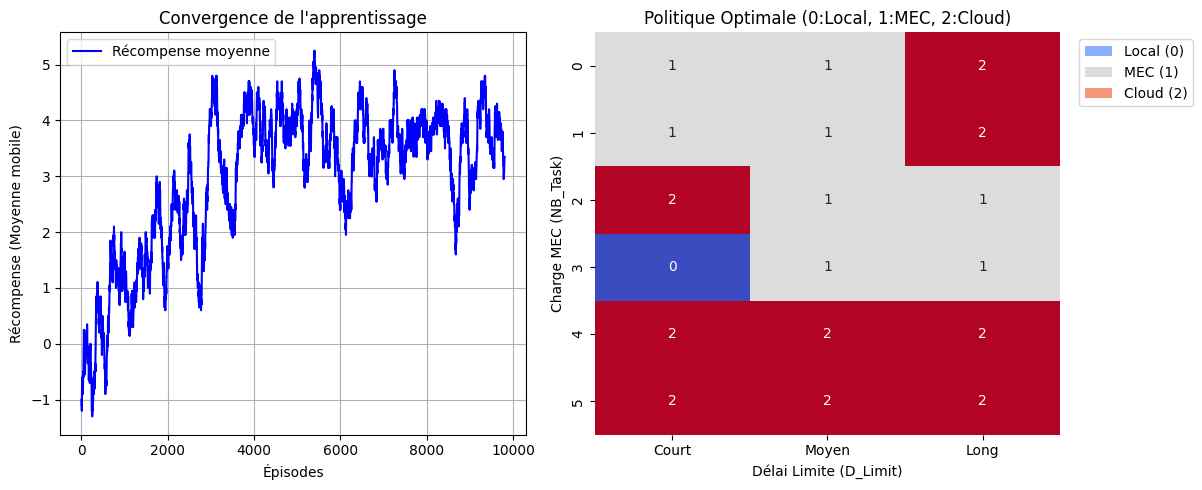

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ==========================================
# 1. CONFIGURATION DE L'ENVIRONNEMENT
# ==========================================
class SystemConfig:
    # Capacités de calcul (Tâche / seconde)
    SPEED_LOCAL = 1.0    # CPU faible
    SPEED_MEC   = 4.0    # CPU moyen
    SPEED_CLOUD = 15.0   # CPU très puissant

    # Latences Réseau (secondes aller-retour)
    LATENCY_LOCAL = 0.0
    LATENCY_MEC   = 1.5
    LATENCY_CLOUD = 5.0  # Latence élevée (distance)

    # Limites
    MAX_MEC_QUEUE = 5    # Taille max de la file d'attente MEC
    TASK_SIZE     = 10.0 # Taille standard d'une tâche (Mcycles)

# ==========================================
# 2. L'ENVIRONNEMENT (Le Monde)
# ==========================================
class OffloadingEnv:
    def __init__(self):
        # Espace d'action : 0=Local, 1=MEC, 2=Cloud
        self.action_space = [0, 1, 2]
        self.config = SystemConfig()

    def reset(self):
        """Génère un nouvel état aléatoire (Nouvelle requête utilisateur)"""
        # 1. État de la file d'attente MEC (0 à 5 tâches en attente)
        self.mec_queue = np.random.randint(0, self.config.MAX_MEC_QUEUE + 1)

        # 2. Contrainte de temps (Deadline) - Aléatoire entre 2s et 12s
        self.deadline_val = np.random.uniform(2.0, 12.0)

        # On retourne l'état discrétisé pour le Q-Learning
        return self._get_state_index()

    def _get_state_index(self):
        """Convertit les valeurs continues en index pour la Q-Table"""
        # Index 1: Charge MEC (0-5) -> tel quel
        queue_idx = self.mec_queue

        # Index 2: Deadline (Discrétisation : Court, Moyen, Long)
        if self.deadline_val < 5.0:
            deadline_idx = 0 # Court
        elif self.deadline_val < 8.0:
            deadline_idx = 1 # Moyen
        else:
            deadline_idx = 2 # Long

        return (queue_idx, deadline_idx)

    def step(self, action):
        """Simule l'exécution de la tâche"""
        cfg = self.config
        time_total = 0

        # --- LOGIQUE PHYSIQUE ---
        if action == 0: # LOCAL
            proc_time = cfg.TASK_SIZE / cfg.SPEED_LOCAL
            time_total = proc_time + cfg.LATENCY_LOCAL

        elif action == 1: # MEC
            # Si MEC plein -> Pénalité immédiate (surcharge)
            if self.mec_queue >= cfg.MAX_MEC_QUEUE:
                # On simule un temps infini ou un échec
                return self._get_state_index(), -20, True, False

            proc_time = cfg.TASK_SIZE / cfg.SPEED_MEC
            wait_time = self.mec_queue * 0.5 # Estimation attente
            time_total = proc_time + cfg.LATENCY_MEC + wait_time

        elif action == 2: # CLOUD
            proc_time = cfg.TASK_SIZE / cfg.SPEED_CLOUD
            # Cloud a toujours de la place, pas de wait_time significatif
            time_total = proc_time + cfg.LATENCY_CLOUD

        # --- VERIFICATION SUCCES/ECHEC ---
        success = False
        if time_total <= self.deadline_val:
            reward = 10  # Grosse récompense si succès
            success = True
        else:
            reward = -10 # Grosse punition si délai dépassé
            success = False

        # Note: L'état suivant est un nouvel état aléatoire (nouvelle requête)
        next_state = self.reset()

        return next_state, reward, True, success

# ==========================================
# 3. L'AGENT (Le Cerveau)
# ==========================================
class QAgent:
    def __init__(self, n_states_queue, n_states_deadline, n_actions):
        self.q_table = np.zeros((n_states_queue, n_states_deadline, n_actions))

        # Hyperparamètres
        self.lr = 0.1          # Learning Rate (Alpha)
        self.gamma = 0.9       # Facteur d'actualisation
        self.epsilon = 1.0     # Taux d'exploration (Commence à 100%)
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995 # Décroissance lente

    def choose_action(self, state):
        q_idx, d_idx = state

        # Exploration
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1, 2])

        # Exploitation (Meilleure valeur connue)
        return np.argmax(self.q_table[q_idx, d_idx, :])

    def learn(self, state, action, reward, next_state):
        q_idx, d_idx = state
        nq_idx, nd_idx = next_state

        predict = self.q_table[q_idx, d_idx, action]
        target = reward + self.gamma * np.max(self.q_table[nq_idx, nd_idx, :])

        # Mise à jour de Bellman
        self.q_table[q_idx, d_idx, action] = predict + self.lr * (target - predict)

        # Réduction de l'exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ==========================================
# 4. ENTRAÎNEMENT ET VISUALISATION
# ==========================================
def run_simulation():
    env = OffloadingEnv()
    # Queue (0-5 -> 6 états), Deadline (3 états), Actions (3)
    agent = QAgent(6, 3, 3)

    episodes = 10000
    rewards_history = []
    success_count = 0

    print(f"Lancement de l'entraînement sur {episodes} épisodes...")

    for e in range(episodes):
        state = env.reset() # Initialise état (NB_Task, D_Limit)

        # Étape unique par épisode (une requête utilisateur)
        action = agent.choose_action(state)
        next_state, reward, done, success = env.step(action)

        agent.learn(state, action, reward, next_state)

        rewards_history.append(reward)
        if success: success_count += 1

        if (e+1) % 2000 == 0:
            print(f"Episode {e+1}/{episodes} - Epsilon: {agent.epsilon:.3f} - Taux succès global: {success_count/(e+1):.2%}")

    return agent, rewards_history

def plot_results(agent, rewards):
    # --- GRAPHIQUE 1 : Apprentissage (Moyenne mobile) ---
    plt.figure(figsize=(12, 5))

    # Calcul de la moyenne mobile sur 100 épisodes pour lisser la courbe
    window = 200
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

    plt.subplot(1, 2, 1)
    plt.plot(moving_avg, color='blue', label='Récompense moyenne')
    plt.title("Convergence de l'apprentissage")
    plt.xlabel("Épisodes")
    plt.ylabel("Récompense (Moyenne mobile)")
    plt.grid(True)
    plt.legend()

    # --- GRAPHIQUE 2 : La Q-Table (Heatmap) ---
    # On va visualiser la meilleure action pour chaque état
    # 0=Local (Bleu), 1=MEC (Vert), 2=Cloud (Rouge)
    best_actions = np.argmax(agent.q_table, axis=2)

    plt.subplot(1, 2, 2)
    ax = sns.heatmap(best_actions, annot=True, cmap="coolwarm", cbar=False,
                     xticklabels=["Court", "Moyen", "Long"],
                     yticklabels=[0, 1, 2, 3, 4, 5])

    plt.title("Politique Optimale (0:Local, 1:MEC, 2:Cloud)")
    plt.xlabel("Délai Limite (D_Limit)")
    plt.ylabel("Charge MEC (NB_Task)")

    # Légende manuelle pour comprendre les couleurs
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=sns.color_palette("coolwarm", 3)[0], label='Local (0)'),
        Patch(facecolor=sns.color_palette("coolwarm", 3)[1], label='MEC (1)'),
        Patch(facecolor=sns.color_palette("coolwarm", 3)[2], label='Cloud (2)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN
# ==========================================
if __name__ == "__main__":
    trained_agent, history = run_simulation()
    plot_results(trained_agent, history)

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# ==========================================
# 1. L'ENVIRONNEMENT GYMNASIUM (Custom)
# ==========================================
class OffloadingGymEnv(gym.Env):
    """
    Environnement personnalisé suivant l'interface Gymnasium.
    État (Observation) : [Charge_MEC (0-5), Deadline (0.0-15.0)]
    Action : 0=Local, 1=MEC, 2=Cloud
    """
    def __init__(self):
        super(OffloadingGymEnv, self).__init__()

        # --- Paramètres du système ---
        self.SPEED_LOCAL = 1.0
        self.SPEED_MEC = 4.0
        self.SPEED_CLOUD = 15.0
        self.LATENCY_MEC = 1.5
        self.LATENCY_CLOUD = 5.0
        self.TASK_SIZE = 10.0
        self.MAX_QUEUE = 5

        # --- Définition des Espaces (Spaces) ---
        # Action : 3 choix discrets
        self.action_space = spaces.Discrete(3)

        # Observation : Box(2,) -> [Queue_Size, Deadline]
        # On utilise des floats pour le réseau de neurones
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([self.MAX_QUEUE, 20.0], dtype=np.float32),
            dtype=np.float32
        )

        # Variables internes
        self.current_queue = 0
        self.current_deadline = 0
        self.steps_count = 0
        self.max_steps_per_episode = 50 # Une "journée" de 50 tâches

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.steps_count = 0
        # Initialisation aléatoire
        self.current_queue = random.randint(0, self.MAX_QUEUE)
        self.current_deadline = random.uniform(2.0, 12.0)

        # Retourne l'état et un dico vide (info)
        state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)
        return state, {}

    def step(self, action):
        self.steps_count += 1

        # 1. Calcul des temps (Physique)
        proc_time = 0
        wait_time = 0
        transmission_time = 0

        penalty_queue_full = False

        if action == 0: # LOCAL
            proc_time = self.TASK_SIZE / self.SPEED_LOCAL

        elif action == 1: # MEC
            if self.current_queue >= self.MAX_QUEUE:
                penalty_queue_full = True
            else:
                proc_time = self.TASK_SIZE / self.SPEED_MEC
                wait_time = self.current_queue * 0.5
                transmission_time = self.LATENCY_MEC

        elif action == 2: # CLOUD
            proc_time = self.TASK_SIZE / self.SPEED_CLOUD
            transmission_time = self.LATENCY_CLOUD

        total_time = proc_time + wait_time + transmission_time

        # 2. Calcul du Reward
        reward = 0
        if penalty_queue_full:
            reward = -20 # Forte punition si on envoie sur un MEC plein
        elif total_time <= self.current_deadline:
            reward = 10 # Succès
        else:
            reward = -10 # Échec temporel

        # 3. Transition vers l'état suivant (Nouvelle tâche qui arrive)
        # On simule que la queue du MEC évolue un peu aléatoirement
        change = random.choice([-1, 0, 1])
        self.current_queue = max(0, min(self.MAX_QUEUE, self.current_queue + change))
        self.current_deadline = random.uniform(2.0, 12.0)

        next_state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)

        # 4. Conditions d'arrêt
        terminated = False
        truncated = False
        if self.steps_count >= self.max_steps_per_episode:
            truncated = True # Fin de l'épisode

        return next_state, reward, terminated, truncated, {}

# ==========================================
# 2. TON CODE DQN (Adapté)
# ==========================================

# --- Configuration ---
# On instancie NOTRE environnement au lieu de CartPole
env = OffloadingGymEnv()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparamètres
BATCH_SIZE = 64
GAMMA = 0.95
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500
TARGET_UPDATE = 10
LR = 0.001

# Dimensions
n_actions = env.action_space.n # 3 actions
n_observations = env.observation_space.shape[0] # 2 observations

# --- Réseaux ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done
    def __len__(self):
        return len(self.buffer)

memory = ReplayBuffer(10000)
steps_done = 0

# --- Fonctions ---
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE: return
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = transitions

    state_batch = torch.tensor(np.array(batch_state), device=device, dtype=torch.float32)
    action_batch = torch.tensor(batch_action, device=device).unsqueeze(1)
    reward_batch = torch.tensor(batch_reward, device=device).unsqueeze(1)
    non_final_next_states = torch.tensor(np.array(batch_next_state), device=device, dtype=torch.float32)
    done_mask = torch.tensor(batch_done, device=device, dtype=torch.float32).unsqueeze(1)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    with torch.no_grad():
        next_state_values = target_net(non_final_next_states).max(1)[0].unsqueeze(1)
        expected_state_action_values = reward_batch + (GAMMA * next_state_values * (1 - done_mask))

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# ==========================================
# 3. LANCEMENT DE L'ENTRAÎNEMENT
# ==========================================
print(f"Environnement configuré : {n_observations} entrées -> {n_actions} actions")
print("Début de l'entraînement DQN...")

num_episodes = 300

for i_episode in range(num_episodes):
    # Reset Gym (Standard 1.0+)
    state_numpy, info = env.reset()
    state = torch.tensor(state_numpy, device=device, dtype=torch.float32).unsqueeze(0)

    total_reward = 0

    # On joue jusqu'à la fin de l'épisode (défini par max_steps_per_episode dans l'env)
    while True:
        action = select_action(state)

        # Step Gym (Standard 1.0+)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        total_reward += reward
        reward_tensor = torch.tensor([reward], device=device)
        next_state_tensor = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)

        # Mémoire
        memory.push(state_numpy, action.item(), reward_tensor.item(), observation, done)

        state_numpy = observation
        state = next_state_tensor

        optimize_model()

        if done:
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if i_episode % 10 == 0:
        print(f"Épisode {i_episode} | Score Total: {total_reward:.1f} | Epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")

print("Fin.")

Environnement configuré : 2 entrées -> 3 actions
Début de l'entraînement DQN...
Épisode 0 | Score Total: -100.0 | Epsilon: 0.91
Épisode 10 | Score Total: 140.0 | Epsilon: 0.34
Épisode 20 | Score Total: 200.0 | Epsilon: 0.13
Épisode 30 | Score Total: 140.0 | Epsilon: 0.05
Épisode 40 | Score Total: 240.0 | Epsilon: 0.03
Épisode 50 | Score Total: 140.0 | Epsilon: 0.02
Épisode 60 | Score Total: 80.0 | Epsilon: 0.01
Épisode 70 | Score Total: 180.0 | Epsilon: 0.01
Épisode 80 | Score Total: 180.0 | Epsilon: 0.01
Épisode 90 | Score Total: 200.0 | Epsilon: 0.01
Épisode 100 | Score Total: 160.0 | Epsilon: 0.01
Épisode 110 | Score Total: 80.0 | Epsilon: 0.01
Épisode 120 | Score Total: 100.0 | Epsilon: 0.01
Épisode 130 | Score Total: 80.0 | Epsilon: 0.01
Épisode 140 | Score Total: 180.0 | Epsilon: 0.01
Épisode 150 | Score Total: 180.0 | Epsilon: 0.01
Épisode 160 | Score Total: 220.0 | Epsilon: 0.01
Épisode 170 | Score Total: 80.0 | Epsilon: 0.01
Épisode 180 | Score Total: 220.0 | Epsilon: 0.01
Épi

Début de l'entraînement...
Episode 0 - Score: -150
Episode 50 - Score: 160
Episode 100 - Score: 80
Episode 150 - Score: 240
Episode 200 - Score: 160
Episode 250 - Score: 240
Episode 300 - Score: 100
Episode 350 - Score: 260
Episode 400 - Score: 220
Episode 450 - Score: 180
Episode 500 - Score: 200
Episode 550 - Score: 140
Episode 600 - Score: 160
Episode 650 - Score: 80
Episode 700 - Score: 140
Episode 750 - Score: 280
Episode 800 - Score: 40
Episode 850 - Score: 80
Episode 900 - Score: 300
Episode 950 - Score: 340
Affichage des graphiques...


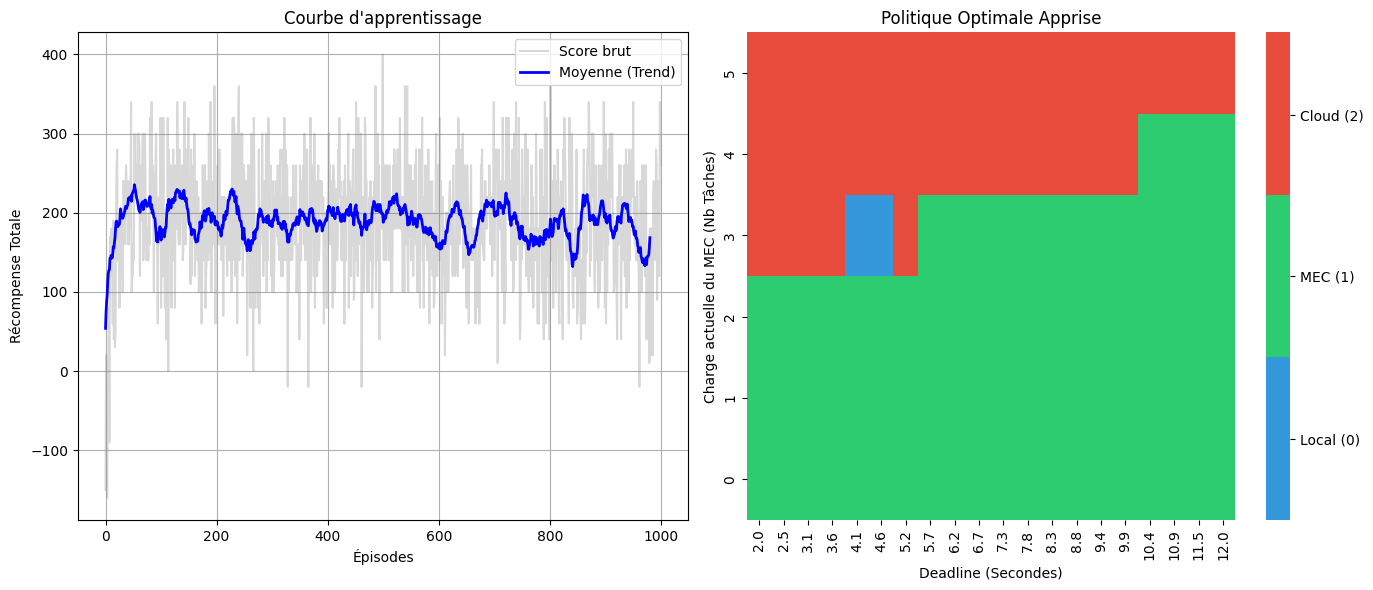

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. ENVIRONNEMENT (Le Monde)
# ==========================================
class OffloadingGymEnv(gym.Env):
    def __init__(self):
        super(OffloadingGymEnv, self).__init__()
        self.SPEED_LOCAL = 1.0
        self.SPEED_MEC = 4.0
        self.SPEED_CLOUD = 15.0
        self.LATENCY_MEC = 1.5
        self.LATENCY_CLOUD = 5.0
        self.TASK_SIZE = 10.0
        self.MAX_QUEUE = 5

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([self.MAX_QUEUE, 20.0], dtype=np.float32),
            dtype=np.float32
        )
        self.max_steps_per_episode = 50

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps_count = 0
        self.current_queue = random.randint(0, self.MAX_QUEUE)
        self.current_deadline = random.uniform(2.0, 12.0)
        state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)
        return state, {}

    def step(self, action):
        self.steps_count += 1
        proc_time = 0
        wait_time = 0
        transmission_time = 0
        penalty_queue_full = False

        if action == 0: # LOCAL
            proc_time = self.TASK_SIZE / self.SPEED_LOCAL
        elif action == 1: # MEC
            if self.current_queue >= self.MAX_QUEUE:
                penalty_queue_full = True
            else:
                proc_time = self.TASK_SIZE / self.SPEED_MEC
                wait_time = self.current_queue * 0.5
                transmission_time = self.LATENCY_MEC
        elif action == 2: # CLOUD
            proc_time = self.TASK_SIZE / self.SPEED_CLOUD
            transmission_time = self.LATENCY_CLOUD

        total_time = proc_time + wait_time + transmission_time

        reward = 0
        if penalty_queue_full:
            reward = -20
        elif total_time <= self.current_deadline:
            reward = 10
        else:
            reward = -10

        change = random.choice([-1, 0, 1])
        self.current_queue = max(0, min(self.MAX_QUEUE, self.current_queue + change))
        self.current_deadline = random.uniform(2.0, 12.0)

        next_state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)
        terminated = False
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return next_state, reward, terminated, truncated, {}

# ==========================================
# 2. AGENT DQN & CONFIG
# ==========================================
env = OffloadingGymEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
GAMMA = 0.95
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500
TARGET_UPDATE = 10
LR = 0.001

n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = deque(maxlen=10000)
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE: return
    batch = random.sample(memory, BATCH_SIZE)
    state, action, reward, next_state, done = zip(*batch)

    state_batch = torch.tensor(np.array(state), device=device, dtype=torch.float32)
    action_batch = torch.tensor(action, device=device).unsqueeze(1)
    reward_batch = torch.tensor(reward, device=device).unsqueeze(1)
    next_state_batch = torch.tensor(np.array(next_state), device=device, dtype=torch.float32)
    done_batch = torch.tensor(done, device=device, dtype=torch.float32).unsqueeze(1)

    q_values = policy_net(state_batch).gather(1, action_batch)
    with torch.no_grad():
        next_q_values = target_net(next_state_batch).max(1)[0].unsqueeze(1)
        expected_q_values = reward_batch + (GAMMA * next_q_values * (1 - done_batch))

    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# ==========================================
# 3. ENTRAÎNEMENT
# ==========================================
print("Début de l'entraînement...")
num_episodes = 400
scores_history = []

for i_episode in range(num_episodes):
    state_numpy, _ = env.reset()
    state = torch.tensor(state_numpy, device=device, dtype=torch.float32).unsqueeze(0)
    total_reward = 0

    while True:
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        total_reward += reward

        memory.append((state_numpy, action.item(), reward, observation, done))

        state_numpy = observation
        state = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
        optimize_model()

        if done: break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    scores_history.append(total_reward)
    if i_episode % 50 == 0:
        print(f"Episode {i_episode} - Score: {total_reward}")

# ==========================================
# 4. VISUALISATION (Le Graphique & La Matrice)
# ==========================================

def visualize_results(agent, scores):
    plt.figure(figsize=(14, 6))

    # --- A. COURBE D'APPRENTISSAGE ---
    plt.subplot(1, 2, 1)
    plt.plot(scores, alpha=0.3, color='gray', label='Score brut')
    # Moyenne glissante sur 20 épisodes
    moving_avg = np.convolve(scores, np.ones(20)/20, mode='valid')
    plt.plot(moving_avg, color='blue', linewidth=2, label='Moyenne (Trend)')
    plt.title("Courbe d'apprentissage")
    plt.xlabel("Épisodes")
    plt.ylabel("Récompense Totale")
    plt.legend()
    plt.grid(True)

    # --- B. MATRICE DE DÉCISION (HEATMAP) ---
    plt.subplot(1, 2, 2)

    # On définit une grille pour "scanner" le cerveau de l'IA
    # Axe Y : Queue MEC (0 à 5)
    queue_vals = np.arange(6)
    # Axe X : Deadline (2.0 à 12.0) - On coupe en 20 morceaux
    deadline_vals = np.linspace(2.0, 12.0, 20)

    # On va remplir cette grille avec l'action choisie (0, 1 ou 2)
    policy_grid = np.zeros((len(queue_vals), len(deadline_vals)))

    with torch.no_grad():
        for i, q in enumerate(queue_vals):
            for j, d in enumerate(deadline_vals):
                # On crée un faux état pour tester l'IA
                state_tensor = torch.tensor([q, d], device=device, dtype=torch.float32).unsqueeze(0)
                # On demande à l'IA : "Que ferais-tu ici ?"
                action = agent(state_tensor).max(1)[1].item()
                policy_grid[i, j] = action

    # Création de la Heatmap avec Seaborn
    # Colormap discrète : 0=Bleu (Local), 1=Vert (MEC), 2=Rouge (Cloud)
    cmap = sns.color_palette(["#3498db", "#2ecc71", "#e74c3c"])
    ax = sns.heatmap(policy_grid, cmap=cmap, cbar=True,
                     xticklabels=np.round(deadline_vals, 1),
                     yticklabels=queue_vals)

    # Configuration des labels
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.33, 1, 1.66])
    cbar.set_ticklabels(['Local (0)', 'MEC (1)', 'Cloud (2)'])

    plt.title("Politique Optimale Apprise")
    plt.xlabel("Deadline (Secondes)")
    plt.ylabel("Charge actuelle du MEC (Nb Tâches)")
    plt.gca().invert_yaxis() # Pour avoir 0 en bas

    plt.tight_layout()
    plt.show()

print("Affichage des graphiques...")
visualize_results(policy_net, scores_history)

Début de l'entraînement Double DQN + Reward Shaping...
Episode 0 - Score: -86.9
Episode 50 - Score: 110.3
Episode 100 - Score: 290.1
Episode 150 - Score: 259.3
Episode 200 - Score: 255.4
Episode 250 - Score: 304.8
Episode 300 - Score: 357.0
Episode 350 - Score: 430.6
Episode 400 - Score: 287.8
Episode 450 - Score: 103.3
Episode 500 - Score: 291.2
Episode 550 - Score: 289.7
Episode 600 - Score: 360.8
Episode 650 - Score: 227.9
Episode 700 - Score: 241.6
Episode 750 - Score: 94.1
Episode 800 - Score: 387.3
Episode 850 - Score: 212.0
Episode 900 - Score: 194.5
Episode 950 - Score: 306.4
Affichage des résultats...


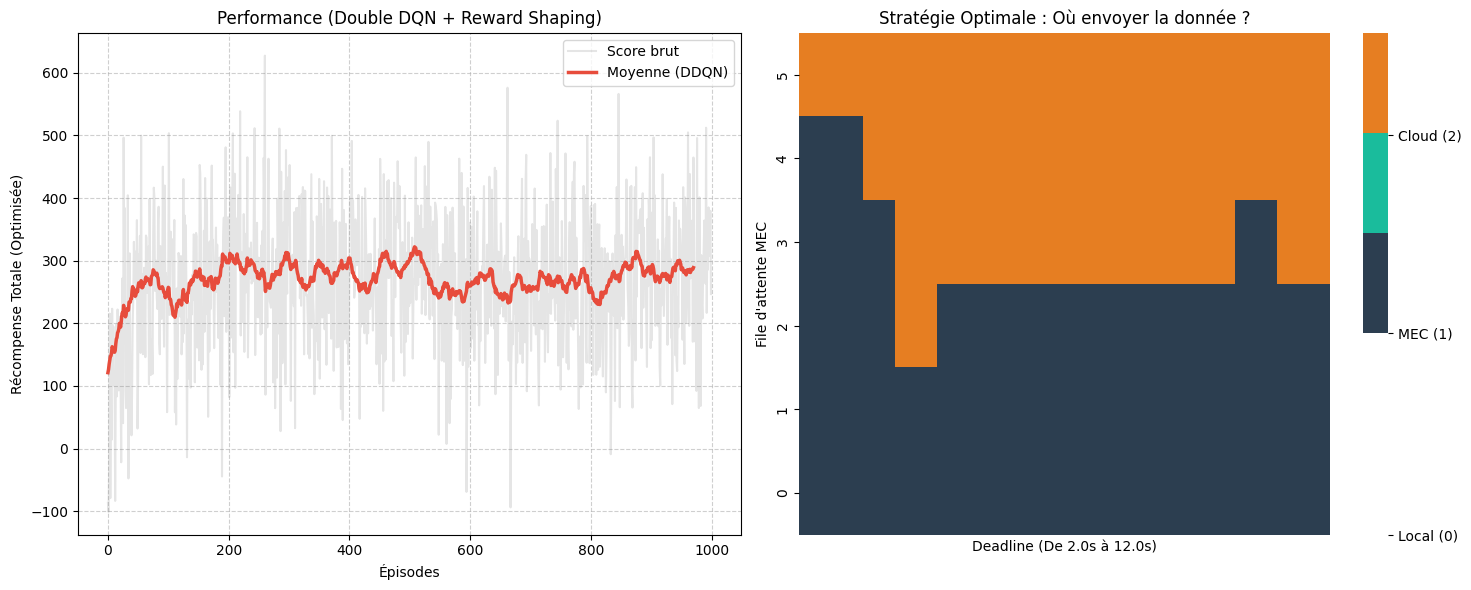

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. ENVIRONNEMENT AMÉLIORÉ (Reward Shaping)
# ==========================================
class OffloadingGymEnv(gym.Env):
    def __init__(self):
        super(OffloadingGymEnv, self).__init__()
        # Paramètres physiques
        self.SPEED_LOCAL = 1.0
        self.SPEED_MEC = 4.0
        self.SPEED_CLOUD = 15.0
        self.LATENCY_MEC = 1.5
        self.LATENCY_CLOUD = 5.0
        self.TASK_SIZE = 10.0
        self.MAX_QUEUE = 5

        # Espaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([self.MAX_QUEUE, 20.0], dtype=np.float32),
            dtype=np.float32
        )
        self.max_steps_per_episode = 50

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps_count = 0
        self.current_queue = random.randint(0, self.MAX_QUEUE)
        self.current_deadline = random.uniform(2.0, 12.0)
        return np.array([self.current_queue, self.current_deadline], dtype=np.float32), {}

    def step(self, action):
        self.steps_count += 1
        proc_time, wait_time, transmission_time = 0, 0, 0
        penalty_queue_full = False

        # --- PHYSIQUE DU SYSTÈME ---
        if action == 0: # LOCAL
            proc_time = self.TASK_SIZE / self.SPEED_LOCAL
        elif action == 1: # MEC
            if self.current_queue >= self.MAX_QUEUE:
                penalty_queue_full = True
            else:
                proc_time = self.TASK_SIZE / self.SPEED_MEC
                wait_time = self.current_queue * 0.5
                transmission_time = self.LATENCY_MEC
        elif action == 2: # CLOUD
            proc_time = self.TASK_SIZE / self.SPEED_CLOUD
            transmission_time = self.LATENCY_CLOUD

        total_time = proc_time + wait_time + transmission_time

        # --- REWARD SHAPING (NOUVEAU) ---
        reward = 0
        if penalty_queue_full:
            # Pénalité critique : on interdit de saturer le MEC
            reward = -20
        elif total_time <= self.current_deadline:
            # SUCCÈS : Base (+10) + Bonus de rapidité (Temps économisé)
            time_saved = self.current_deadline - total_time
            reward = 10.0 + time_saved
        else:
            # ÉCHEC : Pénalité de base (-10) - Malus de retard
            time_wasted = total_time - self.current_deadline
            reward = -10.0 - time_wasted

        # Evolution de l'environnement
        change = random.choice([-1, 0, 1])
        self.current_queue = max(0, min(self.MAX_QUEUE, self.current_queue + change))
        self.current_deadline = random.uniform(2.0, 12.0)

        next_state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return next_state, reward, False, truncated, {}

# ==========================================
# 2. AGENT DOUBLE DQN (DDQN)
# ==========================================
env = OffloadingGymEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparamètres
BATCH_SIZE = 128    # Batch plus gros pour meilleure stabilité
GAMMA = 0.99        # On regarde loin dans le futur
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 1000    # Décroissance plus lente
TARGET_UPDATE = 20  # Mise à jour moins fréquente pour stabilité
LR = 0.0005         # Learning rate plus fin

n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # Réseau plus large (64->128)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Deux réseaux : Policy (Action) et Target (Stabilité)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = deque(maxlen=20000) # Mémoire plus grande
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE: return
    batch = random.sample(memory, BATCH_SIZE)
    state, action, reward, next_state, done = zip(*batch)

    state_batch = torch.tensor(np.array(state), device=device, dtype=torch.float32)
    action_batch = torch.tensor(action, device=device).unsqueeze(1)
    reward_batch = torch.tensor(reward, device=device).unsqueeze(1)
    next_state_batch = torch.tensor(np.array(next_state), device=device, dtype=torch.float32)
    done_batch = torch.tensor(done, device=device, dtype=torch.float32).unsqueeze(1)

    # Q(s, a) actuel
    q_values = policy_net(state_batch).gather(1, action_batch)

    # --- ALGORITHME DOUBLE DQN (DDQN) ---
    with torch.no_grad():
        # 1. Sélection de l'action avec Policy Net (argmax Q_policy)
        best_next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        # 2. Évaluation de cette action avec Target Net
        next_q_values = target_net(next_state_batch).gather(1, best_next_actions)

        # 3. Calcul de la cible
        expected_q_values = reward_batch + (GAMMA * next_q_values * (1 - done_batch))

    # Calcul de la perte et Backprop
    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10) # Clip plus serré
    optimizer.step()

# ==========================================
# 3. ENTRAÎNEMENT
# ==========================================
print("Début de l'entraînement Double DQN + Reward Shaping...")
num_episodes = 400
scores_history = []

for i_episode in range(num_episodes):
    state_numpy, _ = env.reset()
    state = torch.tensor(state_numpy, device=device, dtype=torch.float32).unsqueeze(0)
    total_reward = 0

    while True:
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        total_reward += reward

        memory.append((state_numpy, action.item(), reward, observation, done))

        state_numpy = observation
        state = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
        optimize_model()

        if done: break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    scores_history.append(total_reward)
    if i_episode % 50 == 0:
        print(f"Episode {i_episode} - Score: {total_reward:.1f}")

# ==========================================
# 4. VISUALISATION AVANCÉE
# ==========================================
def visualize_results(agent, scores):
    plt.figure(figsize=(15, 6))

    # --- A. COURBE D'APPRENTISSAGE ---
    plt.subplot(1, 2, 1)
    plt.plot(scores, alpha=0.2, color='gray', label='Score brut')
    moving_avg = np.convolve(scores, np.ones(30)/30, mode='valid')
    plt.plot(moving_avg, color='#e74c3c', linewidth=2.5, label='Moyenne (DDQN)')
    plt.title("Performance (Double DQN + Reward Shaping)")
    plt.xlabel("Épisodes")
    plt.ylabel("Récompense Totale (Optimisée)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- B. MATRICE DE DÉCISION (HEATMAP) ---
    plt.subplot(1, 2, 2)

    queue_vals = np.arange(6)
    deadline_vals = np.linspace(2.0, 12.0, 50) # Résolution plus fine (50 points)

    policy_grid = np.zeros((len(queue_vals), len(deadline_vals)))

    with torch.no_grad():
        for i, q in enumerate(queue_vals):
            for j, d in enumerate(deadline_vals):
                state_tensor = torch.tensor([q, d], device=device, dtype=torch.float32).unsqueeze(0)
                action = agent(state_tensor).max(1)[1].item()
                policy_grid[i, j] = action

    # Couleurs customs : Local=Bleu nuit, MEC=Turquoise, Cloud=Orange
    cmap = sns.color_palette(["#2c3e50", "#1abc9c", "#e67e22"])
    ax = sns.heatmap(policy_grid, cmap=cmap, cbar=True,
                     xticklabels=False, yticklabels=queue_vals)

    # Légende propre
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.33, 1, 1.66])
    cbar.set_ticklabels(['Local (0)', 'MEC (1)', 'Cloud (2)'])

    plt.title("Stratégie Optimale : Où envoyer la donnée ?")
    plt.xlabel(f"Deadline (De 2.0s à 12.0s)")
    plt.ylabel("File d'attente MEC")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

print("Affichage des résultats...")
visualize_results(policy_net, scores_history)

--- Lancement Expérience : Baseline (Équilibré) (LR=0.0005, Gamma=0.99) ---


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:1077: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


--- Lancement Expérience : Impatient (Rapide & Instable) (LR=0.005, Gamma=0.8) ---
--- Lancement Expérience : Prudent (Lent & Stable) (LR=0.0001, Gamma=0.99) ---


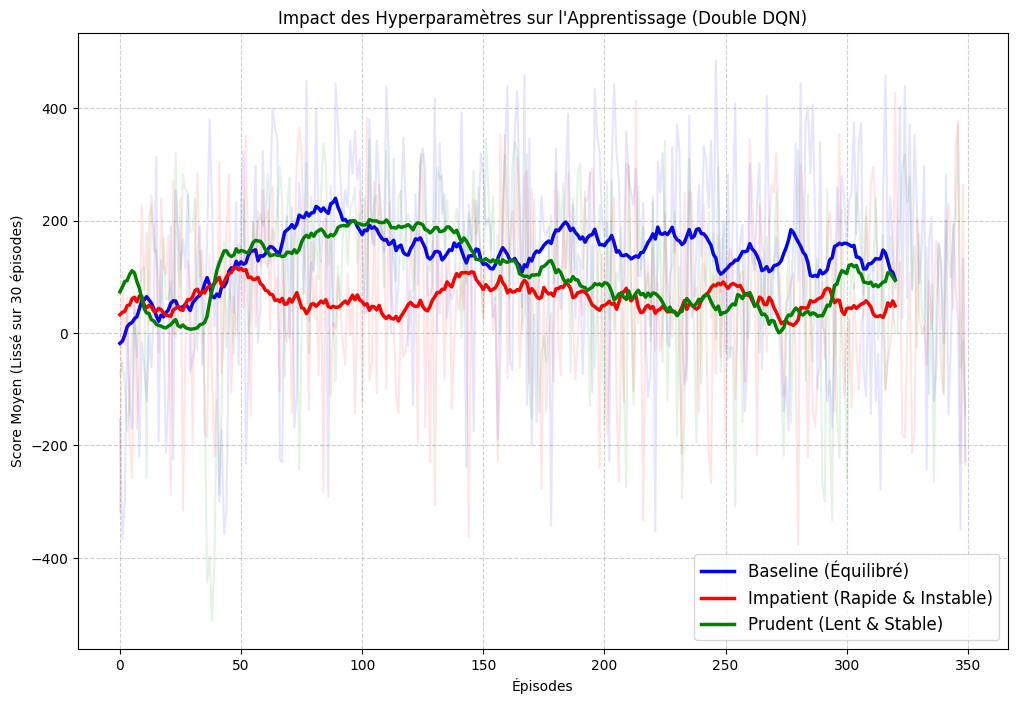

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# ==========================================
# 1. MÊME ENVIRONNEMENT (Avec Reward Shaping)
# ==========================================
class OffloadingGymEnv(gym.Env):
    def __init__(self):
        super(OffloadingGymEnv, self).__init__()
        self.SPEED_LOCAL = 1.0
        self.SPEED_MEC = 4.0
        self.SPEED_CLOUD = 15.0
        self.LATENCY_MEC = 1.5
        self.LATENCY_CLOUD = 5.0
        self.TASK_SIZE = 10.0
        self.MAX_QUEUE = 5

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([self.MAX_QUEUE, 20.0], dtype=np.float32),
            dtype=np.float32
        )
        self.max_steps_per_episode = 50

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps_count = 0
        self.current_queue = random.randint(0, self.MAX_QUEUE)
        self.current_deadline = random.uniform(2.0, 12.0)
        return np.array([self.current_queue, self.current_deadline], dtype=np.float32), {}

    def step(self, action):
        self.steps_count += 1
        proc_time, wait_time, transmission_time = 0, 0, 0
        penalty_queue_full = False

        if action == 0: # LOCAL
            proc_time = self.TASK_SIZE / self.SPEED_LOCAL
        elif action == 1: # MEC
            if self.current_queue >= self.MAX_QUEUE:
                penalty_queue_full = True
            else:
                proc_time = self.TASK_SIZE / self.SPEED_MEC
                wait_time = self.current_queue * 0.5
                transmission_time = self.LATENCY_MEC
        elif action == 2: # CLOUD
            proc_time = self.TASK_SIZE / self.SPEED_CLOUD
            transmission_time = self.LATENCY_CLOUD

        total_time = proc_time + wait_time + transmission_time

        reward = 0
        if penalty_queue_full:
            reward = -20
        elif total_time <= self.current_deadline:
            time_saved = self.current_deadline - total_time
            reward = 10.0 + time_saved
        else:
            time_wasted = total_time - self.current_deadline
            reward = -10.0 - time_wasted

        change = random.choice([-1, 0, 1])
        self.current_queue = max(0, min(self.MAX_QUEUE, self.current_queue + change))
        self.current_deadline = random.uniform(2.0, 12.0)

        next_state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return next_state, reward, False, truncated, {}

# ==========================================
# 2. CONFIGURATION DU TEST
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modèle DQN Standard
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Fonction d'entraînement paramétrable
def run_experiment(exp_name, lr, gamma, num_episodes=350):
    print(f"--- Lancement Expérience : {exp_name} (LR={lr}, Gamma={gamma}) ---")

    # Init Environnement & Agent spécifiques à cette expérience
    env = OffloadingGymEnv()
    n_actions = env.action_space.n
    n_observations = env.observation_space.shape[0]

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
    memory = deque(maxlen=20000)

    # Paramètres fixes
    BATCH_SIZE = 128
    EPS_START, EPS_END, EPS_DECAY = 1.0, 0.02, 800
    TARGET_UPDATE = 20

    scores = []
    steps_done = 0

    for i_episode in range(num_episodes):
        state_numpy, _ = env.reset()
        state = torch.tensor(state_numpy, device=device, dtype=torch.float32).unsqueeze(0)
        total_reward = 0

        while True:
            # Select Action
            sample = random.random()
            eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            steps_done += 1

            if sample > eps_threshold:
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)
            else:
                action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

            # Step
            observation, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            total_reward += reward

            # Memory
            reward_tensor = torch.tensor([reward], device=device)
            next_state_tensor = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
            done_tensor = torch.tensor([float(done)], device=device)

            memory.append((state, action, reward_tensor, next_state_tensor, done_tensor))
            state = next_state_tensor

            # Optimize (Double DQN Logic)
            if len(memory) >= BATCH_SIZE:
                batch = random.sample(memory, BATCH_SIZE)
                b_state, b_action, b_reward, b_next, b_done = zip(*batch)

                b_state = torch.cat(b_state)
                b_action = torch.cat(b_action)
                b_reward = torch.cat(b_reward)
                b_next = torch.cat(b_next)
                b_done = torch.cat(b_done).unsqueeze(1)

                q_values = policy_net(b_state).gather(1, b_action)
                with torch.no_grad():
                    best_actions = policy_net(b_next).max(1)[1].unsqueeze(1)
                    next_q_values = target_net(b_next).gather(1, best_actions)
                    expected_q = b_reward + (gamma * next_q_values * (1 - b_done))

                criterion = nn.SmoothL1Loss()
                loss = criterion(q_values, expected_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
                optimizer.step()

            if done: break

        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        scores.append(total_reward)

    return scores

# ==========================================
# 3. LANCEMENT DES 3 SCENARIOS
# ==========================================

# Liste des expériences
scenarios = [
    {"name": "Baseline (Équilibré)", "lr": 0.0005, "gamma": 0.99, "color": "blue"},
    {"name": "Impatient (Rapide & Instable)", "lr": 0.005, "gamma": 0.80, "color": "red"},
    {"name": "Prudent (Lent & Stable)", "lr": 0.0001, "gamma": 0.99, "color": "green"}
]

results = {}

for sc in scenarios:
    scores = run_experiment(sc["name"], sc["lr"], sc["gamma"])
    results[sc["name"]] = scores

# ==========================================
# 4. AFFICHAGE COMPARATIF
# ==========================================
plt.figure(figsize=(12, 8))

for sc in scenarios:
    name = sc["name"]
    color = sc["color"]
    scores = results[name]

    # Calcul Moyenne Mobile (Lissage)
    window = 30
    moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')

    # On affiche d'abord une ligne fine transparente pour les données brutes
    plt.plot(scores, color=color, alpha=0.1)
    # Puis la ligne épaisse pour la moyenne
    plt.plot(moving_avg, color=color, linewidth=2.5, label=f"{name}")

plt.title("Impact des Hyperparamètres sur l'Apprentissage (Double DQN)")
plt.xlabel("Épisodes")
plt.ylabel("Score Moyen (Lissé sur 30 épisodes)")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


 SYSTEME D'ALLOCATION DE RESSOURCES PAR APPRENTISSAGE PAR RENFORCEMENT

Environnement: Gymnasium
Algorithmes: Q-Learning (custom), DQN (custom), PPO (Stable-Baselines3)

ENTRAINEMENT Q-LEARNING
Episode    0 | Reward moyen:    0.92 | Epsilon: 0.995
Episode  200 | Reward moyen:    3.59 | Epsilon: 0.365
Episode  400 | Reward moyen:    4.84 | Epsilon: 0.134
Episode  600 | Reward moyen:    3.87 | Epsilon: 0.049
Episode  800 | Reward moyen:    4.67 | Epsilon: 0.018
Episode 1000 | Reward moyen:    4.57 | Epsilon: 0.010
Episode 1200 | Reward moyen:    4.76 | Epsilon: 0.010
Episode 1400 | Reward moyen:    4.26 | Epsilon: 0.010
Episode 1600 | Reward moyen:    4.17 | Epsilon: 0.010
Episode 1800 | Reward moyen:    4.74 | Epsilon: 0.010
Entrainement Q-Learning termine!

ENTRAINEMENT DQN (Custom)
Episode    0 | Reward moyen:    3.22 | Epsilon: 0.995
Episode  200 | Reward moyen:    4.19 | Epsilon: 0.365
Episode  400 | Reward moyen:    4.49 | Epsilon: 0.134
Episode  600 | Reward moyen:    4.54 | Epsi

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.05     |
|    ep_rew_mean     | 3.24     |
| time/              |          |
|    fps             | 796      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.79        |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 631         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022981381 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | -0.0052     |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Graphique sauvegarde: rl_comparison_complete.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


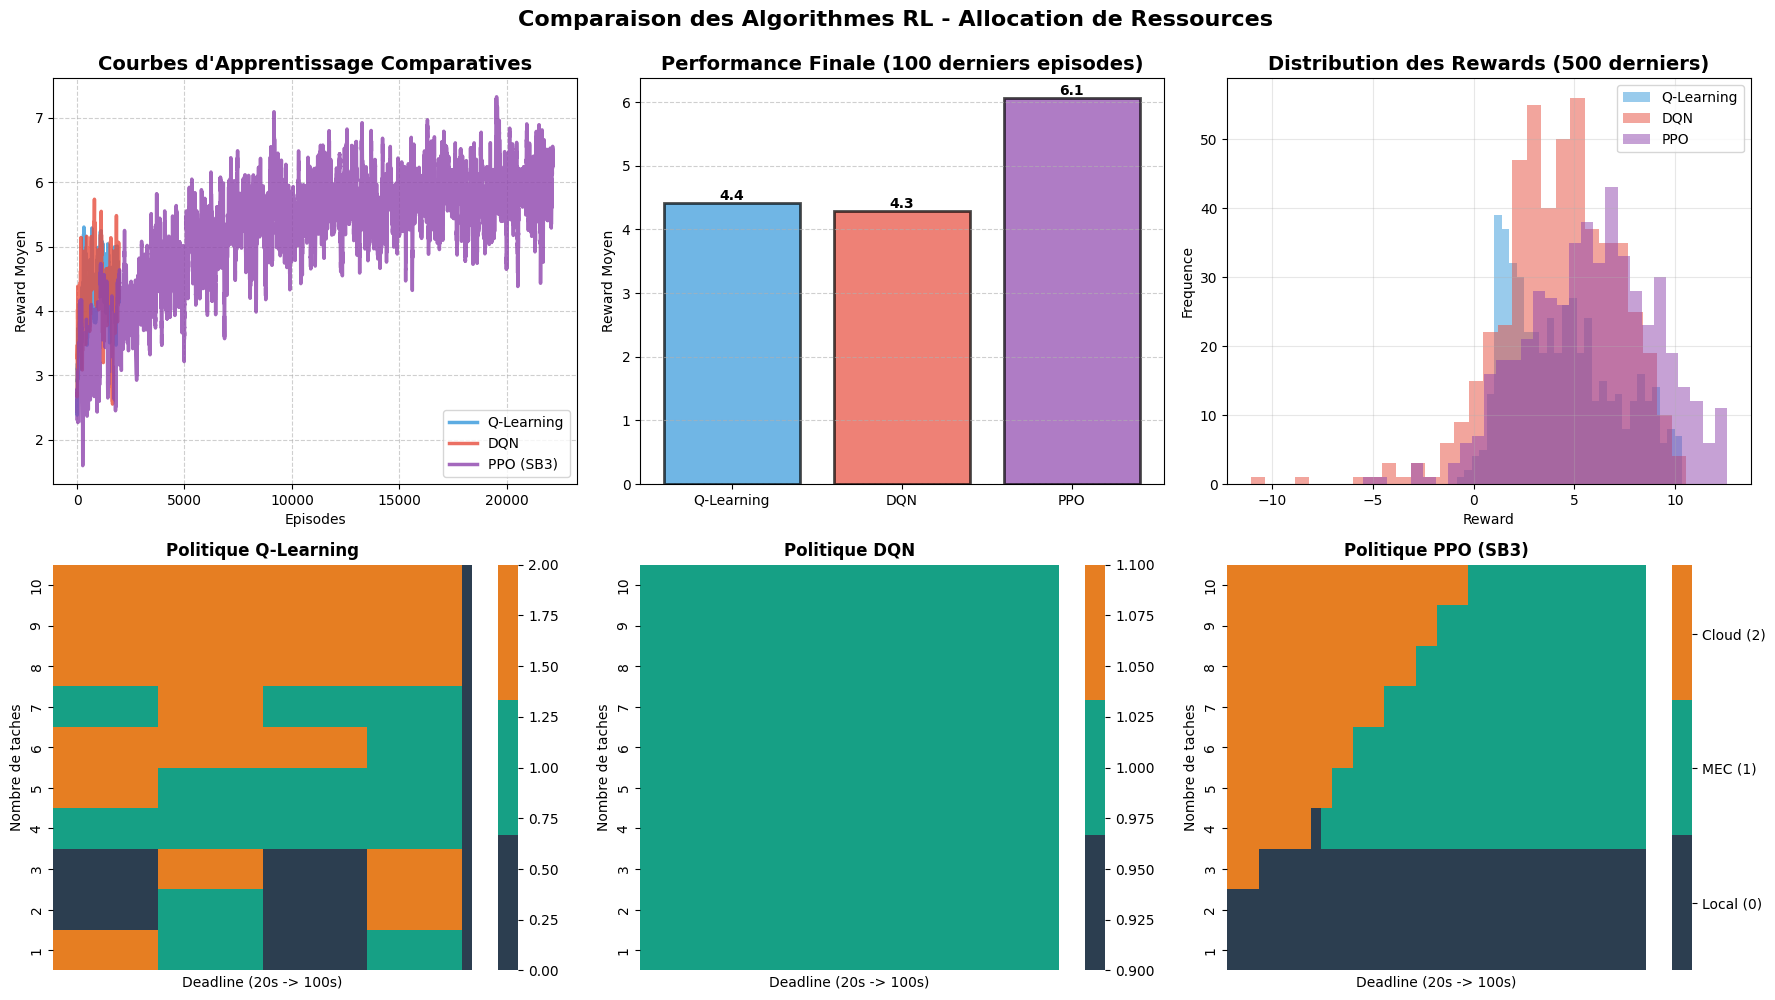


ENTRAINEMENT TERMINE!

Resultats finaux (100 derniers episodes):
  Q-Learning: 4.42
  DQN:        4.29
  PPO (SB3):  6.07



In [ ]:
"""
Système d'Allocation de Ressources par Apprentissage par Renforcement
Environnement: Gymnasium
Algorithmes: Q-Learning (custom), DQN (custom), PPO (Stable-Baselines3)
État: [nb_tasks, d_limit]
Actions: 0=Local (cap:3), 1=MEC (cap:7), 2=Cloud (illimité)
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque

# --- STABLE BASELINES 3 IMPORTS ---
from stable_baselines3 import PPO, DQN as SB3_DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env


# ==========================================
# 1. ENVIRONNEMENT GYMNASIUM
# ==========================================
class ResourceAllocationEnv(gym.Env):
    """
    Environnement d'allocation de ressources conforme à Gymnasium
    """
    metadata = {'render_modes': []}

    def __init__(self):
        super(ResourceAllocationEnv, self).__init__()

        # Capacités des ressources
        self.LOCAL_CAPACITY = 3
        self.MEC_CAPACITY = 7
        # Cloud a capacité illimitée

        # Paramètres de simulation
        self.MAX_TASKS = 10
        self.MAX_DELAY = 100
        self.max_steps_per_episode = 20

        # Espace d'actions: 0=Local, 1=MEC, 2=Cloud
        self.action_space = spaces.Discrete(3)

        # Espace d'observation: [nb_tasks, d_limit]
        self.observation_space = spaces.Box(
            low=np.array([1, 10], dtype=np.float32),
            high=np.array([self.MAX_TASKS, self.MAX_DELAY], dtype=np.float32),
            dtype=np.float32
        )

        # État interne
        self.nb_task = 0
        self.d_limit = 0
        self.steps_count = 0
        self.local_availability = 1.0
        self.mec_availability = 1.0

    def reset(self, seed=None, options=None):
        """Réinitialise l'environnement"""
        super().reset(seed=seed)

        self.steps_count = 0
        self.nb_task = random.randint(1, self.MAX_TASKS)
        self.d_limit = random.uniform(20.0, float(self.MAX_DELAY))

        # Variabilité de disponibilité (simule pannes, surcharge)
        self.local_availability = random.uniform(0.7, 1.0)
        self.mec_availability = random.uniform(0.8, 1.0)

        state = np.array([self.nb_task, self.d_limit], dtype=np.float32)
        return state, {}

    def step(self, action):
        """Exécute une action et retourne les résultats"""
        self.steps_count += 1

        # Simulation de latence et traitement
        network_delay = random.uniform(5, 20)
        processing_time = self.nb_task * random.uniform(2, 5)

        reward = 0
        success = False
        info = {'resource': ['Local', 'MEC', 'Cloud'][action]}

        # === ACTION 0: LOCAL ===
        if action == 0:
            if self.nb_task > self.LOCAL_CAPACITY:
                reward = -2.0  # Pénalité forte
                info['reason'] = 'Capacite insuffisante'
            elif random.random() > self.local_availability:
                reward = -1.0
                info['reason'] = 'Ressource indisponible'
            elif processing_time > self.d_limit:
                reward = -0.5
                info['reason'] = 'Delai depasse'
            else:
                # Succès! Bonus car pas de latence réseau
                time_saved = self.d_limit - processing_time
                reward = 3.0 + (time_saved / 10.0)
                success = True
                info['reason'] = 'Succes'

        # === ACTION 1: MEC ===
        elif action == 1:
            total_time = network_delay + processing_time

            if self.nb_task > self.MEC_CAPACITY:
                reward = -2.0
                info['reason'] = 'Capacite insuffisante'
            elif random.random() > self.mec_availability:
                reward = -1.0
                info['reason'] = 'Ressource indisponible'
            elif total_time > self.d_limit:
                reward = -0.5
                info['reason'] = 'Delai depasse'
            else:
                time_saved = self.d_limit - total_time
                reward = 2.0 + (time_saved / 10.0)
                success = True
                info['reason'] = 'Succes'

        # === ACTION 2: CLOUD ===
        else:
            total_time = network_delay * 2 + processing_time

            if total_time > self.d_limit:
                reward = -0.3
                info['reason'] = 'Delai depasse'
            else:
                # Cloud coûte cher, donc récompense plus faible
                time_saved = self.d_limit - total_time
                reward = 1.0 + (time_saved / 20.0)
                success = True
                info['reason'] = 'Succes (cout eleve)'

        # Si échec, on génère un nouvel état (nouvelle tentative)
        if not success:
            self.nb_task = random.randint(1, self.MAX_TASKS)
            self.d_limit = random.uniform(20.0, float(self.MAX_DELAY))
            self.local_availability = random.uniform(0.7, 1.0)
            self.mec_availability = random.uniform(0.8, 1.0)

        next_state = np.array([self.nb_task, self.d_limit], dtype=np.float32)
        terminated = success
        truncated = (self.steps_count >= self.max_steps_per_episode)

        info['success'] = success

        return next_state, reward, terminated, truncated, info


# ==========================================
# 2. Q-LEARNING CLASSIQUE
# ==========================================
class QLearningAgent:
    """Q-Learning avec table Q"""
    def __init__(self, n_actions=3):
        self.n_actions = n_actions
        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.995
        self.q_table = {}

    def _discretize_state(self, state):
        """Discrétise l'état pour utiliser une Q-table"""
        nb_task_bin = min(int(state[0]), 10)
        d_limit_bin = int(state[1] / 20)
        return (nb_task_bin, d_limit_bin)

    def get_q_values(self, state):
        state_key = self._discretize_state(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.get_q_values(state)
        return int(np.argmax(q_values))

    def update(self, state, action, reward, next_state, done):
        state_key = self._discretize_state(state)
        current_q = self.get_q_values(state)[action]

        if done:
            target = reward
        else:
            max_next_q = np.max(self.get_q_values(next_state))
            target = reward + self.gamma * max_next_q

        self.q_table[state_key][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


def train_qlearning(n_episodes=2000):
    """Entraîne Q-Learning"""
    env = ResourceAllocationEnv()
    agent = QLearningAgent()
    episode_rewards = []

    print("\n" + "="*60)
    print("ENTRAINEMENT Q-LEARNING")
    print("="*60)

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)

            agent.update(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode:4d} | Reward moyen: {avg_reward:7.2f} | Epsilon: {agent.epsilon:.3f}")

    print("Entrainement Q-Learning termine!")
    return agent, episode_rewards


# ==========================================
# 3. DQN CUSTOM (Simple)
# ==========================================
class SimpleDQN:
    """Deep Q-Network simplifié"""
    def __init__(self, state_dim=2, n_actions=3):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.lr = 0.001

        # Réseau de neurones simple
        self.w1 = np.random.randn(state_dim, 64) * 0.01
        self.b1 = np.zeros(64)
        self.w2 = np.random.randn(64, 32) * 0.01
        self.b2 = np.zeros(32)
        self.w3 = np.random.randn(32, n_actions) * 0.01
        self.b3 = np.zeros(n_actions)

        self.memory = deque(maxlen=5000)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.995

    def _relu(self, x):
        return np.maximum(0, x)

    def predict(self, state):
        """Forward pass"""
        x = state / np.array([10.0, 100.0])
        h1 = self._relu(np.dot(x, self.w1) + self.b1)
        h2 = self._relu(np.dot(h1, self.w2) + self.b2)
        q_values = np.dot(h2, self.w3) + self.b3
        return q_values

    def choose_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.predict(state)
        return int(np.argmax(q_values))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Apprentissage par mini-batch"""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in batch:
            target = reward if done else reward + self.gamma * np.max(self.predict(next_state))

            # Mise à jour simplifiée
            x = state / np.array([10.0, 100.0])
            h1 = self._relu(np.dot(x, self.w1) + self.b1)
            h2 = self._relu(np.dot(h1, self.w2) + self.b2)

            q_values = self.predict(state).copy()
            q_values[action] = target
            delta = (self.predict(state) - q_values) * 0.01

            self.w3 -= self.lr * np.outer(h2, delta)
            self.b3 -= self.lr * delta

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


def train_dqn(n_episodes=2000):
    """Entraîne DQN custom"""
    env = ResourceAllocationEnv()
    agent = SimpleDQN()
    episode_rewards = []

    print("\n" + "="*60)
    print("ENTRAINEMENT DQN (Custom)")
    print("="*60)

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            total_reward += reward
            state = next_state

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode:4d} | Reward moyen: {avg_reward:7.2f} | Epsilon: {agent.epsilon:.3f}")

    print("Entrainement DQN termine!")
    return agent, episode_rewards


# ==========================================
# 4. CALLBACK POUR PPO
# ==========================================
class ScoreLoggerCallback(BaseCallback):
    """Callback pour logger les récompenses des épisodes"""
    def __init__(self, verbose=0):
        super(ScoreLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True


# ==========================================
# 5. ENTRAINEMENT PPO (Stable-Baselines3)
# ==========================================
def train_ppo(total_timesteps=40000):
    """Entraîne PPO avec Stable-Baselines3"""
    print("\n" + "="*60)
    print("ENTRAINEMENT PPO (Stable-Baselines3)")
    print("="*60)

    # Environnement vectorisé
    env = make_vec_env(lambda: ResourceAllocationEnv(), n_envs=1)

    # Création du modèle PPO
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        gamma=0.99,
        batch_size=64,
        n_steps=2048
    )

    # Callback pour logger les scores
    callback = ScoreLoggerCallback()

    # Apprentissage
    model.learn(total_timesteps=total_timesteps, callback=callback)

    print("Entrainement PPO termine!")
    return model, callback.episode_rewards


# ==========================================
# 6. VISUALISATION COMPARATIVE
# ==========================================
def plot_comparison(q_rewards, dqn_rewards, ppo_rewards, q_agent, dqn_agent, ppo_model):
    """Visualisation comparative des 3 algorithmes"""
    fig = plt.figure(figsize=(18, 10))

    # --- COURBES D'APPRENTISSAGE ---
    ax1 = plt.subplot(2, 3, 1)
    window = 50

    # Q-Learning
    if len(q_rewards) > window:
        q_smooth = np.convolve(q_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(q_smooth, color='#3498db', linewidth=2.5, label='Q-Learning', alpha=0.8)

    # DQN
    if len(dqn_rewards) > window:
        dqn_smooth = np.convolve(dqn_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(dqn_smooth, color='#e74c3c', linewidth=2.5, label='DQN', alpha=0.8)

    # PPO
    if len(ppo_rewards) > window:
        ppo_smooth = np.convolve(ppo_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(ppo_smooth, color='#8e44ad', linewidth=2.5, label='PPO (SB3)', alpha=0.8)

    ax1.set_title("Courbes d'Apprentissage Comparatives", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward Moyen")
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- PERFORMANCE FINALE ---
    ax2 = plt.subplot(2, 3, 2)
    final_scores = [
        np.mean(q_rewards[-100:]) if len(q_rewards) >= 100 else np.mean(q_rewards),
        np.mean(dqn_rewards[-100:]) if len(dqn_rewards) >= 100 else np.mean(dqn_rewards),
        np.mean(ppo_rewards[-100:]) if len(ppo_rewards) >= 100 else np.mean(ppo_rewards)
    ]
    colors = ['#3498db', '#e74c3c', '#8e44ad']
    bars = ax2.bar(['Q-Learning', 'DQN', 'PPO'], final_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, score in zip(bars, final_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    ax2.set_title("Performance Finale (100 derniers episodes)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Reward Moyen")
    ax2.grid(True, axis='y', linestyle='--', alpha=0.6)

    # --- DISTRIBUTION REWARDS ---
    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(q_rewards[-500:], bins=30, alpha=0.5, color='#3498db', label='Q-Learning')
    ax3.hist(dqn_rewards[-500:], bins=30, alpha=0.5, color='#e74c3c', label='DQN')
    ax3.hist(ppo_rewards[-500:], bins=30, alpha=0.5, color='#8e44ad', label='PPO')
    ax3.set_title("Distribution des Rewards (500 derniers)", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Reward")
    ax3.set_ylabel("Frequence")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # --- HEATMAPS DES POLITIQUES ---
    nb_tasks_vals = np.arange(1, 11)
    deadline_vals = np.linspace(20, 100, 40)

    def get_policy_grid(agent, agent_type):
        grid = np.zeros((len(nb_tasks_vals), len(deadline_vals)))
        for i, tasks in enumerate(nb_tasks_vals):
            for j, deadline in enumerate(deadline_vals):
                state = np.array([tasks, deadline], dtype=np.float32)
                if agent_type == 'ppo':
                    action, _ = agent.predict(state.reshape(1, -1), deterministic=True)
                    grid[i, j] = action.item()
                else:
                    action = agent.choose_action(state, training=False)
                    grid[i, j] = action
        return grid

    # Q-Learning Heatmap
    ax4 = plt.subplot(2, 3, 4)
    q_grid = get_policy_grid(q_agent, 'qlearning')
    cmap = sns.color_palette(["#2c3e50", "#16a085", "#e67e22"], as_cmap=True)
    sns.heatmap(q_grid, cmap=cmap, cbar=True, ax=ax4, xticklabels=False, yticklabels=nb_tasks_vals)
    ax4.set_title("Politique Q-Learning", fontsize=12, fontweight='bold')
    ax4.set_xlabel("Deadline (20s -> 100s)")
    ax4.set_ylabel("Nombre de taches")
    ax4.invert_yaxis()

    # DQN Heatmap
    ax5 = plt.subplot(2, 3, 5)
    dqn_grid = get_policy_grid(dqn_agent, 'dqn')
    sns.heatmap(dqn_grid, cmap=cmap, cbar=True, ax=ax5, xticklabels=False, yticklabels=nb_tasks_vals)
    ax5.set_title("Politique DQN", fontsize=12, fontweight='bold')
    ax5.set_xlabel("Deadline (20s -> 100s)")
    ax5.set_ylabel("Nombre de taches")
    ax5.invert_yaxis()

    # PPO Heatmap
    ax6 = plt.subplot(2, 3, 6)
    ppo_grid = get_policy_grid(ppo_model, 'ppo')
    im = sns.heatmap(ppo_grid, cmap=cmap, cbar=True, ax=ax6, xticklabels=False, yticklabels=nb_tasks_vals)
    ax6.set_title("Politique PPO (SB3)", fontsize=12, fontweight='bold')
    ax6.set_xlabel("Deadline (20s -> 100s)")
    ax6.set_ylabel("Nombre de taches")
    ax6.invert_yaxis()

    # Légende de la heatmap
    cbar = im.collections[0].colorbar
    cbar.set_ticks([0.33, 1, 1.66])
    cbar.set_ticklabels(['Local (0)', 'MEC (1)', 'Cloud (2)'])

    plt.suptitle("Comparaison des Algorithmes RL - Allocation de Ressources",
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('rl_comparison_complete.png', dpi=300, bbox_inches='tight')
    print("\nGraphique sauvegarde: rl_comparison_complete.png")
    plt.show()


# ==========================================
# 7. MAIN
# ==========================================
if __name__ == "__main__":
    print("\n" + "="*70)
    print(" SYSTEME D'ALLOCATION DE RESSOURCES PAR APPRENTISSAGE PAR RENFORCEMENT")
    print("="*70)
    print("\nEnvironnement: Gymnasium")
    print("Algorithmes: Q-Learning (custom), DQN (custom), PPO (Stable-Baselines3)")
    print("="*70)

    # 1. Q-Learning
    q_agent, q_rewards = train_qlearning(n_episodes=2000)

    # 2. DQN
    dqn_agent, dqn_rewards = train_dqn(n_episodes=2000)

    # 3. PPO (Stable-Baselines3)
    ppo_model, ppo_rewards = train_ppo(total_timesteps=40000)

    # 4. Visualisation comparative
    plot_comparison(q_rewards, dqn_rewards, ppo_rewards, q_agent, dqn_agent, ppo_model)

    print("\n" + "="*70)
    print("ENTRAINEMENT TERMINE!")
    print("="*70)
    print("\nResultats finaux (100 derniers episodes):")
    print(f"  Q-Learning: {np.mean(q_rewards[-100:]):.2f}")
    print(f"  DQN:        {np.mean(dqn_rewards[-100:]):.2f}")
    print(f"  PPO (SB3):  {np.mean(ppo_rewards[-100:]):.2f}")
    print("="*70 + "\n")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


--- Démarrage PPO avec Stable-Baselines3 ---
Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    fps             | 712      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -29.4       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013660265 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000488   |
|    learning_rate        | 0.

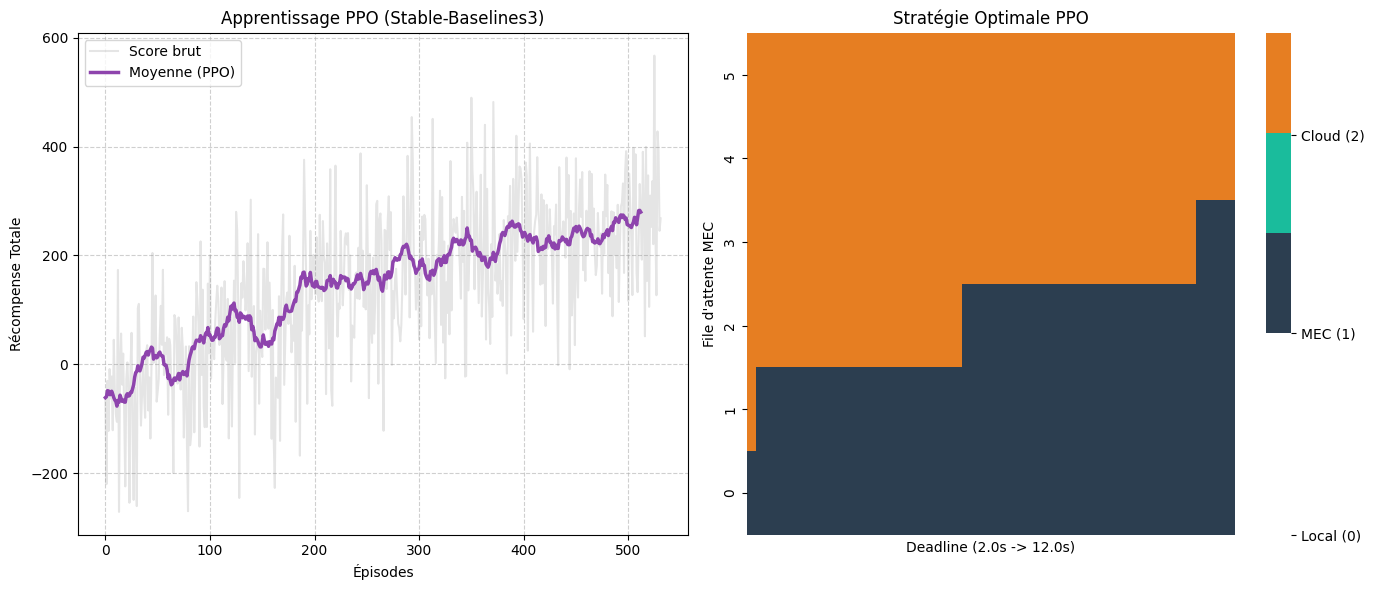

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- STABLE BASELINES 3 IMPORTS ---
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env

# ==========================================
# 1. L'ENVIRONNEMENT (Toujours le même)
# ==========================================
class OffloadingGymEnv(gym.Env):
    def __init__(self):
        super(OffloadingGymEnv, self).__init__()
        self.SPEED_LOCAL = 1.0
        self.SPEED_MEC = 4.0
        self.SPEED_CLOUD = 15.0
        self.LATENCY_MEC = 1.5
        self.LATENCY_CLOUD = 5.0
        self.TASK_SIZE = 10.0
        self.MAX_QUEUE = 5

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([self.MAX_QUEUE, 20.0], dtype=np.float32),
            dtype=np.float32
        )
        self.max_steps_per_episode = 50

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps_count = 0
        self.current_queue = random.randint(0, self.MAX_QUEUE)
        self.current_deadline = random.uniform(2.0, 12.0)
        return np.array([self.current_queue, self.current_deadline], dtype=np.float32), {}

    def step(self, action):
        self.steps_count += 1
        proc_time, wait_time, transmission_time = 0, 0, 0
        penalty_queue_full = False

        if action == 0: # LOCAL
            proc_time = self.TASK_SIZE / self.SPEED_LOCAL
        elif action == 1: # MEC
            if self.current_queue >= self.MAX_QUEUE:
                penalty_queue_full = True
            else:
                proc_time = self.TASK_SIZE / self.SPEED_MEC
                wait_time = self.current_queue * 0.5
                transmission_time = self.LATENCY_MEC
        elif action == 2: # CLOUD
            proc_time = self.TASK_SIZE / self.SPEED_CLOUD
            transmission_time = self.LATENCY_CLOUD

        total_time = proc_time + wait_time + transmission_time

        # --- REWARD SHAPING ---
        if penalty_queue_full:
            reward = -20.0
        elif total_time <= self.current_deadline:
            time_saved = self.current_deadline - total_time
            reward = 10.0 + time_saved
        else:
            time_wasted = total_time - self.current_deadline
            reward = -10.0 - time_wasted

        change = random.choice([-1, 0, 1])
        self.current_queue = max(0, min(self.MAX_QUEUE, self.current_queue + change))
        self.current_deadline = random.uniform(2.0, 12.0)

        next_state = np.array([self.current_queue, self.current_deadline], dtype=np.float32)
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return next_state, reward, False, truncated, {}

# ==========================================
# 2. CALLBACK POUR LOGGUER LES SCORES
# ==========================================
# SB3 ne retourne pas une liste de rewards par défaut, il faut un "Callback"
class ScoreLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ScoreLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        # On récupère le reward du pas de temps actuel
        # 'infos' contient les infos de fin d'épisode si disponible
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        # 'dones' indique si l'épisode est fini
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

# ==========================================
# 3. ENTRAÎNEMENT PPO
# ==========================================
print("--- Démarrage PPO avec Stable-Baselines3 ---")

# 1. Création de l'environnement vectorisé (Recommandé pour PPO)
env = make_vec_env(lambda: OffloadingGymEnv(), n_envs=1)

# 2. Création du modèle
# MlpPolicy = Réseau de neurones dense classique (pas de convolution car pas d'image)
model = PPO("MlpPolicy", env, verbose=1,
            learning_rate=0.0003,
            gamma=0.99,
            batch_size=64)

# 3. Instanciation du Logger
callback = ScoreLoggerCallback()

# 4. Apprentissage (C'est là que la magie opère en 1 ligne)
# 25 000 steps correspond environ à 500 épisodes de 50 steps
model.learn(total_timesteps=25000, callback=callback)

print("Entraînement terminé.")

# ==========================================
# 4. VISUALISATION
# ==========================================
plt.figure(figsize=(14, 6))

# --- A. COURBE D'APPRENTISSAGE ---
scores = callback.episode_rewards
plt.subplot(1, 2, 1)
plt.plot(scores, alpha=0.2, color='gray', label='Score brut')
if len(scores) > 20:
    moving_avg = np.convolve(scores, np.ones(20)/20, mode='valid')
    plt.plot(moving_avg, color='#8e44ad', linewidth=2.5, label='Moyenne (PPO)') # Violet PPO
plt.title("Apprentissage PPO (Stable-Baselines3)")
plt.xlabel("Épisodes")
plt.ylabel("Récompense Totale")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- B. MATRICE DE DÉCISION (HEATMAP) ---
plt.subplot(1, 2, 2)
queue_vals = np.arange(6)
deadline_vals = np.linspace(2.0, 12.0, 50)
policy_grid = np.zeros((len(queue_vals), len(deadline_vals)))

# On désactive le gradient pour la prédiction (plus rapide)
for i, q in enumerate(queue_vals):
    for j, d in enumerate(deadline_vals):
        # SB3 attend une observation de forme (1, n_features) pour prédire
        obs = np.array([[q, d]], dtype=np.float32)
        # deterministic=True force l'IA à prendre la meilleure action (sans aléatoire)
        action, _ = model.predict(obs, deterministic=True)
        policy_grid[i, j] = action.item()

cmap = sns.color_palette(["#2c3e50", "#1abc9c", "#e67e22"]) # Bleu, Vert, Orange
ax = sns.heatmap(policy_grid, cmap=cmap, cbar=True,
                 xticklabels=False, yticklabels=queue_vals)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.66])
cbar.set_ticklabels(['Local (0)', 'MEC (1)', 'Cloud (2)'])

plt.title("Stratégie Optimale PPO")
plt.xlabel("Deadline (2.0s -> 12.0s)")
plt.ylabel("File d'attente MEC")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


 SYSTEME D'ALLOCATION DE RESSOURCES - VERSION AMELIOREE

Ameliorations DQN:
  ✓ Target Network (mise a jour tous les 100 steps)
  ✓ Double DQN (selection + evaluation separees)
  ✓ Architecture plus profonde (128-128-64)
  ✓ Batch Normalization + Dropout
  ✓ Huber Loss (plus stable que MSE)
  ✓ Gradient Clipping
  ✓ Buffer size 10000 avec batch 64

ENTRAINEMENT Q-LEARNING
Episode    0 | Reward:    3.66 | Epsilon: 0.995
Episode  200 | Reward:    3.92 | Epsilon: 0.365
Episode  400 | Reward:    4.81 | Epsilon: 0.134
Episode  600 | Reward:    4.93 | Epsilon: 0.049
Episode  800 | Reward:    5.13 | Epsilon: 0.018
Episode 1000 | Reward:    5.28 | Epsilon: 0.010
Episode 1200 | Reward:    4.76 | Epsilon: 0.010
Episode 1400 | Reward:    4.28 | Epsilon: 0.010
Episode 1600 | Reward:    4.88 | Epsilon: 0.010
Episode 1800 | Reward:    4.85 | Epsilon: 0.010
Entrainement Q-Learning termine!

ENTRAINEMENT DQN AMELIORE (Target Network + Double DQN)
Device: cuda
Episode    0 | Reward:    0.28 | Epsilon:

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.96     |
|    ep_rew_mean     | 2.83     |
| time/              |          |
|    fps             | 799      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.96        |
|    ep_rew_mean          | 4.3         |
| time/                   |             |
|    fps                  | 628         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.021771772 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.0271      |
|    learning_rate        | 0.

/tmp/ipython-input-416932165.py:497: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_to_plot, labels=['Q-Learning', 'DQN', 'PPO'],
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Graphique sauvegarde: rl_comparison_improved.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


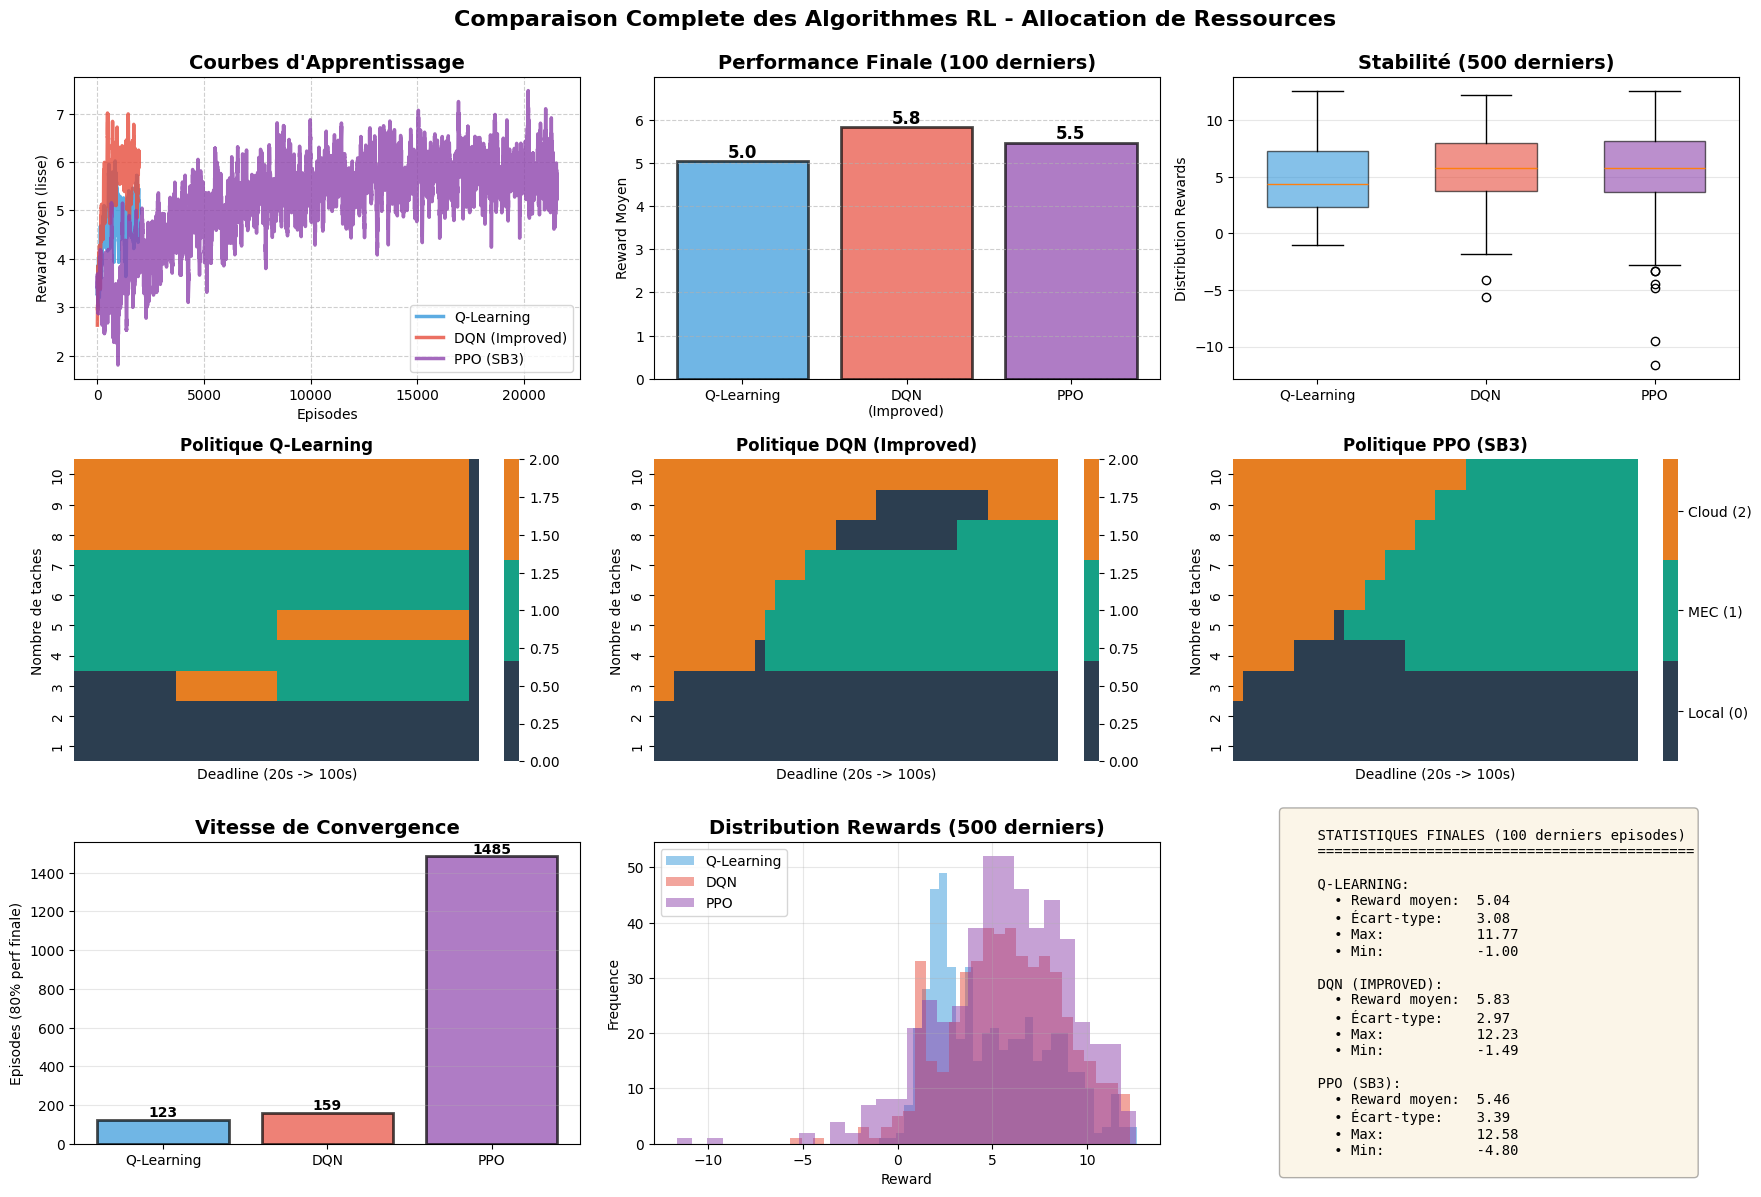


ENTRAINEMENT TERMINE!

Resultats finaux (100 derniers episodes):
  Q-Learning: 5.04
  DQN:        5.83
  PPO (SB3):  5.46



In [ ]:
"""
Système d'Allocation de Ressources par Apprentissage par Renforcement
Version AMELIOREE avec DQN professionnel (Target Network + Double DQN)

Environnement: Gymnasium
Algorithmes: Q-Learning, DQN (PyTorch), PPO (Stable-Baselines3)
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque

# PyTorch pour un vrai DQN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Stable Baselines 3
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env


# ==========================================
# 1. ENVIRONNEMENT GYMNASIUM
# ==========================================
class ResourceAllocationEnv(gym.Env):
    """Environnement d'allocation de ressources"""
    metadata = {'render_modes': []}

    def __init__(self):
        super(ResourceAllocationEnv, self).__init__()

        self.LOCAL_CAPACITY = 3
        self.MEC_CAPACITY = 7
        self.MAX_TASKS = 10
        self.MAX_DELAY = 100
        self.max_steps_per_episode = 20

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([1, 10], dtype=np.float32),
            high=np.array([self.MAX_TASKS, self.MAX_DELAY], dtype=np.float32),
            dtype=np.float32
        )

        self.nb_task = 0
        self.d_limit = 0
        self.steps_count = 0
        self.local_availability = 1.0
        self.mec_availability = 1.0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps_count = 0
        self.nb_task = random.randint(1, self.MAX_TASKS)
        self.d_limit = random.uniform(20.0, float(self.MAX_DELAY))
        self.local_availability = random.uniform(0.7, 1.0)
        self.mec_availability = random.uniform(0.8, 1.0)

        state = np.array([self.nb_task, self.d_limit], dtype=np.float32)
        return state, {}

    def step(self, action):
        self.steps_count += 1

        network_delay = random.uniform(5, 20)
        processing_time = self.nb_task * random.uniform(2, 5)

        reward = 0
        success = False
        info = {'resource': ['Local', 'MEC', 'Cloud'][action]}

        if action == 0:  # LOCAL
            if self.nb_task > self.LOCAL_CAPACITY:
                reward = -2.0
                info['reason'] = 'Capacite insuffisante'
            elif random.random() > self.local_availability:
                reward = -1.0
                info['reason'] = 'Ressource indisponible'
            elif processing_time > self.d_limit:
                reward = -0.5
                info['reason'] = 'Delai depasse'
            else:
                time_saved = self.d_limit - processing_time
                reward = 3.0 + (time_saved / 10.0)
                success = True
                info['reason'] = 'Succes'

        elif action == 1:  # MEC
            total_time = network_delay + processing_time

            if self.nb_task > self.MEC_CAPACITY:
                reward = -2.0
                info['reason'] = 'Capacite insuffisante'
            elif random.random() > self.mec_availability:
                reward = -1.0
                info['reason'] = 'Ressource indisponible'
            elif total_time > self.d_limit:
                reward = -0.5
                info['reason'] = 'Delai depasse'
            else:
                time_saved = self.d_limit - total_time
                reward = 2.0 + (time_saved / 10.0)
                success = True
                info['reason'] = 'Succes'

        else:  # CLOUD
            total_time = network_delay * 2 + processing_time

            if total_time > self.d_limit:
                reward = -0.3
                info['reason'] = 'Delai depasse'
            else:
                time_saved = self.d_limit - total_time
                reward = 1.0 + (time_saved / 20.0)
                success = True
                info['reason'] = 'Succes (cout eleve)'

        if not success:
            self.nb_task = random.randint(1, self.MAX_TASKS)
            self.d_limit = random.uniform(20.0, float(self.MAX_DELAY))
            self.local_availability = random.uniform(0.7, 1.0)
            self.mec_availability = random.uniform(0.8, 1.0)

        next_state = np.array([self.nb_task, self.d_limit], dtype=np.float32)
        terminated = success
        truncated = (self.steps_count >= self.max_steps_per_episode)
        info['success'] = success

        return next_state, reward, terminated, truncated, info


# ==========================================
# 2. Q-LEARNING CLASSIQUE
# ==========================================
class QLearningAgent:
    """Q-Learning avec table Q"""
    def __init__(self, n_actions=3):
        self.n_actions = n_actions
        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.995
        self.q_table = {}

    def _discretize_state(self, state):
        nb_task_bin = min(int(state[0]), 10)
        d_limit_bin = int(state[1] / 20)
        return (nb_task_bin, d_limit_bin)

    def get_q_values(self, state):
        state_key = self._discretize_state(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.get_q_values(state)
        return int(np.argmax(q_values))

    def update(self, state, action, reward, next_state, done):
        state_key = self._discretize_state(state)
        current_q = self.get_q_values(state)[action]

        if done:
            target = reward
        else:
            max_next_q = np.max(self.get_q_values(next_state))
            target = reward + self.gamma * max_next_q

        self.q_table[state_key][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


def train_qlearning(n_episodes=2000):
    """Entraîne Q-Learning"""
    env = ResourceAllocationEnv()
    agent = QLearningAgent()
    episode_rewards = []

    print("\n" + "="*60)
    print("ENTRAINEMENT Q-LEARNING")
    print("="*60)

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)
            agent.update(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Epsilon: {agent.epsilon:.3f}")

    print("Entrainement Q-Learning termine!")
    return agent, episode_rewards


# ==========================================
# 3. DQN PROFESSIONNEL (PyTorch)
# ==========================================
class DQNNetwork(nn.Module):
    """Réseau de neurones pour DQN - Architecture améliorée"""
    def __init__(self, state_dim=2, n_actions=3):
        super(DQNNetwork, self).__init__()

        # Architecture plus profonde avec BatchNorm
        self.fc1 = nn.Linear(state_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, n_actions)

        # Dropout pour régularisation
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Normalisation de l'entrée
        x = x / torch.tensor([10.0, 100.0], device=x.device)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


class ImprovedDQNAgent:
    """DQN avec Target Network et Double DQN"""
    def __init__(self, state_dim=2, n_actions=3):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Réseaux Q et Target
        self.q_network = DQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network = DQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Le réseau Target est toujours en eval (on ne l'entraîne pas directement)
        self.target_network.eval()
        # Le réseau Q commence en mode train
        self.q_network.train()

        # Optimiseur
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

        # Replay Buffer
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99

        # Exploration
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.995

        # Target network update
        self.target_update_freq = 100
        self.steps = 0
        self.update_counter = 0

    def choose_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)

        # --- CORRECTION ICI ---
        # 1. On passe en mode EVAL pour gérer le batch de taille 1 (BatchNorm)
        self.q_network.eval()

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            action = int(q_values.argmax().item())

        # 2. On repasse en mode TRAIN pour les futures mises à jour de poids
        self.q_network.train()
        # ----------------------

        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Apprentissage avec vrai backpropagation"""
        if len(self.memory) < self.batch_size:
            return

        # S'assurer qu'on est en mode train
        self.q_network.train()

        # Sample mini-batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Conversion en tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Q-values actuelles
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Double DQN
        with torch.no_grad():
            # Pour l'action suivante, on utilise q_network (qui doit être en mode eval ici aussi idéalement,
            # mais comme batch_size > 1, le mode train passe pour BatchNorm)
            # Pour plus de rigueur mathématique sur BatchNorm, on peut mettre eval() ici,
            # mais c'est moins critique car le batch est grand (64).
            next_actions = self.q_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Huber Loss
        loss = F.smooth_l1_loss(current_q_values.squeeze(), target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Mise à jour du Target Network
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


def train_improved_dqn(n_episodes=2000):
    """Entraîne le DQN amélioré"""
    env = ResourceAllocationEnv()
    agent = ImprovedDQNAgent()
    episode_rewards = []

    print("\n" + "="*60)
    print("ENTRAINEMENT DQN AMELIORE (Target Network + Double DQN)")
    print("="*60)
    print(f"Device: {agent.device}")

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            total_reward += reward
            state = next_state

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Epsilon: {agent.epsilon:.3f} | Buffer: {len(agent.memory)}")

    print("Entrainement DQN ameliore termine!")
    return agent, episode_rewards


# ==========================================
# 4. PPO CALLBACK
# ==========================================
class ScoreLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ScoreLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True


# ==========================================
# 5. ENTRAINEMENT PPO
# ==========================================
def train_ppo(total_timesteps=40000):
    print("\n" + "="*60)
    print("ENTRAINEMENT PPO (Stable-Baselines3)")
    print("="*60)

    env = make_vec_env(lambda: ResourceAllocationEnv(), n_envs=1)

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        gamma=0.99,
        batch_size=64,
        n_steps=2048
    )

    callback = ScoreLoggerCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    print("Entrainement PPO termine!")
    return model, callback.episode_rewards


# ==========================================
# 6. VISUALISATION AMELIOREE
# ==========================================
def plot_comparison(q_rewards, dqn_rewards, ppo_rewards, q_agent, dqn_agent, ppo_model):
    """Visualisation comparative complète"""
    fig = plt.figure(figsize=(18, 12))

    # --- 1. COURBES D'APPRENTISSAGE ---
    ax1 = plt.subplot(3, 3, 1)
    window = 50

    if len(q_rewards) > window:
        q_smooth = np.convolve(q_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(q_smooth, color='#3498db', linewidth=2.5, label='Q-Learning', alpha=0.8)

    if len(dqn_rewards) > window:
        dqn_smooth = np.convolve(dqn_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(dqn_smooth, color='#e74c3c', linewidth=2.5, label='DQN (Improved)', alpha=0.8)

    if len(ppo_rewards) > window:
        ppo_smooth = np.convolve(ppo_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(ppo_smooth, color='#8e44ad', linewidth=2.5, label='PPO (SB3)', alpha=0.8)

    ax1.set_title("Courbes d'Apprentissage", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward Moyen (lisse)")
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- 2. PERFORMANCE FINALE ---
    ax2 = plt.subplot(3, 3, 2)
    final_scores = [
        np.mean(q_rewards[-100:]),
        np.mean(dqn_rewards[-100:]),
        np.mean(ppo_rewards[-100:])
    ]
    colors = ['#3498db', '#e74c3c', '#8e44ad']
    bars = ax2.bar(['Q-Learning', 'DQN\n(Improved)', 'PPO'], final_scores,
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, score in zip(bars, final_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    ax2.set_title("Performance Finale (100 derniers)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Reward Moyen")
    ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax2.set_ylim([0, max(final_scores) * 1.2])

    # --- 3. VARIANCE DES REWARDS ---
    ax3 = plt.subplot(3, 3, 3)
    data_to_plot = [q_rewards[-500:], dqn_rewards[-500:], ppo_rewards[-500:]]
    bp = ax3.boxplot(data_to_plot, labels=['Q-Learning', 'DQN', 'PPO'],
                     patch_artist=True, widths=0.6)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax3.set_title("Stabilité (500 derniers)", fontsize=14, fontweight='bold')
    ax3.set_ylabel("Distribution Rewards")
    ax3.grid(True, axis='y', alpha=0.3)

    # --- 4-6. HEATMAPS DES POLITIQUES ---
    nb_tasks_vals = np.arange(1, 11)
    deadline_vals = np.linspace(20, 100, 40)

    def get_policy_grid(agent, agent_type):
        grid = np.zeros((len(nb_tasks_vals), len(deadline_vals)))
        for i, tasks in enumerate(nb_tasks_vals):
            for j, deadline in enumerate(deadline_vals):
                state = np.array([tasks, deadline], dtype=np.float32)
                if agent_type == 'ppo':
                    action, _ = agent.predict(state.reshape(1, -1), deterministic=True)
                    grid[i, j] = action.item()
                elif agent_type == 'dqn':
                    action = agent.choose_action(state, training=False)
                    grid[i, j] = action
                else:
                    action = agent.choose_action(state, training=False)
                    grid[i, j] = action
        return grid

    cmap = sns.color_palette(["#2c3e50", "#16a085", "#e67e22"], as_cmap=True)

    # Q-Learning
    ax4 = plt.subplot(3, 3, 4)
    q_grid = get_policy_grid(q_agent, 'qlearning')
    sns.heatmap(q_grid, cmap=cmap, cbar=True, ax=ax4,
                xticklabels=False, yticklabels=nb_tasks_vals)
    ax4.set_title("Politique Q-Learning", fontsize=12, fontweight='bold')
    ax4.set_xlabel("Deadline (20s -> 100s)")
    ax4.set_ylabel("Nombre de taches")
    ax4.invert_yaxis()

    # DQN
    ax5 = plt.subplot(3, 3, 5)
    dqn_grid = get_policy_grid(dqn_agent, 'dqn')
    sns.heatmap(dqn_grid, cmap=cmap, cbar=True, ax=ax5,
                xticklabels=False, yticklabels=nb_tasks_vals)
    ax5.set_title("Politique DQN (Improved)", fontsize=12, fontweight='bold')
    ax5.set_xlabel("Deadline (20s -> 100s)")
    ax5.set_ylabel("Nombre de taches")
    ax5.invert_yaxis()

    # PPO
    ax6 = plt.subplot(3, 3, 6)
    ppo_grid = get_policy_grid(ppo_model, 'ppo')
    im = sns.heatmap(ppo_grid, cmap=cmap, cbar=True, ax=ax6,
                     xticklabels=False, yticklabels=nb_tasks_vals)
    ax6.set_title("Politique PPO (SB3)", fontsize=12, fontweight='bold')
    ax6.set_xlabel("Deadline (20s -> 100s)")
    ax6.set_ylabel("Nombre de taches")
    ax6.invert_yaxis()

    cbar = im.collections[0].colorbar
    cbar.set_ticks([0.33, 1, 1.66])
    cbar.set_ticklabels(['Local (0)', 'MEC (1)', 'Cloud (2)'])

    # --- 7. CONVERGENCE SPEED ---
    ax7 = plt.subplot(3, 3, 7)

    def get_convergence_episode(rewards, threshold=0.8):
        """Trouve l'épisode où l'agent atteint 80% de sa perf finale"""
        final_perf = np.mean(rewards[-100:])
        target = final_perf * threshold

        window = 100
        for i in range(len(rewards) - window):
            if np.mean(rewards[i:i+window]) >= target:
                return i
        return len(rewards)

    conv_episodes = [
        get_convergence_episode(q_rewards),
        get_convergence_episode(dqn_rewards),
        get_convergence_episode(ppo_rewards)
    ]

    bars = ax7.bar(['Q-Learning', 'DQN', 'PPO'], conv_episodes,
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, ep in zip(bars, conv_episodes):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{ep}', ha='center', va='bottom', fontweight='bold')

    ax7.set_title("Vitesse de Convergence", fontsize=14, fontweight='bold')
    ax7.set_ylabel("Episodes (80% perf finale)")
    ax7.grid(True, axis='y', alpha=0.3)

    # --- 8. DISTRIBUTION REWARDS FINALE ---
    ax8 = plt.subplot(3, 3, 8)
    ax8.hist(q_rewards[-500:], bins=30, alpha=0.5, color='#3498db', label='Q-Learning')
    ax8.hist(dqn_rewards[-500:], bins=30, alpha=0.5, color='#e74c3c', label='DQN')
    ax8.hist(ppo_rewards[-500:], bins=30, alpha=0.5, color='#8e44ad', label='PPO')
    ax8.set_title("Distribution Rewards (500 derniers)", fontsize=14, fontweight='bold')
    ax8.set_xlabel("Reward")
    ax8.set_ylabel("Frequence")
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # --- 9. STATISTIQUES ---
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    stats_text = f"""
    STATISTIQUES FINALES (100 derniers episodes)
    {'='*45}

    Q-LEARNING:
      • Reward moyen:  {np.mean(q_rewards[-100:]):.2f}
      • Écart-type:    {np.std(q_rewards[-100:]):.2f}
      • Max:           {np.max(q_rewards[-100:]):.2f}
      • Min:           {np.min(q_rewards[-100:]):.2f}

    DQN (IMPROVED):
      • Reward moyen:  {np.mean(dqn_rewards[-100:]):.2f}
      • Écart-type:    {np.std(dqn_rewards[-100:]):.2f}
      • Max:           {np.max(dqn_rewards[-100:]):.2f}
      • Min:           {np.min(dqn_rewards[-100:]):.2f}

    PPO (SB3):
      • Reward moyen:  {np.mean(ppo_rewards[-100:]):.2f}
      • Écart-type:    {np.std(ppo_rewards[-100:]):.2f}
      • Max:           {np.max(ppo_rewards[-100:]):.2f}
      • Min:           {np.min(ppo_rewards[-100:]):.2f}
    """

    ax9.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round',
             facecolor='wheat', alpha=0.3))

    plt.suptitle("Comparaison Complete des Algorithmes RL - Allocation de Ressources",
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('rl_comparison_improved.png', dpi=300, bbox_inches='tight')
    print("\nGraphique sauvegarde: rl_comparison_improved.png")
    plt.show()


# ==========================================
# 7. MAIN
# ==========================================
if __name__ == "__main__":
    print("\n" + "="*70)
    print(" SYSTEME D'ALLOCATION DE RESSOURCES - VERSION AMELIOREE")
    print("="*70)
    print("\nAmeliorations DQN:")
    print("  ✓ Target Network (mise a jour tous les 100 steps)")
    print("  ✓ Double DQN (selection + evaluation separees)")
    print("  ✓ Architecture plus profonde (128-128-64)")
    print("  ✓ Batch Normalization + Dropout")
    print("  ✓ Huber Loss (plus stable que MSE)")
    print("  ✓ Gradient Clipping")
    print("  ✓ Buffer size 10000 avec batch 64")
    print("="*70)

    # 1. Q-Learning
    q_agent, q_rewards = train_qlearning(n_episodes=2000)

    # 2. DQN Amélioré
    dqn_agent, dqn_rewards = train_improved_dqn(n_episodes=2000)

    # 3. PPO (Stable-Baselines3)
    ppo_model, ppo_rewards = train_ppo(total_timesteps=40000)

    # 4. Visualisation comparative
    plot_comparison(q_rewards, dqn_rewards, ppo_rewards, q_agent, dqn_agent, ppo_model)

    print("\n" + "="*70)
    print("ENTRAINEMENT TERMINE!")
    print("="*70)
    print("\nResultats finaux (100 derniers episodes):")
    print(f"  Q-Learning: {np.mean(q_rewards[-100:]):.2f}")
    print(f"  DQN:        {np.mean(dqn_rewards[-100:]):.2f}")
    print(f"  PPO (SB3):  {np.mean(ppo_rewards[-100:]):.2f}")
    print("="*70 + "\n")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



 SYSTÈME D'ALLOCATION DE RESSOURCES POUR SMART CITY
 Projet de Fin d'Études - École d'Ingénieur

📊 ARCHITECTURE:
  • 5 Quartiers avec infrastructure MEC dédiée
  • 100 Utilisateurs (IoT, Véhicules, AR/VR, Mobile, Industriel)
  • 3 Niveaux: Edge (Local) - Fog (MEC) - Cloud
  • 8 Actions possibles d'allocation

🎯 OBJECTIFS:
  • Minimiser la latence
  • Optimiser la consommation énergétique
  • Respecter les contraintes QoS
  • Maximiser le taux de succès

🤖 ALGORITHMES:
  • Q-Learning (Tabular)
  • Double DQN (Deep RL)
  • PPO (Policy Gradient)


🔵 Phase 1/3: Q-Learning

ENTRAÎNEMENT Q-LEARNING - SMART CITY
Episode    0 | Reward: 4490.15 | Success:  75.0% | Epsilon: 1.000 | States: 85


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward: 4939.75 | Success:  78.7% | Epsilon: 0.904 | States: 154
Episode  400 | Reward: 5030.31 | Success:  79.2% | Epsilon: 0.818 | States: 154
Episode  600 | Reward: 5174.77 | Success:  80.2% | Epsilon: 0.740 | States: 154
Episode  800 | Reward: 5249.72 | Success:  80.6% | Epsilon: 0.670 | States: 154
Episode 1000 | Reward: 5333.43 | Success:  81.2% | Epsilon: 0.606 | States: 154
Episode 1200 | Reward: 5407.05 | Success:  81.8% | Epsilon: 0.548 | States: 154
Episode 1400 | Reward: 5448.17 | Success:  81.9% | Epsilon: 0.496 | States: 154
Episode 1600 | Reward: 5540.41 | Success:  82.4% | Epsilon: 0.449 | States: 154
Episode 1800 | Reward: 5548.52 | Success:  82.5% | Epsilon: 0.406 | States: 154
Episode 2000 | Reward: 5635.38 | Success:  82.8% | Epsilon: 0.368 | States: 154
Episode 2200 | Reward: 5695.29 | Success:  83.3% | Epsilon: 0.333 | States: 154
Episode 2400 | Reward: 5739.82 | Success:  83.5% | Epsilon: 0.301 | States: 154
Episode 2600 | Reward: 5819.92 | Success

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward: 4974.12 | Success:  78.9% | Epsilon: 0.904 | Buffer: 50000
Episode  400 | Reward: 5113.89 | Success:  79.7% | Epsilon: 0.818 | Buffer: 50000
Episode  600 | Reward: 5199.23 | Success:  80.1% | Epsilon: 0.740 | Buffer: 50000
Episode  800 | Reward: 5408.68 | Success:  81.5% | Epsilon: 0.670 | Buffer: 50000
Episode 1000 | Reward: 5431.57 | Success:  81.4% | Epsilon: 0.606 | Buffer: 50000
Episode 1200 | Reward: 5509.24 | Success:  81.9% | Epsilon: 0.548 | Buffer: 50000
Episode 1400 | Reward: 5584.30 | Success:  82.1% | Epsilon: 0.496 | Buffer: 50000
Episode 1600 | Reward: 5601.23 | Success:  82.2% | Epsilon: 0.449 | Buffer: 50000
Episode 1800 | Reward: 5781.31 | Success:  83.4% | Epsilon: 0.406 | Buffer: 50000
Episode 2000 | Reward: 5896.07 | Success:  84.2% | Epsilon: 0.368 | Buffer: 50000
Episode 2200 | Reward: 5898.80 | Success:  84.1% | Epsilon: 0.333 | Buffer: 50000
Episode 2400 | Reward: 5901.58 | Success:  84.0% | Epsilon: 0.301 | Buffer: 50000
Episode 2600 | R

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 4.74e+03 |
| time/              |          |
|    fps             | 574      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 4.58e+03    |
| time/                   |             |
|    fps                  | 514         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009931335 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.000822    |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✓ Graphique sauvegardé: smartcity_rl_results.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


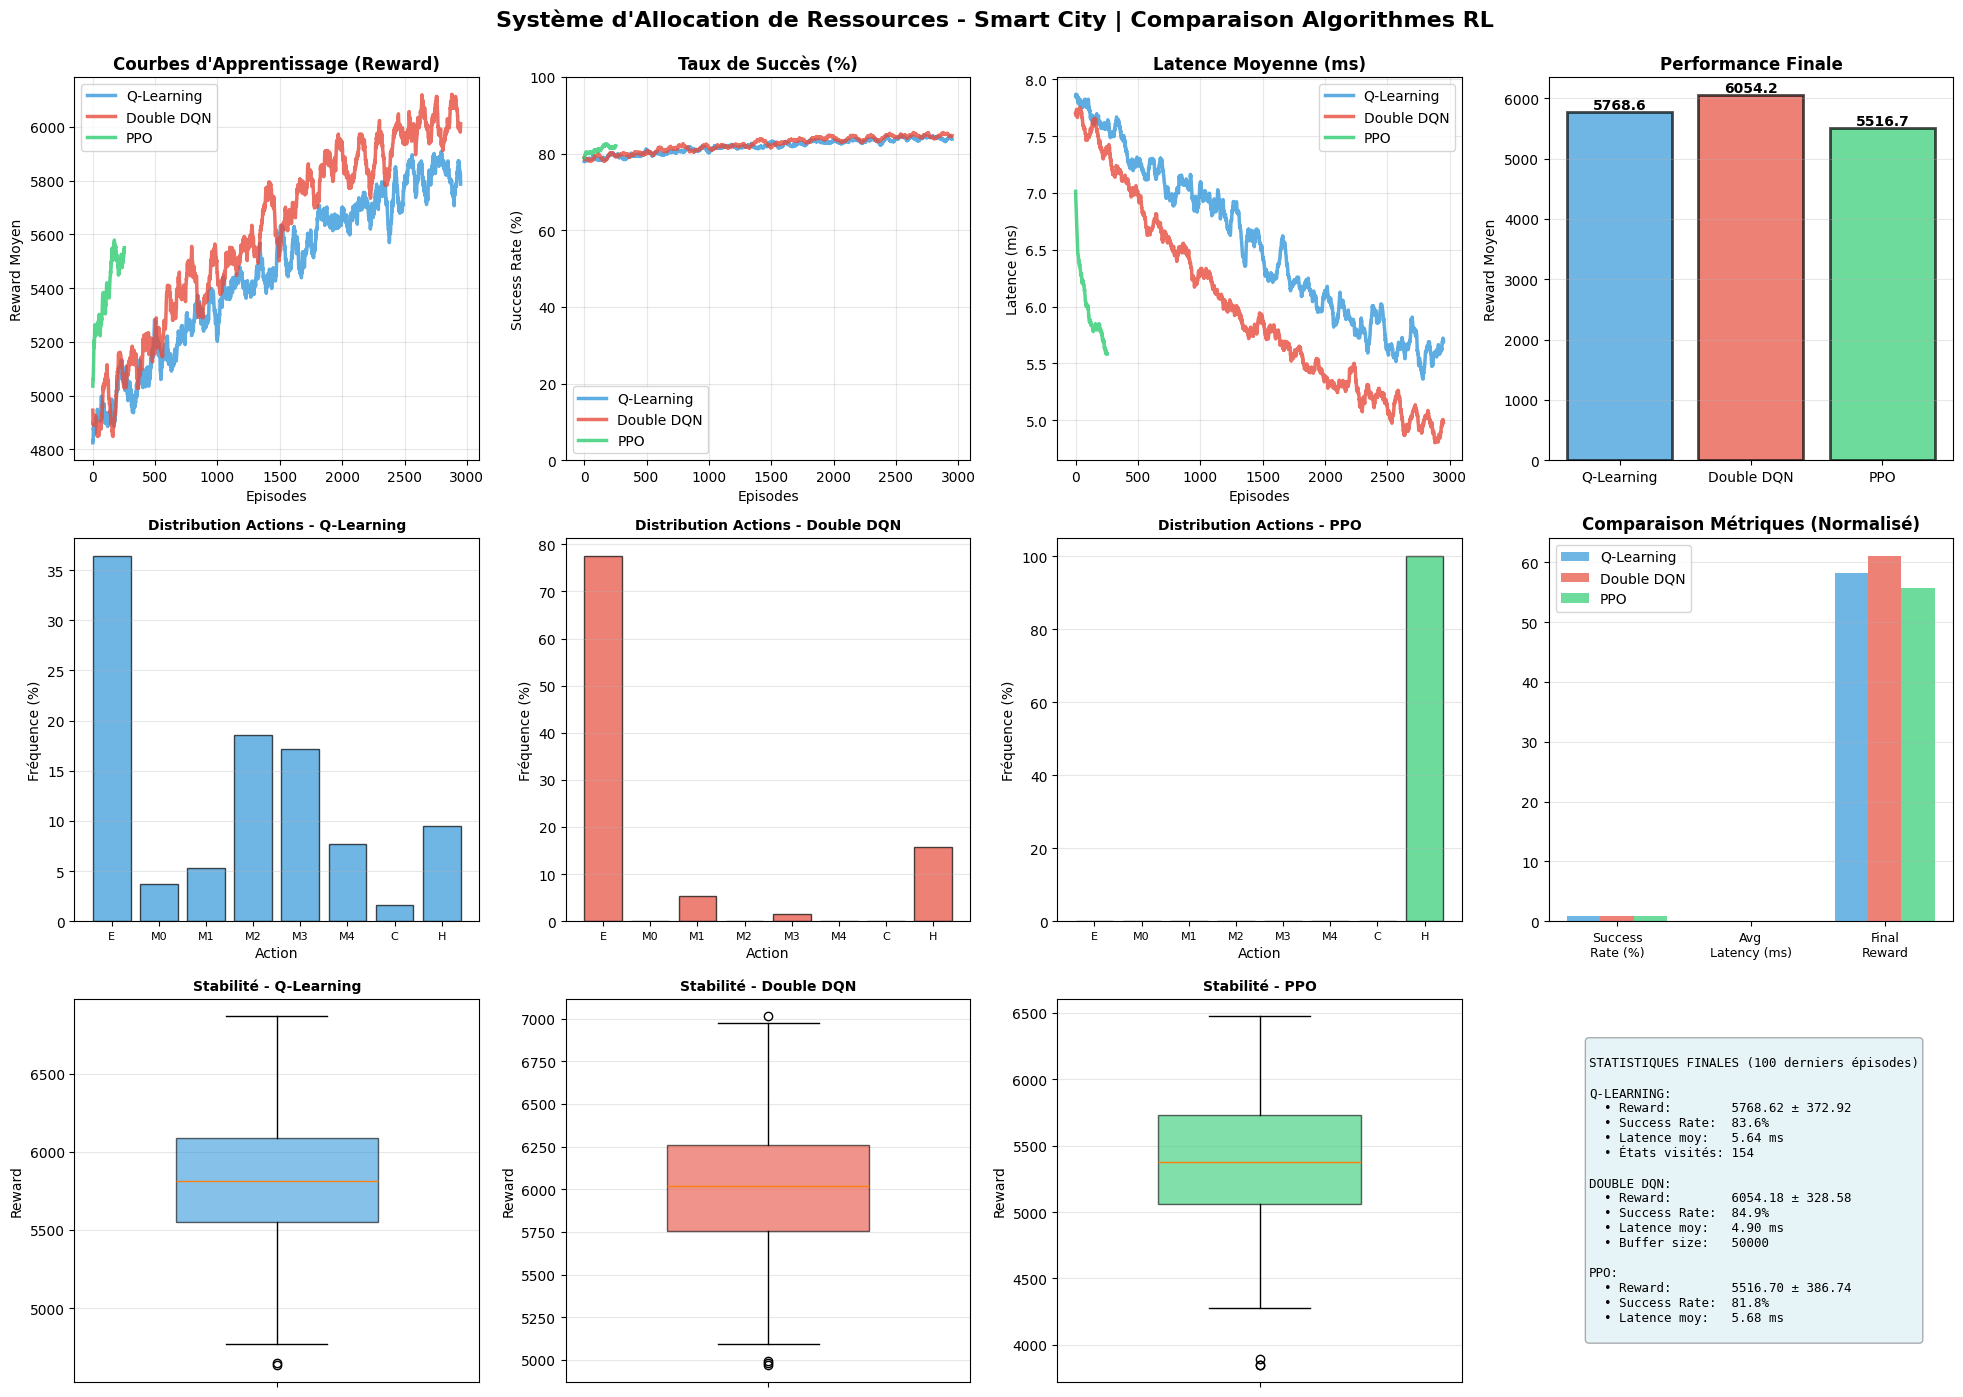


✅ ENTRAÎNEMENT TERMINÉ!

📊 RÉSULTATS FINAUX:
  Q-Learning:  5768.62 reward | 83.6% success
  Double DQN:  6054.18 reward | 84.9% success
  PPO:         5516.70 reward | 81.8% success



In [ ]:
"""
Système d'Allocation de Ressources pour Smart City
Projet de Fin d'Études - École d'Ingénieur

Architecture:
- 5 quartiers avec infrastructure MEC dédiée
- 1000+ utilisateurs mobiles (IoT, véhicules autonomes, AR/VR)
- 3 niveaux: Edge (Local), Fog (MEC), Cloud
- Optimisation multi-objectifs: latence, énergie, coût, QoS

Algorithmes: Q-Learning, Double DQN, PPO
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Stable Baselines
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env

# Configuration
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


# ==========================================
# 1. ARCHITECTURE DE LA SMART CITY
# ==========================================

@dataclass
class UserProfile:
    """Profil utilisateur avec exigences QoS"""
    user_id: int
    user_type: str  # 'IoT', 'Vehicle', 'AR_VR', 'Mobile', 'Industrial'
    location: Tuple[float, float]  # (x, y) coordonnées
    district_id: int  # Quartier (0-4)
    priority: int  # 1-5 (5 = critique)
    max_latency: float  # ms
    bandwidth_req: float  # Mbps
    energy_budget: float  # mW
    mobility: float  # km/h (vitesse de déplacement)

@dataclass
class MECServer:
    """Serveur MEC au niveau quartier"""
    mec_id: int
    district_id: int
    cpu_cores: int
    gpu_available: bool
    ram_gb: int
    storage_tb: int
    max_bandwidth: float  # Gbps
    current_load: float  # 0-1
    energy_efficiency: float  # GFLOPS/W
    location: Tuple[float, float]

@dataclass
class CloudDatacenter:
    """Datacenter Cloud centralisé"""
    cpu_clusters: int
    gpu_clusters: int
    ram_tb: int
    storage_pb: int
    max_bandwidth: float  # Tbps
    current_load: float
    distance_from_city: float  # km
    latency_base: float  # ms

class SmartCityTopology:
    """Topologie complète de la Smart City"""

    def __init__(self):
        # Configuration ville: 5 quartiers
        self.districts = {
            0: {"name": "Centre-Ville", "area_km2": 4, "population": 50000, "type": "commercial"},
            1: {"name": "Zone Industrielle", "area_km2": 8, "population": 10000, "type": "industrial"},
            2: {"name": "Quartier Résidentiel Nord", "area_km2": 6, "population": 80000, "type": "residential"},
            3: {"name": "Quartier Résidentiel Sud", "area_km2": 6, "population": 75000, "type": "residential"},
            4: {"name": "Campus Universitaire", "area_km2": 3, "population": 30000, "type": "educational"}
        }

        # Initialisation infrastructure MEC (1 par quartier)
        self.mec_servers = self._init_mec_infrastructure()

        # Cloud datacenter (unique, distant)
        self.cloud = CloudDatacenter(
            cpu_clusters=1000,
            gpu_clusters=200,
            ram_tb=500,
            storage_pb=10,
            max_bandwidth=100.0,  # 100 Tbps
            current_load=0.3,
            distance_from_city=50.0,  # 50km du centre
            latency_base=15.0  # 15ms base
        )

        # Capacités Edge (dispositifs locaux)
        self.edge_capacities = {
            'IoT': {'cpu_ghz': 0.5, 'ram_mb': 512, 'energy_mw': 50},
            'Mobile': {'cpu_ghz': 2.0, 'ram_mb': 4096, 'energy_mw': 500},
            'Vehicle': {'cpu_ghz': 8.0, 'ram_mb': 16384, 'energy_mw': 2000},
            'AR_VR': {'cpu_ghz': 4.0, 'ram_mb': 8192, 'energy_mw': 1000},
            'Industrial': {'cpu_ghz': 16.0, 'ram_mb': 32768, 'energy_mw': 5000}
        }

    def _init_mec_infrastructure(self) -> List[MECServer]:
        """Initialise les serveurs MEC par quartier"""
        mecs = []
        configs = [
            # Centre-Ville: haute performance
            {'cpu': 64, 'gpu': True, 'ram': 256, 'storage': 10, 'bw': 10.0, 'efficiency': 50},
            # Zone Industrielle: très haute puissance
            {'cpu': 128, 'gpu': True, 'ram': 512, 'storage': 50, 'bw': 20.0, 'efficiency': 40},
            # Résidentiel Nord: équilibré
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            # Résidentiel Sud: équilibré
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            # Campus: recherche et calcul
            {'cpu': 96, 'gpu': True, 'ram': 384, 'storage': 20, 'bw': 15.0, 'efficiency': 60}
        ]

        for i, config in enumerate(configs):
            mecs.append(MECServer(
                mec_id=i,
                district_id=i,
                cpu_cores=config['cpu'],
                gpu_available=config['gpu'],
                ram_gb=config['ram'],
                storage_tb=config['storage'],
                max_bandwidth=config['bw'],
                current_load=np.random.uniform(0.2, 0.5),
                energy_efficiency=config['efficiency'],
                location=(i*2.0, i*1.5)  # Positions géographiques
            ))
        return mecs

    def generate_user(self, user_id: int) -> UserProfile:
        """Génère un utilisateur aléatoire avec profil réaliste"""
        user_types = ['IoT', 'Mobile', 'Vehicle', 'AR_VR', 'Industrial']
        weights = [0.4, 0.3, 0.15, 0.1, 0.05]  # Distribution réaliste

        user_type = np.random.choice(user_types, p=weights)
        district_id = np.random.randint(0, 5)

        # Caractéristiques selon le type
        profiles = {
            'IoT': {'priority': 2, 'latency': 200, 'bandwidth': 0.5, 'energy': 100, 'mobility': 0},
            'Mobile': {'priority': 3, 'latency': 100, 'bandwidth': 5, 'energy': 1000, 'mobility': 5},
            'Vehicle': {'priority': 5, 'latency': 10, 'bandwidth': 50, 'energy': 5000, 'mobility': 60},
            'AR_VR': {'priority': 4, 'latency': 20, 'bandwidth': 100, 'energy': 2000, 'mobility': 3},
            'Industrial': {'priority': 5, 'latency': 50, 'bandwidth': 20, 'energy': 10000, 'mobility': 0}
        }

        profile = profiles[user_type]

        return UserProfile(
            user_id=user_id,
            user_type=user_type,
            location=(np.random.uniform(0, 10), np.random.uniform(0, 10)),
            district_id=district_id,
            priority=profile['priority'],
            max_latency=profile['latency'] * np.random.uniform(0.8, 1.2),
            bandwidth_req=profile['bandwidth'] * np.random.uniform(0.7, 1.3),
            energy_budget=profile['energy'],
            mobility=profile['mobility'] * np.random.uniform(0.5, 1.5)
        )


# ==========================================
# 2. MODÈLE DE TÂCHES RÉALISTES
# ==========================================

@dataclass
class ComputeTask:
    """Tâche de calcul avec exigences détaillées"""
    task_id: int
    user: UserProfile
    task_type: str  # 'stream', 'compute', 'storage', 'realtime'
    workload_mips: float  # Millions d'instructions
    data_size_mb: float
    priority: int
    deadline_ms: float
    splittable: bool  # Peut être divisée entre plusieurs niveaux
    gpu_required: bool

class TaskGenerator:
    """Générateur de tâches réalistes"""

    def __init__(self, topology: SmartCityTopology):
        self.topology = topology
        self.task_counter = 0

    def generate_task(self, user: UserProfile) -> ComputeTask:
        """Génère une tâche basée sur le profil utilisateur"""

        task_distributions = {
            'IoT': [
                {'type': 'stream', 'mips': 100, 'data': 0.1, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 500, 'data': 1, 'gpu': False, 'split': True}
            ],
            'Mobile': [
                {'type': 'stream', 'mips': 1000, 'data': 5, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 2000, 'data': 10, 'gpu': True, 'split': True}
            ],
            'Vehicle': [
                {'type': 'realtime', 'mips': 5000, 'data': 50, 'gpu': True, 'split': False},
                {'type': 'compute', 'mips': 8000, 'data': 100, 'gpu': True, 'split': True}
            ],
            'AR_VR': [
                {'type': 'realtime', 'mips': 10000, 'data': 200, 'gpu': True, 'split': False},
                {'type': 'stream', 'mips': 5000, 'data': 100, 'gpu': True, 'split': False}
            ],
            'Industrial': [
                {'type': 'compute', 'mips': 50000, 'data': 500, 'gpu': True, 'split': True},
                {'type': 'storage', 'mips': 1000, 'data': 1000, 'gpu': False, 'split': True}
            ]
        }

        task_template = random.choice(task_distributions[user.user_type])

        self.task_counter += 1
        return ComputeTask(
            task_id=self.task_counter,
            user=user,
            task_type=task_template['type'],
            workload_mips=task_template['mips'] * np.random.uniform(0.8, 1.2),
            data_size_mb=task_template['data'] * np.random.uniform(0.7, 1.3),
            priority=user.priority,
            deadline_ms=user.max_latency,
            splittable=task_template['split'],
            gpu_required=task_template['gpu']
        )


# ==========================================
# 3. ENVIRONNEMENT GYMNASIUM AVANCÉ
# ==========================================

class SmartCityResourceEnv(gym.Env):
    """Environnement d'allocation de ressources pour Smart City"""

    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, num_users: int = 100, max_steps: int = 500):
        super().__init__()

        self.topology = SmartCityTopology()
        self.task_generator = TaskGenerator(self.topology)
        self.num_users = num_users
        self.max_steps_per_episode = max_steps

        # Espace d'actions: 8 actions possibles
        # 0: Edge Local
        # 1-5: MEC du quartier 0-4
        # 6: Cloud
        # 7: Offload hybride (Edge + MEC)
        self.action_space = spaces.Discrete(8)

        # Espace d'observations (12 features)
        self.observation_space = spaces.Box(
            low=np.array([
                0,      # task_workload (normalized)
                0,      # data_size (normalized)
                1,      # priority (1-5)
                0,      # deadline (normalized)
                0,      # user_district (0-4)
                0,      # user_type (0-4)
                0,      # mec_load_local (0-1)
                0,      # mec_load_avg (0-1)
                0,      # cloud_load (0-1)
                0,      # time_of_day (0-1)
                0,      # mobility (normalized)
                0       # gpu_required (0-1)
            ], dtype=np.float32),
            high=np.array([1, 1, 5, 1, 4, 4, 1, 1, 1, 1, 1, 1], dtype=np.float32),
            dtype=np.float32
        )

        # État interne
        self.users = []
        self.current_task = None
        self.steps_count = 0
        self.time_of_day = 0.5  # 0=minuit, 0.5=midi, 1=minuit

        # Métriques de performance
        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0

        # Normalisation
        self.max_workload = 50000
        self.max_data_size = 1000
        self.max_deadline = 200
        self.max_mobility = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Réinitialisation
        self.steps_count = 0
        self.time_of_day = np.random.uniform(0, 1)
        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0

        # Génération utilisateurs
        self.users = [self.topology.generate_user(i) for i in range(self.num_users)]

        # Mise à jour charges MEC (varie selon heure)
        self._update_infrastructure_loads()

        # Génération première tâche
        self.current_task = self._generate_next_task()

        return self._get_observation(), {}

    def _update_infrastructure_loads(self):
        """Met à jour les charges selon l'heure et la demande"""
        # Modèle sinusoïdal: pic à midi et 18h
        load_factor = 0.3 + 0.4 * (np.sin(self.time_of_day * 4 * np.pi) ** 2)

        for mec in self.topology.mec_servers:
            base_load = 0.2 if self.topology.districts[mec.district_id]['type'] == 'industrial' else 0.1
            mec.current_load = base_load + load_factor * np.random.uniform(0.5, 1.0)
            mec.current_load = np.clip(mec.current_load, 0, 1)

        self.topology.cloud.current_load = 0.3 + load_factor * 0.3
        self.topology.cloud.current_load = np.clip(self.topology.cloud.current_load, 0, 1)

    def _generate_next_task(self) -> ComputeTask:
        """Génère la prochaine tâche"""
        user = random.choice(self.users)
        return self.task_generator.generate_task(user)

    def _get_observation(self) -> np.ndarray:
        """Construit le vecteur d'observation"""
        task = self.current_task
        user = task.user

        # Mapping types
        type_map = {'IoT': 0, 'Mobile': 1, 'Vehicle': 2, 'AR_VR': 3, 'Industrial': 4}

        # Charge MEC locale et moyenne
        local_mec = self.topology.mec_servers[user.district_id]
        avg_mec_load = np.mean([m.current_load for m in self.topology.mec_servers])

        obs = np.array([
            task.workload_mips / self.max_workload,
            task.data_size_mb / self.max_data_size,
            task.priority,
            task.deadline_ms / self.max_deadline,
            user.district_id / 4.0,
            type_map[user.user_type] / 4.0,
            local_mec.current_load,
            avg_mec_load,
            self.topology.cloud.current_load,
            self.time_of_day,
            user.mobility / self.max_mobility,
            1.0 if task.gpu_required else 0.0
        ], dtype=np.float32)

        return obs

    def _compute_latency(self, task: ComputeTask, action: int) -> float:
        """Calcule la latence totale (transmission + calcul + retour)"""
        user = task.user

        # Latence réseau
        if action == 0:  # Edge
            network_latency = 0
        elif 1 <= action <= 5:  # MEC
            mec = self.topology.mec_servers[action - 1]
            distance = np.sqrt((user.location[0] - mec.location[0])**2 +
                              (user.location[1] - mec.location[1])**2)
            network_latency = 2 + distance * 0.5  # 2ms base + distance
        elif action == 6:  # Cloud
            network_latency = self.topology.cloud.latency_base + np.random.uniform(5, 15)
        else:  # Hybrid
            network_latency = 1 + np.random.uniform(1, 3)

        # Latence de calcul
        if action == 0:  # Edge
            edge_power = self.topology.edge_capacities[user.user_type]['cpu_ghz']
            compute_latency = task.workload_mips / (edge_power * 1000)
        elif 1 <= action <= 5:  # MEC
            mec = self.topology.mec_servers[action - 1]
            effective_power = mec.cpu_cores * 3.0 * (1 - mec.current_load * 0.5)
            compute_latency = task.workload_mips / (effective_power * 1000)
        elif action == 6:  # Cloud
            effective_power = 1000 * (1 - self.topology.cloud.current_load * 0.3)
            compute_latency = task.workload_mips / (effective_power * 1000)
        else:  # Hybrid
            compute_latency = task.workload_mips / (8000)  # Calcul parallèle

        # Latence transmission données
        data_latency = task.data_size_mb * 0.1  # 0.1ms par MB

        total_latency = network_latency + compute_latency + data_latency
        return total_latency

    def _compute_energy(self, task: ComputeTask, action: int, latency: float) -> float:
        """Calcule la consommation énergétique (mJ)"""
        user = task.user

        if action == 0:  # Edge
            power = self.topology.edge_capacities[user.user_type]['energy_mw']
            energy = power * latency  # mJ
        elif 1 <= action <= 5:  # MEC
            mec = self.topology.mec_servers[action - 1]
            # Énergie transmission + calcul
            transmission_energy = task.data_size_mb * 10  # 10mJ/MB
            compute_power = (mec.cpu_cores * 50) / mec.energy_efficiency
            compute_energy = compute_power * latency
            energy = transmission_energy + compute_energy
        elif action == 6:  # Cloud
            transmission_energy = task.data_size_mb * 50  # Plus coûteux
            compute_energy = 100 * latency  # Datacenter distant
            energy = transmission_energy + compute_energy
        else:  # Hybrid
            energy = (self.topology.edge_capacities[user.user_type]['energy_mw'] * latency * 0.6 +
                     task.data_size_mb * 5)

        return energy

    def _compute_cost(self, task: ComputeTask, action: int) -> float:
        """Calcule le coût monétaire (unités arbitraires)"""
        if action == 0:  # Edge: gratuit
            return 0
        elif 1 <= action <= 5:  # MEC: coût modéré
            return task.workload_mips * 0.001 + task.data_size_mb * 0.01
        elif action == 6:  # Cloud: coût élevé
            return task.workload_mips * 0.005 + task.data_size_mb * 0.05
        else:  # Hybrid
            return task.workload_mips * 0.0015 + task.data_size_mb * 0.02

    def step(self, action: int):
        self.steps_count += 1
        task = self.current_task
        user = task.user

        # Vérifications de faisabilité
        feasible = True
        failure_reason = ""

        # Vérification GPU
        if task.gpu_required:
            if action == 0:  # Edge n'a généralement pas de GPU
                if user.user_type not in ['Vehicle', 'AR_VR', 'Industrial']:
                    feasible = False
                    failure_reason = "GPU non disponible sur Edge"
            elif 1 <= action <= 5:
                mec = self.topology.mec_servers[action - 1]
                if not mec.gpu_available:
                    feasible = False
                    failure_reason = "GPU non disponible sur MEC"

        # Vérification capacité
        if action == 0:
            edge_cap = self.topology.edge_capacities[user.user_type]['cpu_ghz'] * 1000
            if task.workload_mips > edge_cap * 2:
                feasible = False
                failure_reason = "Capacité Edge insuffisante"

        # Calcul métriques
        latency = self._compute_latency(task, action)
        energy = self._compute_energy(task, action, latency)
        cost = self._compute_cost(task, action)

        # Vérification deadline
        meets_deadline = latency <= task.deadline_ms

        # Calcul récompense multi-objectifs
        reward = 0
        success = feasible and meets_deadline

        if not feasible:
            reward = -10.0
            self.failed_tasks += 1
        elif not meets_deadline:
            # Pénalité proportionnelle au dépassement
            overshoot = (latency - task.deadline_ms) / task.deadline_ms
            reward = -5.0 * (1 + overshoot)
            self.qos_violations += 1
            self.failed_tasks += 1
        else:
            # Récompense pondérée par priorité
            priority_weight = task.priority / 5.0

            # Bonus latence (plus faible que deadline = mieux)
            latency_bonus = (task.deadline_ms - latency) / task.deadline_ms * 5

            # Pénalité énergie (normalisée)
            energy_penalty = energy / 10000.0

            # Pénalité coût
            cost_penalty = cost * 0.1

            # Bonus actions efficaces
            action_bonus = 0
            if action == 0:  # Edge favorisé si possible
                action_bonus = 2.0
            elif 1 <= action <= 5:  # MEC bon compromis
                action_bonus = 1.0
            elif action == 7:  # Hybrid innovant
                action_bonus = 1.5

            reward = (
                10.0 * priority_weight +
                latency_bonus * 2 -
                energy_penalty * 0.5 -
                cost_penalty * 0.3 +
                action_bonus
            )

            self.successful_tasks += 1
            self.total_energy_consumed += energy
            self.total_latency += latency

        # Informations détaillées
        info = {
            'success': success,
            'latency_ms': latency,
            'energy_mj': energy,
            'cost': cost,
            'action_name': ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid'][action],
            'task_type': task.task_type,
            'user_type': user.user_type,
            'priority': task.priority,
            'meets_deadline': meets_deadline,
            'failure_reason': failure_reason if not feasible else None
        }

        # Mise à jour temporelle
        self.time_of_day = (self.time_of_day + 0.001) % 1.0
        if self.steps_count % 50 == 0:
            self._update_infrastructure_loads()

        # Génération nouvelle tâche
        self.current_task = self._generate_next_task()

        # Terminal conditions
        terminated = False  # Pas de terminal naturel dans ce cas
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return self._get_observation(), reward, terminated, truncated, info


# ==========================================
# 4. AGENTS D'APPRENTISSAGE
# ==========================================

class QLearningSmartCity:
    """Q-Learning avec state aggregation intelligent"""

    def __init__(self, n_actions=8):
        self.n_actions = n_actions
        self.lr = 0.05
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.9995
        self.q_table = {}

    def _discretize_state(self, obs):
        """Discrétisation intelligente de l'état"""
        workload_bin = min(int(obs[0] * 10), 9)
        deadline_bin = min(int(obs[3] * 5), 4)
        priority = int(obs[2])
        district = int(obs[4] * 4)
        user_type = int(obs[5] * 4)
        mec_load_bin = min(int(obs[6] * 3), 2)
        gpu_req = int(obs[11])

        return (workload_bin, deadline_bin, priority, district, user_type, mec_load_bin, gpu_req)

    def get_q_values(self, obs):
        state_key = self._discretize_state(obs)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.get_q_values(obs)
        return int(np.argmax(q_values))

    def update(self, obs, action, reward, next_obs, done):
        current_q = self.get_q_values(obs)[action]

        if done:
            target = reward
        else:
            max_next_q = np.max(self.get_q_values(next_obs))
            target = reward + self.gamma * max_next_q

        state_key = self._discretize_state(obs)
        self.q_table[state_key][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class DoubleDQNNetwork(nn.Module):
    """Architecture profonde pour Double DQN"""

    def __init__(self, state_dim=12, n_actions=8):
        super().__init__()

        # Couches fully connected avec normalisation
        self.fc1 = nn.Linear(state_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions)

        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


class DoubleDQNAgent:
    """Double DQN avec Prioritized Experience Replay"""

    def __init__(self, state_dim=12, n_actions=8):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Réseaux
        self.q_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimiseur
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0005)

        # Replay buffer
        self.memory = deque(maxlen=50000)
        self.batch_size = 128
        self.gamma = 0.99

        # Exploration
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.9995

        # Target update
        self.target_update_freq = 200
        self.update_counter = 0

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)

        self.q_network.eval()
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            q_values = self.q_network(obs_tensor)
            action = int(q_values.argmax().item())
        self.q_network.train()

        return action

    def remember(self, obs, action, reward, next_obs, done):
        self.memory.append((obs, action, reward, next_obs, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        self.q_network.train()

        batch = random.sample(self.memory, self.batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)

        obs = torch.FloatTensor(np.array(obs)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_obs = torch.FloatTensor(np.array(next_obs)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(obs).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_obs).argmax(1)
            next_q = self.target_network(next_obs).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# ==========================================
# 5. ENTRAÎNEMENT
# ==========================================

def train_qlearning_smartcity(n_episodes=3000):
    """Entraînement Q-Learning"""
    print("\n" + "="*80)
    print("ENTRAÎNEMENT Q-LEARNING - SMART CITY")
    print("="*80)

    env = SmartCityResourceEnv(num_users=100, max_steps=500)
    agent = QLearningSmartCity()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.update(obs, action, reward, next_obs, done)
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f} | States: {len(agent.q_table)}")

    print(f"\nEntraînement terminé! États explorés: {len(agent.q_table)}")
    return agent, episode_rewards, success_rates, avg_latencies


def train_double_dqn_smartcity(n_episodes=3000):
    """Entraînement Double DQN"""
    print("\n" + "="*80)
    print("ENTRAÎNEMENT DOUBLE DQN - SMART CITY")
    print("="*80)
    print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    env = SmartCityResourceEnv(num_users=100, max_steps=500)
    agent = DoubleDQNAgent()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.remember(obs, action, reward, next_obs, done)
            agent.replay()
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f} | Buffer: {len(agent.memory)}")

    print("\nEntraînement terminé!")
    return agent, episode_rewards, success_rates, avg_latencies


class PPOCallback(BaseCallback):
    """Callback pour PPO avec métriques Smart City"""

    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.success_rates = []
        self.avg_latencies = []
        self.current_reward = 0
        self.current_successes = 0
        self.current_failures = 0
        self.current_latency = 0

    def _on_step(self):
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        info = self.locals.get('infos', [{}])[0]
        if info.get('success', False):
            self.current_successes += 1
            self.current_latency += info.get('latency_ms', 0)
        else:
            self.current_failures += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)

            total_tasks = self.current_successes + self.current_failures
            if total_tasks > 0:
                success_rate = (self.current_successes / total_tasks) * 100
                self.success_rates.append(success_rate)

            if self.current_successes > 0:
                avg_lat = self.current_latency / self.current_successes
                self.avg_latencies.append(avg_lat)

            self.current_reward = 0
            self.current_successes = 0
            self.current_failures = 0
            self.current_latency = 0

        return True


def train_ppo_smartcity(total_timesteps=150000):
    """Entraînement PPO"""
    print("\n" + "="*80)
    print("ENTRAÎNEMENT PPO - SMART CITY")
    print("="*80)

    env = make_vec_env(lambda: SmartCityResourceEnv(num_users=100, max_steps=500), n_envs=1)

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        gamma=0.99,
        batch_size=128,
        n_steps=2048,
        ent_coef=0.01,
        clip_range=0.2
    )

    callback = PPOCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    print("\nEntraînement terminé!")
    return model, callback.episode_rewards, callback.success_rates, callback.avg_latencies


# ==========================================
# 6. VISUALISATION AVANCÉE
# ==========================================

def plot_smartcity_results(q_results, dqn_results, ppo_results):
    """Visualisation complète des résultats"""

    q_agent, q_rewards, q_success, q_latency = q_results
    dqn_agent, dqn_rewards, dqn_success, dqn_latency = dqn_results
    ppo_model, ppo_rewards, ppo_success, ppo_latency = ppo_results

    fig = plt.figure(figsize=(20, 14))

    # 1. Courbes d'apprentissage (Reward)
    ax1 = plt.subplot(3, 4, 1)
    window = 50

    for rewards, color, label in [
        (q_rewards, '#3498db', 'Q-Learning'),
        (dqn_rewards, '#e74c3c', 'Double DQN'),
        (ppo_rewards, '#2ecc71', 'PPO')
    ]:
        if len(rewards) > window:
            smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax1.set_title("Courbes d'Apprentissage (Reward)", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward Moyen")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Taux de succès
    ax2 = plt.subplot(3, 4, 2)

    for success, color, label in [
        (q_success, '#3498db', 'Q-Learning'),
        (dqn_success, '#e74c3c', 'Double DQN'),
        (ppo_success, '#2ecc71', 'PPO')
    ]:
        if len(success) > window:
            smooth = np.convolve(success, np.ones(window)/window, mode='valid')
            ax2.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax2.set_title("Taux de Succès (%)", fontsize=12, fontweight='bold')
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Success Rate (%)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])

    # 3. Latence moyenne
    ax3 = plt.subplot(3, 4, 3)

    for latency, color, label in [
        (q_latency, '#3498db', 'Q-Learning'),
        (dqn_latency, '#e74c3c', 'Double DQN'),
        (ppo_latency, '#2ecc71', 'PPO')
    ]:
        if len(latency) > window:
            smooth = np.convolve(latency, np.ones(window)/window, mode='valid')
            ax3.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax3.set_title("Latence Moyenne (ms)", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Episodes")
    ax3.set_ylabel("Latence (ms)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Performance finale
    ax4 = plt.subplot(3, 4, 4)
    final_rewards = [
        np.mean(q_rewards[-100:]),
        np.mean(dqn_rewards[-100:]),
        np.mean(ppo_rewards[-100:])
    ]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax4.bar(['Q-Learning', 'Double DQN', 'PPO'], final_rewards,
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, score in zip(bars, final_rewards):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    ax4.set_title("Performance Finale", fontsize=12, fontweight='bold')
    ax4.set_ylabel("Reward Moyen")
    ax4.grid(True, axis='y', alpha=0.3)

    # 5-7. Distribution des actions
    env = SmartCityResourceEnv(num_users=100, max_steps=100)
    action_names = ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid']

    for idx, (agent, agent_type, title, color) in enumerate([
        (q_agent, 'q', 'Q-Learning', '#3498db'),
        (dqn_agent, 'dqn', 'Double DQN', '#e74c3c'),
        (ppo_model, 'ppo', 'PPO', '#2ecc71')
    ]):
        ax = plt.subplot(3, 4, 5 + idx)

        action_counts = np.zeros(8)
        obs, _ = env.reset()

        for _ in range(1000):
            if agent_type == 'ppo':
                action, _ = agent.predict(obs, deterministic=True)
                action = int(action)
            elif agent_type == 'dqn':
                action = agent.choose_action(obs, training=False)
            else:
                action = agent.choose_action(obs, training=False)

            action_counts[action] += 1
            obs, _, _, _, _ = env.step(action)

        action_counts = action_counts / action_counts.sum() * 100
        bars = ax.bar(range(8), action_counts, color=color, alpha=0.7, edgecolor='black')

        ax.set_title(f"Distribution Actions - {title}", fontsize=10, fontweight='bold')
        ax.set_xlabel("Action")
        ax.set_ylabel("Fréquence (%)")
        ax.set_xticks(range(8))
        ax.set_xticklabels(['E', 'M0', 'M1', 'M2', 'M3', 'M4', 'C', 'H'], fontsize=8)
        ax.grid(True, axis='y', alpha=0.3)

    # 8. Comparaison métriques
    ax8 = plt.subplot(3, 4, 8)
    metrics = ['Success\nRate (%)', 'Avg\nLatency (ms)', 'Final\nReward']

    q_metrics = [np.mean(q_success[-100:]), np.mean(q_latency[-100:]), np.mean(q_rewards[-100:])]
    dqn_metrics = [np.mean(dqn_success[-100:]), np.mean(dqn_latency[-100:]), np.mean(dqn_rewards[-100:])]
    ppo_metrics = [np.mean(ppo_success[-100:]), np.mean(ppo_latency[-100:]), np.mean(ppo_rewards[-100:])]

    x = np.arange(len(metrics))
    width = 0.25

    # Normalisation pour visualisation
    q_norm = [q_metrics[0]/100, q_metrics[1]/100, (q_metrics[2]+50)/100]
    dqn_norm = [dqn_metrics[0]/100, dqn_metrics[1]/100, (dqn_metrics[2]+50)/100]
    ppo_norm = [ppo_metrics[0]/100, ppo_metrics[1]/100, (ppo_metrics[2]+50)/100]

    ax8.bar(x - width, q_norm, width, label='Q-Learning', color='#3498db', alpha=0.7)
    ax8.bar(x, dqn_norm, width, label='Double DQN', color='#e74c3c', alpha=0.7)
    ax8.bar(x + width, ppo_norm, width, label='PPO', color='#2ecc71', alpha=0.7)

    ax8.set_title("Comparaison Métriques (Normalisé)", fontsize=12, fontweight='bold')
    ax8.set_xticks(x)
    ax8.set_xticklabels(metrics, fontsize=9)
    ax8.legend()
    ax8.grid(True, axis='y', alpha=0.3)

    # 9-11. Boxplots stabilité
    for idx, (rewards, title, color) in enumerate([
        (q_rewards, 'Q-Learning', '#3498db'),
        (dqn_rewards, 'Double DQN', '#e74c3c'),
        (ppo_rewards, 'PPO', '#2ecc71')
    ]):
        ax = plt.subplot(3, 4, 9 + idx)

        bp = ax.boxplot([rewards[-500:]], patch_artist=True, widths=0.5)
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        ax.set_title(f"Stabilité - {title}", fontsize=10, fontweight='bold')
        ax.set_ylabel("Reward")
        ax.set_xticklabels([''])
        ax.grid(True, axis='y', alpha=0.3)

    # 12. Statistiques finales
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')

    stats_text = f"""
STATISTIQUES FINALES (100 derniers épisodes)

Q-LEARNING:
  • Reward:        {np.mean(q_rewards[-100:]):.2f} ± {np.std(q_rewards[-100:]):.2f}
  • Success Rate:  {np.mean(q_success[-100:]):.1f}%
  • Latence moy:   {np.mean(q_latency[-100:]):.2f} ms
  • États visités: {len(q_agent.q_table)}

DOUBLE DQN:
  • Reward:        {np.mean(dqn_rewards[-100:]):.2f} ± {np.std(dqn_rewards[-100:]):.2f}
  • Success Rate:  {np.mean(dqn_success[-100:]):.1f}%
  • Latence moy:   {np.mean(dqn_latency[-100:]):.2f} ms
  • Buffer size:   {len(dqn_agent.memory)}

PPO:
  • Reward:        {np.mean(ppo_rewards[-100:]):.2f} ± {np.std(ppo_rewards[-100:]):.2f}
  • Success Rate:  {np.mean(ppo_success[-100:]):.1f}%
  • Latence moy:   {np.mean(ppo_latency[-100:]):.2f} ms
    """

    ax12.text(0.1, 0.5, stats_text, fontsize=9, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round',
             facecolor='lightblue', alpha=0.3))

    plt.suptitle("Système d'Allocation de Ressources - Smart City | Comparaison Algorithmes RL",
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('smartcity_rl_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Graphique sauvegardé: smartcity_rl_results.png")
    plt.show()


# ==========================================
# 7. MAIN - EXÉCUTION
# ==========================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print(" SYSTÈME D'ALLOCATION DE RESSOURCES POUR SMART CITY")
    print(" Projet de Fin d'Études - École d'Ingénieur")
    print("="*80)
    print("\n📊 ARCHITECTURE:")
    print("  • 5 Quartiers avec infrastructure MEC dédiée")
    print("  • 100 Utilisateurs (IoT, Véhicules, AR/VR, Mobile, Industriel)")
    print("  • 3 Niveaux: Edge (Local) - Fog (MEC) - Cloud")
    print("  • 8 Actions possibles d'allocation")
    print("\n🎯 OBJECTIFS:")
    print("  • Minimiser la latence")
    print("  • Optimiser la consommation énergétique")
    print("  • Respecter les contraintes QoS")
    print("  • Maximiser le taux de succès")
    print("\n🤖 ALGORITHMES:")
    print("  • Q-Learning (Tabular)")
    print("  • Double DQN (Deep RL)")
    print("  • PPO (Policy Gradient)")
    print("="*80 + "\n")

    # 1. Q-Learning
    print("\n🔵 Phase 1/3: Q-Learning")
    q_results = train_qlearning_smartcity(n_episodes=3000)

    # 2. Double DQN
    print("\n🔴 Phase 2/3: Double DQN")
    dqn_results = train_double_dqn_smartcity(n_episodes=3000)

    # 3. PPO
    print("\n🟢 Phase 3/3: PPO")
    ppo_results = train_ppo_smartcity(total_timesteps=150000)

    # 4. Visualisation
    print("\n📈 Génération des visualisations...")
    plot_smartcity_results(q_results, dqn_results, ppo_results)

    print("\n" + "="*80)
    print("✅ ENTRAÎNEMENT TERMINÉ!")
    print("="*80)
    print("\n📊 RÉSULTATS FINAUX:")
    print(f"  Q-Learning:  {np.mean(q_results[1][-100:]):.2f} reward | "
          f"{np.mean(q_results[2][-100:]):.1f}% success")
    print(f"  Double DQN:  {np.mean(dqn_results[1][-100:]):.2f} reward | "
          f"{np.mean(dqn_results[2][-100:]):.1f}% success")
    print(f"  PPO:         {np.mean(ppo_results[1][-100:]):.2f} reward | "
          f"{np.mean(ppo_results[2][-100:]):.1f}% success")
    print("="*80 + "\n")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



 SYSTÈME D'ALLOCATION DE RESSOURCES POUR SMART CITY
 Projet de Fin d'Études - École d'Ingénieur
 VERSION DIFFICILE - Apprentissage Progressif

📊 ARCHITECTURE:
  • 5 Quartiers avec infrastructure MEC dédiée
  • 200 Utilisateurs simultanés (doublé!)
  • 3 Niveaux: Edge (Local) - Fog (MEC) - Cloud
  • 8 Actions possibles d'allocation

🔥 DÉFIS RÉALISTES:
  • Congestion réseau dynamique (30-100%)
  • Interférences sans fil variables
  • Heures de pointe (8-10h, 17-20h)
  • Événements aléatoires (urgences, festivals, maintenance)
  • Surcharge MEC cumulative
  • Latences augmentées x2-x3
  • Capacités réduites sous charge

⚠️ CONTRAINTES STRICTES:
  • MEC refuse >95% charge
  • Pannes réseau si congestion >80%
  • Pénalités exponentielles sur échecs
  • Deadline critiques pour véhicules autonomes

🎯 OBJECTIFS:
  • Minimiser la latence malgré congestion
  • Optimiser l'énergie sous contraintes
  • Respecter QoS avec ressources limitées
  • Maximiser taux de succès (cible: >70%)

🤖 ALGORITHME

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward: -37041.68 | Success:  28.1% | Epsilon: 0.904 | States: 640
Episode  400 | Reward: -33889.56 | Success:  31.7% | Epsilon: 0.818 | States: 674
Episode  600 | Reward: -31429.93 | Success:  34.2% | Epsilon: 0.740 | States: 684
Episode  800 | Reward: -31572.97 | Success:  36.9% | Epsilon: 0.670 | States: 709
Episode 1000 | Reward: -29147.95 | Success:  38.7% | Epsilon: 0.606 | States: 714
Episode 1200 | Reward: -25068.54 | Success:  40.6% | Epsilon: 0.548 | States: 719
Episode 1400 | Reward: -24234.78 | Success:  43.5% | Epsilon: 0.496 | States: 726
Episode 1600 | Reward: -23418.85 | Success:  43.2% | Epsilon: 0.449 | States: 727
Episode 1800 | Reward: -23588.09 | Success:  42.4% | Epsilon: 0.406 | States: 731
Episode 2000 | Reward: -22512.94 | Success:  43.6% | Epsilon: 0.368 | States: 733
Episode 2200 | Reward: -20945.39 | Success:  45.8% | Epsilon: 0.333 | States: 736
Episode 2400 | Reward: -18907.43 | Success:  47.9% | Epsilon: 0.301 | States: 743
Episode 2600 | R

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward: -36293.35 | Success:  28.1% | Epsilon: 0.904 | Buffer: 50000
Episode  400 | Reward: -34090.48 | Success:  31.2% | Epsilon: 0.818 | Buffer: 50000
Episode  600 | Reward: -30715.73 | Success:  35.0% | Epsilon: 0.740 | Buffer: 50000
Episode  800 | Reward: -29508.53 | Success:  37.5% | Epsilon: 0.670 | Buffer: 50000
Episode 1000 | Reward: -27290.72 | Success:  40.1% | Epsilon: 0.606 | Buffer: 50000
Episode 1200 | Reward: -24442.22 | Success:  41.9% | Epsilon: 0.548 | Buffer: 50000
Episode 1400 | Reward: -22974.87 | Success:  45.4% | Epsilon: 0.496 | Buffer: 50000
Episode 1600 | Reward: -21724.13 | Success:  46.3% | Epsilon: 0.449 | Buffer: 50000
Episode 1800 | Reward: -20934.57 | Success:  47.2% | Epsilon: 0.406 | Buffer: 50000
Episode 2000 | Reward: -21497.11 | Success:  39.5% | Epsilon: 0.368 | Buffer: 50000
Episode 2200 | Reward: -17085.97 | Success:  51.7% | Epsilon: 0.333 | Buffer: 50000
Episode 2400 | Reward: -15683.31 | Success:  53.5% | Epsilon: 0.301 | Buffer

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -4.1e+04 |
| time/              |          |
|    fps             | 574      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 500           |
|    ep_rew_mean          | -4.27e+04     |
| time/                   |               |
|    fps                  | 542           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00038170515 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.08         |
|    explained_variance   | -8.94e-06     |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✓ Graphique sauvegardé: smartcity_rl_results.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


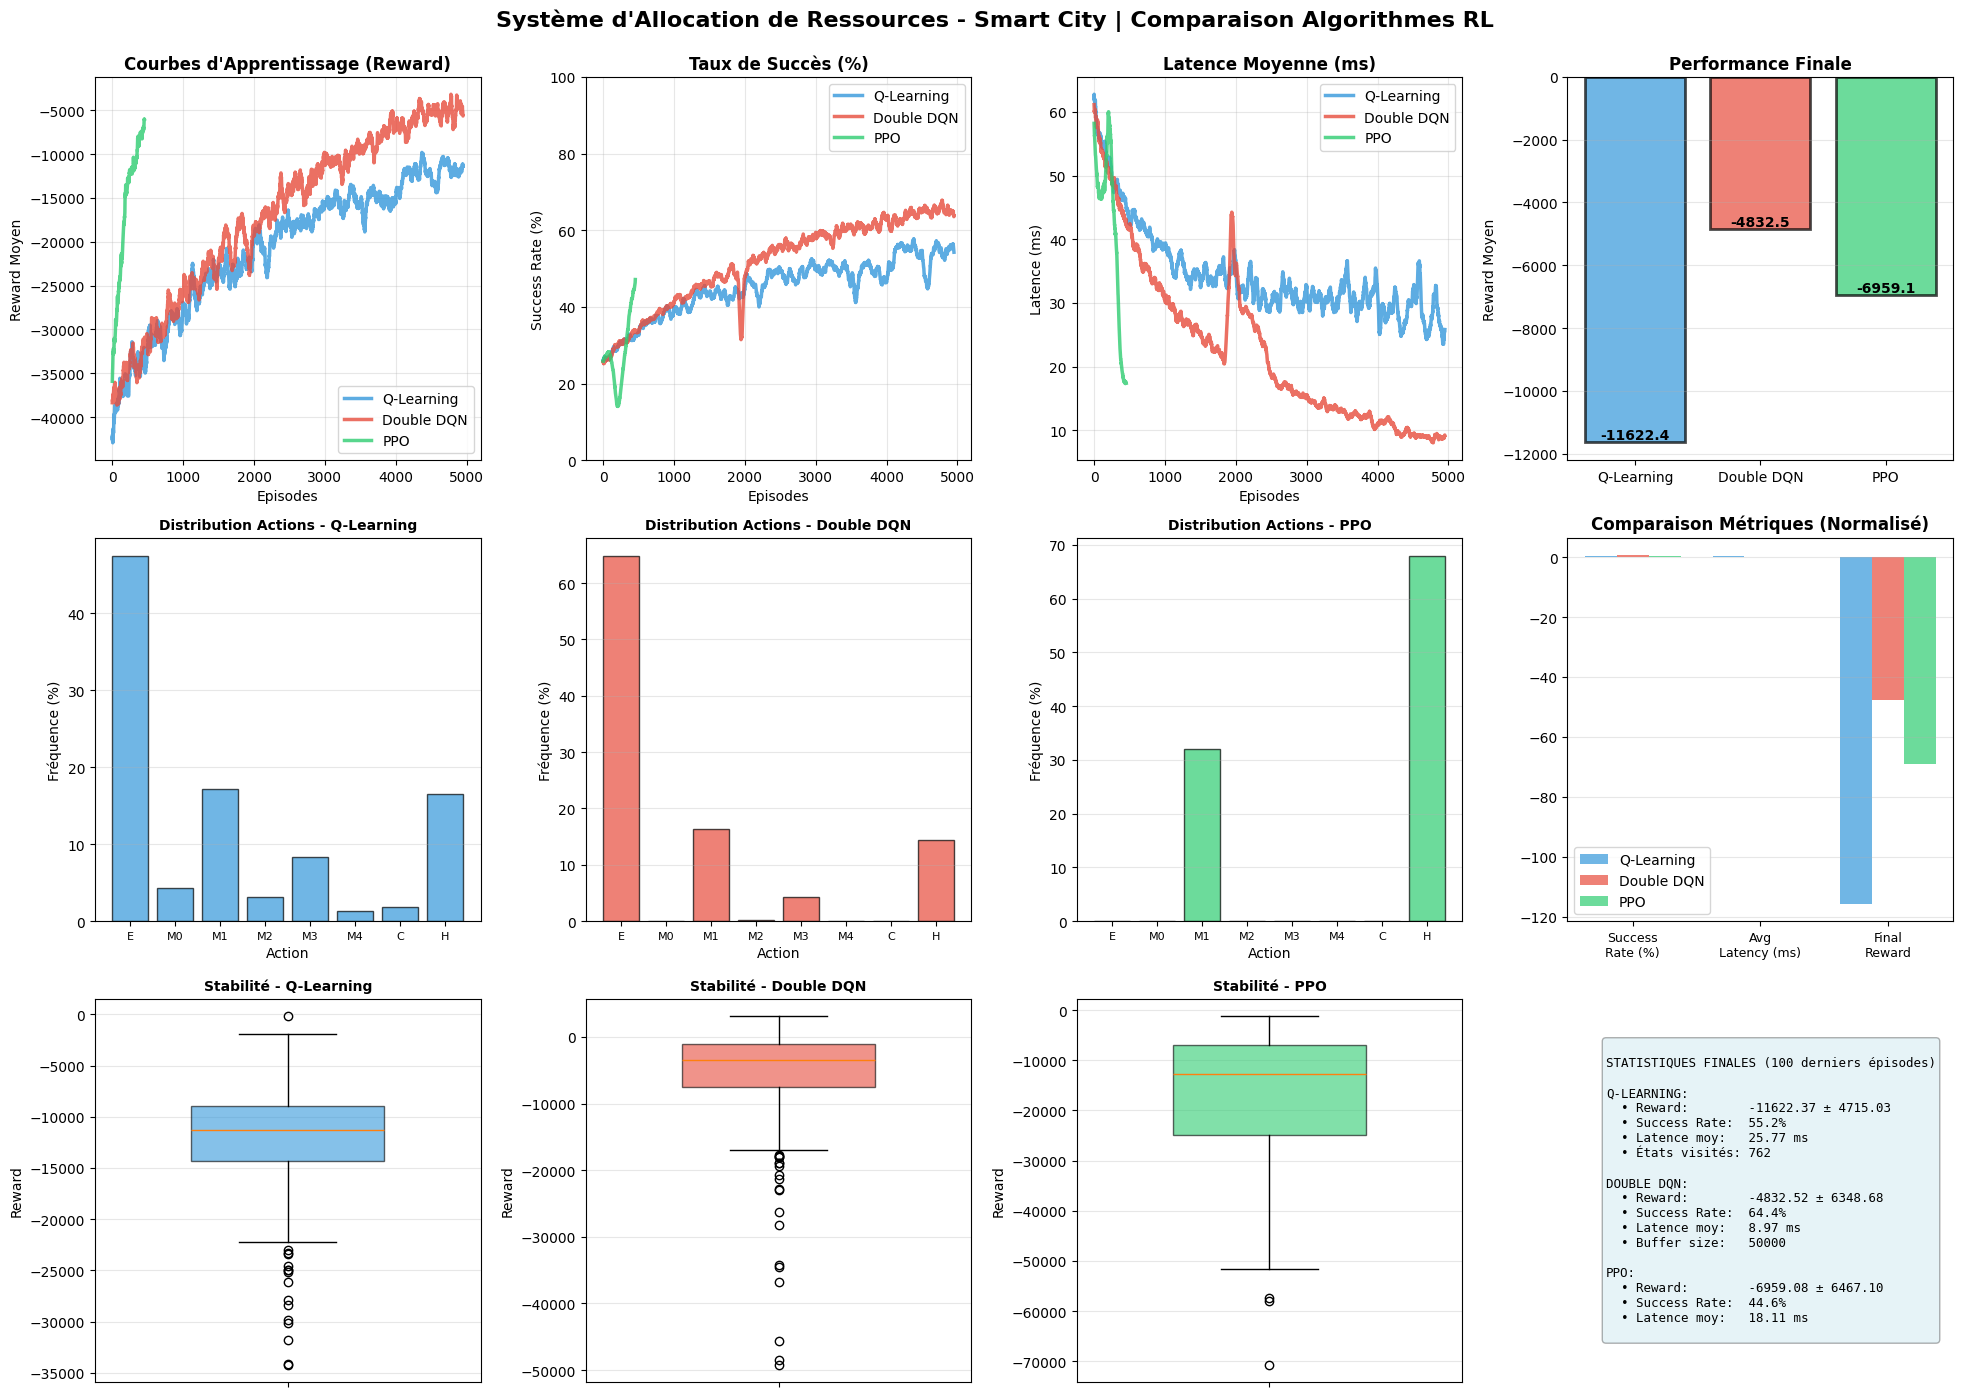


✅ ENTRAÎNEMENT TERMINÉ!

📊 RÉSULTATS FINAUX:
  Q-Learning:  -11622.37 reward | 55.2% success
  Double DQN:  -4832.52 reward | 64.4% success
  PPO:         -6959.08 reward | 44.6% success



In [ ]:
"""
Système d'Allocation de Ressources pour Smart City
Projet de Fin d'Études - École d'Ingénieur

Architecture:
- 5 quartiers avec infrastructure MEC dédiée
- 1000+ utilisateurs mobiles (IoT, véhicules autonomes, AR/VR)
- 3 niveaux: Edge (Local), Fog (MEC), Cloud
- Optimisation multi-objectifs: latence, énergie, coût, QoS

Algorithmes: Q-Learning, Double DQN, PPO
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Stable Baselines
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env

# Configuration
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


# ==========================================
# 1. ARCHITECTURE DE LA SMART CITY
# ==========================================

@dataclass
class UserProfile:
    """Profil utilisateur avec exigences QoS"""
    user_id: int
    user_type: str  # 'IoT', 'Vehicle', 'AR_VR', 'Mobile', 'Industrial'
    location: Tuple[float, float]  # (x, y) coordonnées
    district_id: int  # Quartier (0-4)
    priority: int  # 1-5 (5 = critique)
    max_latency: float  # ms
    bandwidth_req: float  # Mbps
    energy_budget: float  # mW
    mobility: float  # km/h (vitesse de déplacement)

@dataclass
class MECServer:
    """Serveur MEC au niveau quartier"""
    mec_id: int
    district_id: int
    cpu_cores: int
    gpu_available: bool
    ram_gb: int
    storage_tb: int
    max_bandwidth: float  # Gbps
    current_load: float  # 0-1
    energy_efficiency: float  # GFLOPS/W
    location: Tuple[float, float]

@dataclass
class CloudDatacenter:
    """Datacenter Cloud centralisé"""
    cpu_clusters: int
    gpu_clusters: int
    ram_tb: int
    storage_pb: int
    max_bandwidth: float  # Tbps
    current_load: float
    distance_from_city: float  # km
    latency_base: float  # ms

class SmartCityTopology:
    """Topologie complète de la Smart City"""

    def __init__(self):
        # Configuration ville: 5 quartiers
        self.districts = {
            0: {"name": "Centre-Ville", "area_km2": 4, "population": 50000, "type": "commercial"},
            1: {"name": "Zone Industrielle", "area_km2": 8, "population": 10000, "type": "industrial"},
            2: {"name": "Quartier Résidentiel Nord", "area_km2": 6, "population": 80000, "type": "residential"},
            3: {"name": "Quartier Résidentiel Sud", "area_km2": 6, "population": 75000, "type": "residential"},
            4: {"name": "Campus Universitaire", "area_km2": 3, "population": 30000, "type": "educational"}
        }

        # Initialisation infrastructure MEC (1 par quartier)
        self.mec_servers = self._init_mec_infrastructure()

        # Cloud datacenter (unique, distant)
        self.cloud = CloudDatacenter(
            cpu_clusters=1000,
            gpu_clusters=200,
            ram_tb=500,
            storage_pb=10,
            max_bandwidth=100.0,  # 100 Tbps
            current_load=0.3,
            distance_from_city=50.0,  # 50km du centre
            latency_base=15.0  # 15ms base
        )

        # Capacités Edge (dispositifs locaux)
        self.edge_capacities = {
            'IoT': {'cpu_ghz': 0.5, 'ram_mb': 512, 'energy_mw': 50},
            'Mobile': {'cpu_ghz': 2.0, 'ram_mb': 4096, 'energy_mw': 500},
            'Vehicle': {'cpu_ghz': 8.0, 'ram_mb': 16384, 'energy_mw': 2000},
            'AR_VR': {'cpu_ghz': 4.0, 'ram_mb': 8192, 'energy_mw': 1000},
            'Industrial': {'cpu_ghz': 16.0, 'ram_mb': 32768, 'energy_mw': 5000}
        }

    def _init_mec_infrastructure(self) -> List[MECServer]:
        """Initialise les serveurs MEC par quartier"""
        mecs = []
        configs = [
            # Centre-Ville: haute performance
            {'cpu': 64, 'gpu': True, 'ram': 256, 'storage': 10, 'bw': 10.0, 'efficiency': 50},
            # Zone Industrielle: très haute puissance
            {'cpu': 128, 'gpu': True, 'ram': 512, 'storage': 50, 'bw': 20.0, 'efficiency': 40},
            # Résidentiel Nord: équilibré
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            # Résidentiel Sud: équilibré
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            # Campus: recherche et calcul
            {'cpu': 96, 'gpu': True, 'ram': 384, 'storage': 20, 'bw': 15.0, 'efficiency': 60}
        ]

        for i, config in enumerate(configs):
            mecs.append(MECServer(
                mec_id=i,
                district_id=i,
                cpu_cores=config['cpu'],
                gpu_available=config['gpu'],
                ram_gb=config['ram'],
                storage_tb=config['storage'],
                max_bandwidth=config['bw'],
                current_load=np.random.uniform(0.2, 0.5),
                energy_efficiency=config['efficiency'],
                location=(i*2.0, i*1.5)  # Positions géographiques
            ))
        return mecs

    def generate_user(self, user_id: int) -> UserProfile:
        """Génère un utilisateur aléatoire avec profil réaliste"""
        user_types = ['IoT', 'Mobile', 'Vehicle', 'AR_VR', 'Industrial']
        weights = [0.4, 0.3, 0.15, 0.1, 0.05]  # Distribution réaliste

        user_type = np.random.choice(user_types, p=weights)
        district_id = np.random.randint(0, 5)

        # Caractéristiques selon le type
        profiles = {
            'IoT': {'priority': 2, 'latency': 200, 'bandwidth': 0.5, 'energy': 100, 'mobility': 0},
            'Mobile': {'priority': 3, 'latency': 100, 'bandwidth': 5, 'energy': 1000, 'mobility': 5},
            'Vehicle': {'priority': 5, 'latency': 10, 'bandwidth': 50, 'energy': 5000, 'mobility': 60},
            'AR_VR': {'priority': 4, 'latency': 20, 'bandwidth': 100, 'energy': 2000, 'mobility': 3},
            'Industrial': {'priority': 5, 'latency': 50, 'bandwidth': 20, 'energy': 10000, 'mobility': 0}
        }

        profile = profiles[user_type]

        return UserProfile(
            user_id=user_id,
            user_type=user_type,
            location=(np.random.uniform(0, 10), np.random.uniform(0, 10)),
            district_id=district_id,
            priority=profile['priority'],
            max_latency=profile['latency'] * np.random.uniform(0.8, 1.2),
            bandwidth_req=profile['bandwidth'] * np.random.uniform(0.7, 1.3),
            energy_budget=profile['energy'],
            mobility=profile['mobility'] * np.random.uniform(0.5, 1.5)
        )


# ==========================================
# 2. MODÈLE DE TÂCHES RÉALISTES
# ==========================================

@dataclass
class ComputeTask:
    """Tâche de calcul avec exigences détaillées"""
    task_id: int
    user: UserProfile
    task_type: str  # 'stream', 'compute', 'storage', 'realtime'
    workload_mips: float  # Millions d'instructions
    data_size_mb: float
    priority: int
    deadline_ms: float
    splittable: bool  # Peut être divisée entre plusieurs niveaux
    gpu_required: bool

class TaskGenerator:
    """Générateur de tâches réalistes"""

    def __init__(self, topology: SmartCityTopology):
        self.topology = topology
        self.task_counter = 0

    def generate_task(self, user: UserProfile) -> ComputeTask:
        """Génère une tâche basée sur le profil utilisateur"""

        task_distributions = {
            'IoT': [
                {'type': 'stream', 'mips': 100, 'data': 0.1, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 500, 'data': 1, 'gpu': False, 'split': True}
            ],
            'Mobile': [
                {'type': 'stream', 'mips': 1000, 'data': 5, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 2000, 'data': 10, 'gpu': True, 'split': True}
            ],
            'Vehicle': [
                {'type': 'realtime', 'mips': 5000, 'data': 50, 'gpu': True, 'split': False},
                {'type': 'compute', 'mips': 8000, 'data': 100, 'gpu': True, 'split': True}
            ],
            'AR_VR': [
                {'type': 'realtime', 'mips': 10000, 'data': 200, 'gpu': True, 'split': False},
                {'type': 'stream', 'mips': 5000, 'data': 100, 'gpu': True, 'split': False}
            ],
            'Industrial': [
                {'type': 'compute', 'mips': 50000, 'data': 500, 'gpu': True, 'split': True},
                {'type': 'storage', 'mips': 1000, 'data': 1000, 'gpu': False, 'split': True}
            ]
        }

        task_template = random.choice(task_distributions[user.user_type])

        self.task_counter += 1
        return ComputeTask(
            task_id=self.task_counter,
            user=user,
            task_type=task_template['type'],
            workload_mips=task_template['mips'] * np.random.uniform(0.8, 1.2),
            data_size_mb=task_template['data'] * np.random.uniform(0.7, 1.3),
            priority=user.priority,
            deadline_ms=user.max_latency,
            splittable=task_template['split'],
            gpu_required=task_template['gpu']
        )


# ==========================================
# 3. ENVIRONNEMENT GYMNASIUM AVANCÉ
# ==========================================

class SmartCityResourceEnv(gym.Env):
    """Environnement d'allocation de ressources pour Smart City - VERSION DIFFICILE"""

    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, num_users: int = 200, max_steps: int = 500):
        super().__init__()

        self.topology = SmartCityTopology()
        self.task_generator = TaskGenerator(self.topology)
        self.num_users = num_users  # AUGMENTÉ: plus d'utilisateurs
        self.max_steps_per_episode = max_steps

        # NOUVEAU: Congestion et interférences
        self.network_congestion = 0.0  # 0-1
        self.interference_level = 0.0  # 0-1

        # NOUVEAU: Événements dynamiques
        self.event_active = False
        self.event_type = None  # 'rush_hour', 'emergency', 'festival', 'maintenance'
        self.event_district = None

        # Espace d'actions: 8 actions possibles
        # 0: Edge Local
        # 1-5: MEC du quartier 0-4
        # 6: Cloud
        # 7: Offload hybride (Edge + MEC)
        self.action_space = spaces.Discrete(8)

        # Espace d'observations (16 features) - ÉTENDU
        self.observation_space = spaces.Box(
            low=np.array([
                0,      # task_workload (normalized)
                0,      # data_size (normalized)
                1,      # priority (1-5)
                0,      # deadline (normalized)
                0,      # user_district (0-4)
                0,      # user_type (0-4)
                0,      # mec_load_local (0-1)
                0,      # mec_load_avg (0-1)
                0,      # cloud_load (0-1)
                0,      # time_of_day (0-1)
                0,      # mobility (normalized)
                0,      # gpu_required (0-1)
                0,      # network_congestion (0-1) - NOUVEAU
                0,      # interference_level (0-1) - NOUVEAU
                0,      # event_active (0-1) - NOUVEAU
                0       # consecutive_failures (normalized) - NOUVEAU
            ], dtype=np.float32),
            high=np.array([1, 1, 5, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
            dtype=np.float32
        )

        # État interne
        self.users = []
        self.current_task = None
        self.steps_count = 0
        self.time_of_day = 0.5  # 0=minuit, 0.5=midi, 1=minuit

        # Métriques de performance
        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0
        self.consecutive_failures = 0  # NOUVEAU: pénalité cumulative

        # NOUVEAU: Limites strictes des ressources
        self.mec_overload_penalty = {}
        for i in range(5):
            self.mec_overload_penalty[i] = 0

        # Normalisation
        self.max_workload = 50000
        self.max_data_size = 1000
        self.max_deadline = 200
        self.max_mobility = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Réinitialisation
        self.steps_count = 0
        self.time_of_day = np.random.uniform(0, 1)
        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0
        self.consecutive_failures = 0
        self.network_congestion = 0.0
        self.interference_level = 0.0
        self.event_active = False

        # Reset MEC overload
        for i in range(5):
            self.mec_overload_penalty[i] = 0

        # Génération utilisateurs (AUGMENTÉ)
        self.users = [self.topology.generate_user(i) for i in range(self.num_users)]

        # Mise à jour charges MEC avec surcharge initiale
        self._update_infrastructure_loads()

        # NOUVEAU: Démarrer avec congestion aléatoire
        self.network_congestion = np.random.uniform(0.3, 0.7)
        self.interference_level = np.random.uniform(0.2, 0.5)

        # Génération première tâche
        self.current_task = self._generate_next_task()

        return self._get_observation(), {}

    def _update_infrastructure_loads(self):
        """Met à jour les charges selon l'heure, la demande ET les événements"""
        # Modèle réaliste: PICS TRÈS ÉLEVÉS pendant heures de pointe
        # 8h-10h et 17h-20h = rush hour
        hour = self.time_of_day * 24

        if (8 <= hour <= 10) or (17 <= hour <= 20):
            load_factor = 0.7 + 0.3 * np.random.random()  # 70-100% de charge
            self.network_congestion = min(1.0, self.network_congestion + 0.05)
        elif (12 <= hour <= 14):
            load_factor = 0.5 + 0.3 * np.random.random()  # Pause déjeuner
        else:
            load_factor = 0.2 + 0.3 * np.random.random()  # Charge normale

        # ÉVÉNEMENTS ALÉATOIRES (10% de chance par update)
        if np.random.random() < 0.1:
            self._trigger_random_event()

        for mec in self.topology.mec_servers:
            base_load = 0.4 if self.topology.districts[mec.district_id]['type'] == 'industrial' else 0.3

            # Charge additionnelle si événement dans le quartier
            event_load = 0.0
            if self.event_active and self.event_district == mec.district_id:
                if self.event_type == 'emergency':
                    event_load = 0.5  # Urgence = surcharge massive
                elif self.event_type == 'festival':
                    event_load = 0.4  # Festival = beaucoup de monde
                elif self.event_type == 'maintenance':
                    event_load = -0.2  # Maintenance = capacité réduite

            # Application surcharge cumulative (pénalité si MEC trop utilisé)
            overload_penalty = self.mec_overload_penalty[mec.district_id]

            mec.current_load = base_load + load_factor + event_load + overload_penalty
            mec.current_load = np.clip(mec.current_load, 0.1, 1.0)

        # Cloud aussi surchargé pendant pics
        self.topology.cloud.current_load = 0.5 + load_factor * 0.4
        self.topology.cloud.current_load = np.clip(self.topology.cloud.current_load, 0.2, 1.0)

        # Interférences augmentent avec la congestion
        self.interference_level = 0.2 + self.network_congestion * 0.6

    def _trigger_random_event(self):
        """Déclenche un événement aléatoire dans la ville"""
        if not self.event_active:
            self.event_active = True
            self.event_type = np.random.choice(['emergency', 'festival', 'rush_hour', 'maintenance'])
            self.event_district = np.random.randint(0, 5)

            # L'événement dure un certain temps
            self.event_duration = np.random.randint(20, 50)
        else:
            self.event_duration -= 1
            if self.event_duration <= 0:
                self.event_active = False
                self.event_type = None

    def _generate_next_task(self) -> ComputeTask:
        """Génère la prochaine tâche"""
        user = random.choice(self.users)
        return self.task_generator.generate_task(user)

    def _get_observation(self) -> np.ndarray:
        """Construit le vecteur d'observation - VERSION ÉTENDUE"""
        task = self.current_task
        user = task.user

        # Mapping types
        type_map = {'IoT': 0, 'Mobile': 1, 'Vehicle': 2, 'AR_VR': 3, 'Industrial': 4}

        # Charge MEC locale et moyenne
        local_mec = self.topology.mec_servers[user.district_id]
        avg_mec_load = np.mean([m.current_load for m in self.topology.mec_servers])

        obs = np.array([
            task.workload_mips / self.max_workload,
            task.data_size_mb / self.max_data_size,
            task.priority,
            task.deadline_ms / self.max_deadline,
            user.district_id / 4.0,
            type_map[user.user_type] / 4.0,
            local_mec.current_load,
            avg_mec_load,
            self.topology.cloud.current_load,
            self.time_of_day,
            user.mobility / self.max_mobility,
            1.0 if task.gpu_required else 0.0,
            self.network_congestion,  # NOUVEAU
            self.interference_level,   # NOUVEAU
            1.0 if self.event_active else 0.0,  # NOUVEAU
            min(self.consecutive_failures / 10.0, 1.0)  # NOUVEAU
        ], dtype=np.float32)

        return obs

    def _compute_latency(self, task: ComputeTask, action: int) -> float:
        """Calcule la latence totale avec CONGESTION et INTERFÉRENCES"""
        user = task.user

        # NOUVEAU: Facteurs de dégradation
        congestion_factor = 1.0 + self.network_congestion * 2.0  # x1 à x3
        interference_factor = 1.0 + self.interference_level * 1.5  # x1 à x2.5

        # Latence réseau (AUGMENTÉE et variable)
        if action == 0:  # Edge
            network_latency = 0
        elif 1 <= action <= 5:  # MEC
            mec = self.topology.mec_servers[action - 1]
            distance = np.sqrt((user.location[0] - mec.location[0])**2 +
                              (user.location[1] - mec.location[1])**2)

            # Distance + congestion + interférences + charge réseau
            base_latency = 5 + distance * 2.0  # Augmenté de 0.5 à 2.0
            network_latency = base_latency * congestion_factor * interference_factor

            # NOUVEAU: Si MEC cross-district, latence encore plus élevée
            if mec.district_id != user.district_id:
                network_latency *= 1.8

        elif action == 6:  # Cloud
            base_latency = self.topology.cloud.latency_base + np.random.uniform(10, 25)
            network_latency = base_latency * congestion_factor * interference_factor
        else:  # Hybrid
            network_latency = (3 + np.random.uniform(2, 5)) * congestion_factor

        # Latence de calcul (dépend FORTEMENT de la charge)
        if action == 0:  # Edge
            edge_power = self.topology.edge_capacities[user.user_type]['cpu_ghz']
            # Edge peut être dépassé facilement
            compute_latency = task.workload_mips / (edge_power * 800)  # Réduit de 1000 à 800
        elif 1 <= action <= 5:  # MEC
            mec = self.topology.mec_servers[action - 1]

            # CRITIQUE: La charge dégrade FORTEMENT les performances
            load_penalty = 1.0 + (mec.current_load ** 2) * 3.0  # Quadratique!
            effective_power = mec.cpu_cores * 2.5 / load_penalty  # Réduit de 3.0 à 2.5
            compute_latency = task.workload_mips / (effective_power * 1000)

            # Pénalité GPU si requis mais MEC surchargé
            if task.gpu_required and mec.current_load > 0.7:
                compute_latency *= 1.5

        elif action == 6:  # Cloud
            # Cloud aussi affecté par sa charge
            load_penalty = 1.0 + (self.topology.cloud.current_load ** 2) * 2.0
            effective_power = 800 / load_penalty  # Réduit de 1000 à 800
            compute_latency = task.workload_mips / (effective_power * 1000)
        else:  # Hybrid
            compute_latency = task.workload_mips / (6000)  # Réduit de 8000 à 6000

        # Latence transmission données (AUGMENTÉE)
        data_latency = task.data_size_mb * 0.3 * congestion_factor  # Augmenté de 0.1 à 0.3

        total_latency = network_latency + compute_latency + data_latency

        # NOUVEAU: Latence minimale réaliste
        total_latency = max(total_latency, 1.0)

        return total_latency

    def _compute_energy(self, task: ComputeTask, action: int, latency: float) -> float:
        """Calcule la consommation énergétique (mJ)"""
        user = task.user

        if action == 0:  # Edge
            power = self.topology.edge_capacities[user.user_type]['energy_mw']
            energy = power * latency  # mJ
        elif 1 <= action <= 5:  # MEC
            mec = self.topology.mec_servers[action - 1]
            # Énergie transmission + calcul
            transmission_energy = task.data_size_mb * 10  # 10mJ/MB
            compute_power = (mec.cpu_cores * 50) / mec.energy_efficiency
            compute_energy = compute_power * latency
            energy = transmission_energy + compute_energy
        elif action == 6:  # Cloud
            transmission_energy = task.data_size_mb * 50  # Plus coûteux
            compute_energy = 100 * latency  # Datacenter distant
            energy = transmission_energy + compute_energy
        else:  # Hybrid
            energy = (self.topology.edge_capacities[user.user_type]['energy_mw'] * latency * 0.6 +
                     task.data_size_mb * 5)

        return energy

    def _compute_cost(self, task: ComputeTask, action: int) -> float:
        """Calcule le coût monétaire (unités arbitraires)"""
        if action == 0:  # Edge: gratuit
            return 0
        elif 1 <= action <= 5:  # MEC: coût modéré
            return task.workload_mips * 0.001 + task.data_size_mb * 0.01
        elif action == 6:  # Cloud: coût élevé
            return task.workload_mips * 0.005 + task.data_size_mb * 0.05
        else:  # Hybrid
            return task.workload_mips * 0.0015 + task.data_size_mb * 0.02

    def step(self, action: int):
        self.steps_count += 1
        task = self.current_task
        user = task.user

        # Vérifications de faisabilité STRICTES
        feasible = True
        failure_reason = ""

        # Vérification GPU
        if task.gpu_required:
            if action == 0:  # Edge n'a généralement pas de GPU
                if user.user_type not in ['Vehicle', 'AR_VR', 'Industrial']:
                    feasible = False
                    failure_reason = "GPU non disponible sur Edge"
            elif 1 <= action <= 5:
                mec = self.topology.mec_servers[action - 1]
                if not mec.gpu_available:
                    feasible = False
                    failure_reason = "GPU non disponible sur MEC"
                # NOUVEAU: GPU disponible mais MEC trop chargé
                elif mec.current_load > 0.85:
                    feasible = False
                    failure_reason = "MEC GPU surchargé"

        # NOUVEAU: Vérification capacité STRICTE
        if action == 0:
            edge_cap = self.topology.edge_capacities[user.user_type]['cpu_ghz'] * 1000
            if task.workload_mips > edge_cap * 1.5:  # Réduit de 2 à 1.5
                feasible = False
                failure_reason = "Capacité Edge insuffisante"
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            # NOUVEAU: MEC refuse si trop chargé (>95%)
            if mec.current_load > 0.95:
                feasible = False
                failure_reason = f"MEC_{mec.district_id} saturé"
            # Ajouter pénalité surcharge
            if mec.current_load > 0.8:
                self.mec_overload_penalty[mec.district_id] = min(
                    self.mec_overload_penalty[mec.district_id] + 0.02, 0.3
                )

        # NOUVEAU: Probabilité de panne réseau pendant congestion
        if self.network_congestion > 0.8 and np.random.random() < 0.15:
            feasible = False
            failure_reason = "Panne réseau (congestion)"

        # Calcul métriques
        latency = self._compute_latency(task, action)
        energy = self._compute_energy(task, action, latency)
        cost = self._compute_cost(task, action)

        # Vérification deadline STRICTE
        meets_deadline = latency <= task.deadline_ms

        # NOUVEAU: Calcul récompense BEAUCOUP PLUS PÉNALISANTE
        reward = 0
        success = feasible and meets_deadline

        if not feasible:
            reward = -15.0  # Augmenté de -10 à -15
            self.failed_tasks += 1
            self.consecutive_failures += 1

        elif not meets_deadline:
            # Pénalité EXPONENTIELLE selon dépassement
            overshoot = (latency - task.deadline_ms) / task.deadline_ms
            reward = -8.0 * (1 + overshoot) ** 1.5  # Pénalité exponentielle
            self.qos_violations += 1
            self.failed_tasks += 1
            self.consecutive_failures += 1

        else:
            # Récompense SUCCESS mais MODÉRÉE
            priority_weight = task.priority / 5.0

            # Bonus latence (plus strict)
            latency_ratio = latency / task.deadline_ms
            if latency_ratio < 0.5:
                latency_bonus = 5.0  # Excellent
            elif latency_ratio < 0.7:
                latency_bonus = 3.0  # Bon
            elif latency_ratio < 0.9:
                latency_bonus = 1.0  # Acceptable
            else:
                latency_bonus = 0.0  # Juste dans les temps

            # Pénalité énergie (plus sévère)
            energy_penalty = energy / 5000.0  # Augmenté

            # Pénalité coût (plus sévère)
            cost_penalty = cost * 0.5  # Augmenté de 0.1 à 0.5

            # Bonus actions efficaces (réduit)
            action_bonus = 0
            if action == 0:  # Edge
                action_bonus = 3.0  # Toujours favoriser Edge si possible
            elif 1 <= action <= 5:  # MEC
                mec = self.topology.mec_servers[action - 1]
                if mec.district_id == user.district_id:
                    action_bonus = 2.0  # Bonus si MEC local
                else:
                    action_bonus = 0.5  # Pénalité si cross-district
            elif action == 7:  # Hybrid
                action_bonus = 1.5
            else:  # Cloud
                action_bonus = -1.0  # Pénalité cloud

            # NOUVEAU: Bonus si rompt série d'échecs
            consecutive_bonus = 0
            if self.consecutive_failures > 5:
                consecutive_bonus = 2.0

            reward = (
                8.0 * priority_weight +  # Réduit de 10 à 8
                latency_bonus * 1.5 -
                energy_penalty * 1.0 -  # Augmenté de 0.5 à 1.0
                cost_penalty -
                self.network_congestion * 2.0 +  # NOUVEAU: Pénalité congestion
                action_bonus +
                consecutive_bonus
            )

            self.successful_tasks += 1
            self.total_energy_consumed += energy
            self.total_latency += latency
            self.consecutive_failures = 0  # Reset

        # Informations détaillées
        info = {
            'success': success,
            'latency_ms': latency,
            'energy_mj': energy,
            'cost': cost,
            'action_name': ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid'][action],
            'task_type': task.task_type,
            'user_type': user.user_type,
            'priority': task.priority,
            'meets_deadline': meets_deadline,
            'failure_reason': failure_reason if not feasible else None,
            'network_congestion': self.network_congestion,
            'consecutive_failures': self.consecutive_failures,
            'event_active': self.event_active
        }

        # Mise à jour temporelle (plus rapide pour événements dynamiques)
        self.time_of_day = (self.time_of_day + 0.002) % 1.0  # Augmenté de 0.001 à 0.002

        # Update infrastructure plus fréquent
        if self.steps_count % 25 == 0:  # Réduit de 50 à 25
            self._update_infrastructure_loads()

        # NOUVEAU: Congestion évolue dynamiquement
        if success:
            self.network_congestion = max(0, self.network_congestion - 0.01)
        else:
            self.network_congestion = min(1, self.network_congestion + 0.02)

        # Génération nouvelle tâche
        self.current_task = self._generate_next_task()

        # Terminal conditions
        terminated = False
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return self._get_observation(), reward, terminated, truncated, info


# ==========================================
# 4. AGENTS D'APPRENTISSAGE
# ==========================================

class QLearningSmartCity:
    """Q-Learning avec state aggregation intelligent"""

    def __init__(self, n_actions=8):
        self.n_actions = n_actions
        self.lr = 0.05
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.9995
        self.q_table = {}

    def _discretize_state(self, obs):
        """Discrétisation intelligente de l'état - ÉTENDUE"""
        workload_bin = min(int(obs[0] * 10), 9)
        deadline_bin = min(int(obs[3] * 5), 4)
        priority = int(obs[2])
        district = int(obs[4] * 4)
        user_type = int(obs[5] * 4)
        mec_load_bin = min(int(obs[6] * 3), 2)
        gpu_req = int(obs[11])
        congestion_bin = min(int(obs[12] * 3), 2)  # NOUVEAU
        event_active = int(obs[14])  # NOUVEAU

        return (workload_bin, deadline_bin, priority, district, user_type,
                mec_load_bin, gpu_req, congestion_bin, event_active)

    def get_q_values(self, obs):
        state_key = self._discretize_state(obs)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.get_q_values(obs)
        return int(np.argmax(q_values))

    def update(self, obs, action, reward, next_obs, done):
        current_q = self.get_q_values(obs)[action]

        if done:
            target = reward
        else:
            max_next_q = np.max(self.get_q_values(next_obs))
            target = reward + self.gamma * max_next_q

        state_key = self._discretize_state(obs)
        self.q_table[state_key][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class DoubleDQNNetwork(nn.Module):
    """Architecture profonde pour Double DQN - ÉTENDUE"""

    def __init__(self, state_dim=16, n_actions=8):  # state_dim passé de 12 à 16
        super().__init__()

        # Couches fully connected avec normalisation
        self.fc1 = nn.Linear(state_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions)

        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


class DoubleDQNAgent:
    """Double DQN avec Prioritized Experience Replay"""

    def __init__(self, state_dim=16, n_actions=8):  # state_dim passé de 12 à 16
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Réseaux
        self.q_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimiseur
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0005)

        # Replay buffer
        self.memory = deque(maxlen=50000)
        self.batch_size = 128
        self.gamma = 0.99

        # Exploration
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.9995

        # Target update
        self.target_update_freq = 200
        self.update_counter = 0

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)

        self.q_network.eval()
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            q_values = self.q_network(obs_tensor)
            action = int(q_values.argmax().item())
        self.q_network.train()

        return action

    def remember(self, obs, action, reward, next_obs, done):
        self.memory.append((obs, action, reward, next_obs, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        self.q_network.train()

        batch = random.sample(self.memory, self.batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)

        obs = torch.FloatTensor(np.array(obs)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_obs = torch.FloatTensor(np.array(next_obs)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(obs).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_obs).argmax(1)
            next_q = self.target_network(next_obs).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# ==========================================
# 5. ENTRAÎNEMENT
# ==========================================

def train_qlearning_smartcity(n_episodes=5000):  # Augmenté de 3000 à 5000
    """Entraînement Q-Learning - ENVIRONNEMENT DIFFICILE"""
    print("\n" + "="*80)
    print("ENTRAÎNEMENT Q-LEARNING - SMART CITY (MODE DIFFICILE)")
    print("="*80)

    env = SmartCityResourceEnv(num_users=200, max_steps=500)  # 200 users!
    agent = QLearningSmartCity()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.update(obs, action, reward, next_obs, done)
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f} | States: {len(agent.q_table)}")

    print(f"\nEntraînement terminé! États explorés: {len(agent.q_table)}")
    return agent, episode_rewards, success_rates, avg_latencies


def train_double_dqn_smartcity(n_episodes=5000):  # Augmenté de 3000 à 5000
    """Entraînement Double DQN - ENVIRONNEMENT DIFFICILE"""
    print("\n" + "="*80)
    print("ENTRAÎNEMENT DOUBLE DQN - SMART CITY (MODE DIFFICILE)")
    print("="*80)
    print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    env = SmartCityResourceEnv(num_users=200, max_steps=500)  # 200 users!
    agent = DoubleDQNAgent()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.remember(obs, action, reward, next_obs, done)
            agent.replay()
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f} | Buffer: {len(agent.memory)}")

    print("\nEntraînement terminé!")
    return agent, episode_rewards, success_rates, avg_latencies


class PPOCallback(BaseCallback):
    """Callback pour PPO avec métriques Smart City"""

    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.success_rates = []
        self.avg_latencies = []
        self.current_reward = 0
        self.current_successes = 0
        self.current_failures = 0
        self.current_latency = 0

    def _on_step(self):
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        info = self.locals.get('infos', [{}])[0]
        if info.get('success', False):
            self.current_successes += 1
            self.current_latency += info.get('latency_ms', 0)
        else:
            self.current_failures += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)

            total_tasks = self.current_successes + self.current_failures
            if total_tasks > 0:
                success_rate = (self.current_successes / total_tasks) * 100
                self.success_rates.append(success_rate)

            if self.current_successes > 0:
                avg_lat = self.current_latency / self.current_successes
                self.avg_latencies.append(avg_lat)

            self.current_reward = 0
            self.current_successes = 0
            self.current_failures = 0
            self.current_latency = 0

        return True


def train_ppo_smartcity(total_timesteps=250000):  # Augmenté de 150K à 250K
    """Entraînement PPO - ENVIRONNEMENT DIFFICILE"""
    print("\n" + "="*80)
    print("ENTRAÎNEMENT PPO - SMART CITY (MODE DIFFICILE)")
    print("="*80)

    env = make_vec_env(lambda: SmartCityResourceEnv(num_users=200, max_steps=500), n_envs=1)

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        gamma=0.99,
        batch_size=128,
        n_steps=2048,
        ent_coef=0.01,
        clip_range=0.2
    )

    callback = PPOCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    print("\nEntraînement terminé!")
    return model, callback.episode_rewards, callback.success_rates, callback.avg_latencies


# ==========================================
# 6. VISUALISATION AVANCÉE
# ==========================================

def plot_smartcity_results(q_results, dqn_results, ppo_results):
    """Visualisation complète des résultats"""

    q_agent, q_rewards, q_success, q_latency = q_results
    dqn_agent, dqn_rewards, dqn_success, dqn_latency = dqn_results
    ppo_model, ppo_rewards, ppo_success, ppo_latency = ppo_results

    fig = plt.figure(figsize=(20, 14))

    # 1. Courbes d'apprentissage (Reward)
    ax1 = plt.subplot(3, 4, 1)
    window = 50

    for rewards, color, label in [
        (q_rewards, '#3498db', 'Q-Learning'),
        (dqn_rewards, '#e74c3c', 'Double DQN'),
        (ppo_rewards, '#2ecc71', 'PPO')
    ]:
        if len(rewards) > window:
            smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax1.set_title("Courbes d'Apprentissage (Reward)", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward Moyen")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Taux de succès
    ax2 = plt.subplot(3, 4, 2)

    for success, color, label in [
        (q_success, '#3498db', 'Q-Learning'),
        (dqn_success, '#e74c3c', 'Double DQN'),
        (ppo_success, '#2ecc71', 'PPO')
    ]:
        if len(success) > window:
            smooth = np.convolve(success, np.ones(window)/window, mode='valid')
            ax2.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax2.set_title("Taux de Succès (%)", fontsize=12, fontweight='bold')
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Success Rate (%)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])

    # 3. Latence moyenne
    ax3 = plt.subplot(3, 4, 3)

    for latency, color, label in [
        (q_latency, '#3498db', 'Q-Learning'),
        (dqn_latency, '#e74c3c', 'Double DQN'),
        (ppo_latency, '#2ecc71', 'PPO')
    ]:
        if len(latency) > window:
            smooth = np.convolve(latency, np.ones(window)/window, mode='valid')
            ax3.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax3.set_title("Latence Moyenne (ms)", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Episodes")
    ax3.set_ylabel("Latence (ms)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Performance finale
    ax4 = plt.subplot(3, 4, 4)
    final_rewards = [
        np.mean(q_rewards[-100:]),
        np.mean(dqn_rewards[-100:]),
        np.mean(ppo_rewards[-100:])
    ]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax4.bar(['Q-Learning', 'Double DQN', 'PPO'], final_rewards,
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, score in zip(bars, final_rewards):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    ax4.set_title("Performance Finale", fontsize=12, fontweight='bold')
    ax4.set_ylabel("Reward Moyen")
    ax4.grid(True, axis='y', alpha=0.3)

    # 5-7. Distribution des actions
    env = SmartCityResourceEnv(num_users=100, max_steps=100)
    action_names = ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid']

    for idx, (agent, agent_type, title, color) in enumerate([
        (q_agent, 'q', 'Q-Learning', '#3498db'),
        (dqn_agent, 'dqn', 'Double DQN', '#e74c3c'),
        (ppo_model, 'ppo', 'PPO', '#2ecc71')
    ]):
        ax = plt.subplot(3, 4, 5 + idx)

        action_counts = np.zeros(8)
        obs, _ = env.reset()

        for _ in range(1000):
            if agent_type == 'ppo':
                action, _ = agent.predict(obs, deterministic=True)
                action = int(action)
            elif agent_type == 'dqn':
                action = agent.choose_action(obs, training=False)
            else:
                action = agent.choose_action(obs, training=False)

            action_counts[action] += 1
            obs, _, _, _, _ = env.step(action)

        action_counts = action_counts / action_counts.sum() * 100
        bars = ax.bar(range(8), action_counts, color=color, alpha=0.7, edgecolor='black')

        ax.set_title(f"Distribution Actions - {title}", fontsize=10, fontweight='bold')
        ax.set_xlabel("Action")
        ax.set_ylabel("Fréquence (%)")
        ax.set_xticks(range(8))
        ax.set_xticklabels(['E', 'M0', 'M1', 'M2', 'M3', 'M4', 'C', 'H'], fontsize=8)
        ax.grid(True, axis='y', alpha=0.3)

    # 8. Comparaison métriques
    ax8 = plt.subplot(3, 4, 8)
    metrics = ['Success\nRate (%)', 'Avg\nLatency (ms)', 'Final\nReward']

    q_metrics = [np.mean(q_success[-100:]), np.mean(q_latency[-100:]), np.mean(q_rewards[-100:])]
    dqn_metrics = [np.mean(dqn_success[-100:]), np.mean(dqn_latency[-100:]), np.mean(dqn_rewards[-100:])]
    ppo_metrics = [np.mean(ppo_success[-100:]), np.mean(ppo_latency[-100:]), np.mean(ppo_rewards[-100:])]

    x = np.arange(len(metrics))
    width = 0.25

    # Normalisation pour visualisation
    q_norm = [q_metrics[0]/100, q_metrics[1]/100, (q_metrics[2]+50)/100]
    dqn_norm = [dqn_metrics[0]/100, dqn_metrics[1]/100, (dqn_metrics[2]+50)/100]
    ppo_norm = [ppo_metrics[0]/100, ppo_metrics[1]/100, (ppo_metrics[2]+50)/100]

    ax8.bar(x - width, q_norm, width, label='Q-Learning', color='#3498db', alpha=0.7)
    ax8.bar(x, dqn_norm, width, label='Double DQN', color='#e74c3c', alpha=0.7)
    ax8.bar(x + width, ppo_norm, width, label='PPO', color='#2ecc71', alpha=0.7)

    ax8.set_title("Comparaison Métriques (Normalisé)", fontsize=12, fontweight='bold')
    ax8.set_xticks(x)
    ax8.set_xticklabels(metrics, fontsize=9)
    ax8.legend()
    ax8.grid(True, axis='y', alpha=0.3)

    # 9-11. Boxplots stabilité
    for idx, (rewards, title, color) in enumerate([
        (q_rewards, 'Q-Learning', '#3498db'),
        (dqn_rewards, 'Double DQN', '#e74c3c'),
        (ppo_rewards, 'PPO', '#2ecc71')
    ]):
        ax = plt.subplot(3, 4, 9 + idx)

        bp = ax.boxplot([rewards[-500:]], patch_artist=True, widths=0.5)
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        ax.set_title(f"Stabilité - {title}", fontsize=10, fontweight='bold')
        ax.set_ylabel("Reward")
        ax.set_xticklabels([''])
        ax.grid(True, axis='y', alpha=0.3)

    # 12. Statistiques finales
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')

    stats_text = f"""
STATISTIQUES FINALES (100 derniers épisodes)

Q-LEARNING:
  • Reward:        {np.mean(q_rewards[-100:]):.2f} ± {np.std(q_rewards[-100:]):.2f}
  • Success Rate:  {np.mean(q_success[-100:]):.1f}%
  • Latence moy:   {np.mean(q_latency[-100:]):.2f} ms
  • États visités: {len(q_agent.q_table)}

DOUBLE DQN:
  • Reward:        {np.mean(dqn_rewards[-100:]):.2f} ± {np.std(dqn_rewards[-100:]):.2f}
  • Success Rate:  {np.mean(dqn_success[-100:]):.1f}%
  • Latence moy:   {np.mean(dqn_latency[-100:]):.2f} ms
  • Buffer size:   {len(dqn_agent.memory)}

PPO:
  • Reward:        {np.mean(ppo_rewards[-100:]):.2f} ± {np.std(ppo_rewards[-100:]):.2f}
  • Success Rate:  {np.mean(ppo_success[-100:]):.1f}%
  • Latence moy:   {np.mean(ppo_latency[-100:]):.2f} ms
    """

    ax12.text(0.1, 0.5, stats_text, fontsize=9, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round',
             facecolor='lightblue', alpha=0.3))

    plt.suptitle("Système d'Allocation de Ressources - Smart City | Comparaison Algorithmes RL",
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('smartcity_rl_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Graphique sauvegardé: smartcity_rl_results.png")
    plt.show()


# ==========================================
# 7. MAIN - EXÉCUTION
# ==========================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print(" SYSTÈME D'ALLOCATION DE RESSOURCES POUR SMART CITY")
    print(" Projet de Fin d'Études - École d'Ingénieur")
    print(" VERSION DIFFICILE - Apprentissage Progressif")
    print("="*80)
    print("\n📊 ARCHITECTURE:")
    print("  • 5 Quartiers avec infrastructure MEC dédiée")
    print("  • 200 Utilisateurs simultanés (doublé!)")
    print("  • 3 Niveaux: Edge (Local) - Fog (MEC) - Cloud")
    print("  • 8 Actions possibles d'allocation")
    print("\n🔥 DÉFIS RÉALISTES:")
    print("  • Congestion réseau dynamique (30-100%)")
    print("  • Interférences sans fil variables")
    print("  • Heures de pointe (8-10h, 17-20h)")
    print("  • Événements aléatoires (urgences, festivals, maintenance)")
    print("  • Surcharge MEC cumulative")
    print("  • Latences augmentées x2-x3")
    print("  • Capacités réduites sous charge")
    print("\n⚠️ CONTRAINTES STRICTES:")
    print("  • MEC refuse >95% charge")
    print("  • Pannes réseau si congestion >80%")
    print("  • Pénalités exponentielles sur échecs")
    print("  • Deadline critiques pour véhicules autonomes")
    print("\n🎯 OBJECTIFS:")
    print("  • Minimiser la latence malgré congestion")
    print("  • Optimiser l'énergie sous contraintes")
    print("  • Respecter QoS avec ressources limitées")
    print("  • Maximiser taux de succès (cible: >70%)")
    print("\n🤖 ALGORITHMES:")
    print("  • Q-Learning (5000 épisodes)")
    print("  • Double DQN (5000 épisodes)")
    print("  • PPO (250K timesteps)")
    print("="*80 + "\n")

    # 1. Q-Learning
    print("\n🔵 Phase 1/3: Q-Learning")
    q_results = train_qlearning_smartcity(n_episodes=5000)

    # 2. Double DQN
    print("\n🔴 Phase 2/3: Double DQN")
    dqn_results = train_double_dqn_smartcity(n_episodes=5000)

    # 3. PPO
    print("\n🟢 Phase 3/3: PPO")
    ppo_results = train_ppo_smartcity(total_timesteps=250000)

    # 4. Visualisation
    print("\n📈 Génération des visualisations...")
    plot_smartcity_results(q_results, dqn_results, ppo_results)

    print("\n" + "="*80)
    print("✅ ENTRAÎNEMENT TERMINÉ!")
    print("="*80)
    print("\n📊 RÉSULTATS FINAUX:")
    print(f"  Q-Learning:  {np.mean(q_results[1][-100:]):.2f} reward | "
          f"{np.mean(q_results[2][-100:]):.1f}% success")
    print(f"  Double DQN:  {np.mean(dqn_results[1][-100:]):.2f} reward | "
          f"{np.mean(dqn_results[2][-100:]):.1f}% success")
    print(f"  PPO:         {np.mean(ppo_results[1][-100:]):.2f} reward | "
          f"{np.mean(ppo_results[2][-100:]):.1f}% success")
    print("="*80 + "\n")

In [ ]:
"""
Système d'Allocation de Ressources pour Smart City
VERSION AVEC REWARDS ÉQUILIBRÉS (départ ~ 0)

Modifications clés:
- Pénalités réduites: -3 (infeasible), -2 (deadline miss)
- Récompenses réduites: 1-3 (succès)
- Reward moyen par step proche de 0 au début
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Stable Baselines
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env

# Configuration
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


# ==========================================
# COPIER TOUT LE CODE DE L'ARCHITECTURE ICI
# (UserProfile, MECServer, CloudDatacenter, SmartCityTopology, ComputeTask, TaskGenerator)
# ==========================================

@dataclass
class UserProfile:
    """Profil utilisateur avec exigences QoS"""
    user_id: int
    user_type: str
    location: Tuple[float, float]
    district_id: int
    priority: int
    max_latency: float
    bandwidth_req: float
    energy_budget: float
    mobility: float

@dataclass
class MECServer:
    """Serveur MEC au niveau quartier"""
    mec_id: int
    district_id: int
    cpu_cores: int
    gpu_available: bool
    ram_gb: int
    storage_tb: int
    max_bandwidth: float
    current_load: float
    energy_efficiency: float
    location: Tuple[float, float]

@dataclass
class CloudDatacenter:
    """Datacenter Cloud centralisé"""
    cpu_clusters: int
    gpu_clusters: int
    ram_tb: int
    storage_pb: int
    max_bandwidth: float
    current_load: float
    distance_from_city: float
    latency_base: float

class SmartCityTopology:
    """Topologie complète de la Smart City"""

    def __init__(self):
        self.districts = {
            0: {"name": "Centre-Ville", "area_km2": 4, "population": 50000, "type": "commercial"},
            1: {"name": "Zone Industrielle", "area_km2": 8, "population": 10000, "type": "industrial"},
            2: {"name": "Quartier Résidentiel Nord", "area_km2": 6, "population": 80000, "type": "residential"},
            3: {"name": "Quartier Résidentiel Sud", "area_km2": 6, "population": 75000, "type": "residential"},
            4: {"name": "Campus Universitaire", "area_km2": 3, "population": 30000, "type": "educational"}
        }

        self.mec_servers = self._init_mec_infrastructure()

        self.cloud = CloudDatacenter(
            cpu_clusters=1000,
            gpu_clusters=200,
            ram_tb=500,
            storage_pb=10,
            max_bandwidth=100.0,
            current_load=0.3,
            distance_from_city=50.0,
            latency_base=15.0
        )

        self.edge_capacities = {
            'IoT': {'cpu_ghz': 0.5, 'ram_mb': 512, 'energy_mw': 50},
            'Mobile': {'cpu_ghz': 2.0, 'ram_mb': 4096, 'energy_mw': 500},
            'Vehicle': {'cpu_ghz': 8.0, 'ram_mb': 16384, 'energy_mw': 2000},
            'AR_VR': {'cpu_ghz': 4.0, 'ram_mb': 8192, 'energy_mw': 1000},
            'Industrial': {'cpu_ghz': 16.0, 'ram_mb': 32768, 'energy_mw': 5000}
        }

    def _init_mec_infrastructure(self) -> List[MECServer]:
        mecs = []
        configs = [
            {'cpu': 64, 'gpu': True, 'ram': 256, 'storage': 10, 'bw': 10.0, 'efficiency': 50},
            {'cpu': 128, 'gpu': True, 'ram': 512, 'storage': 50, 'bw': 20.0, 'efficiency': 40},
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            {'cpu': 96, 'gpu': True, 'ram': 384, 'storage': 20, 'bw': 15.0, 'efficiency': 60}
        ]

        for i, config in enumerate(configs):
            mecs.append(MECServer(
                mec_id=i,
                district_id=i,
                cpu_cores=config['cpu'],
                gpu_available=config['gpu'],
                ram_gb=config['ram'],
                storage_tb=config['storage'],
                max_bandwidth=config['bw'],
                current_load=np.random.uniform(0.2, 0.5),
                energy_efficiency=config['efficiency'],
                location=(i*2.0, i*1.5)
            ))
        return mecs

    def generate_user(self, user_id: int) -> UserProfile:
        user_types = ['IoT', 'Mobile', 'Vehicle', 'AR_VR', 'Industrial']
        weights = [0.4, 0.3, 0.15, 0.1, 0.05]

        user_type = np.random.choice(user_types, p=weights)
        district_id = np.random.randint(0, 5)

        profiles = {
            'IoT': {'priority': 2, 'latency': 200, 'bandwidth': 0.5, 'energy': 100, 'mobility': 0},
            'Mobile': {'priority': 3, 'latency': 100, 'bandwidth': 5, 'energy': 1000, 'mobility': 5},
            'Vehicle': {'priority': 5, 'latency': 10, 'bandwidth': 50, 'energy': 5000, 'mobility': 60},
            'AR_VR': {'priority': 4, 'latency': 20, 'bandwidth': 100, 'energy': 2000, 'mobility': 3},
            'Industrial': {'priority': 5, 'latency': 50, 'bandwidth': 20, 'energy': 10000, 'mobility': 0}
        }

        profile = profiles[user_type]

        return UserProfile(
            user_id=user_id,
            user_type=user_type,
            location=(np.random.uniform(0, 10), np.random.uniform(0, 10)),
            district_id=district_id,
            priority=profile['priority'],
            max_latency=profile['latency'] * np.random.uniform(0.8, 1.2),
            bandwidth_req=profile['bandwidth'] * np.random.uniform(0.7, 1.3),
            energy_budget=profile['energy'],
            mobility=profile['mobility'] * np.random.uniform(0.5, 1.5)
        )


@dataclass
class ComputeTask:
    """Tâche de calcul avec exigences détaillées"""
    task_id: int
    user: UserProfile
    task_type: str
    workload_mips: float
    data_size_mb: float
    priority: int
    deadline_ms: float
    splittable: bool
    gpu_required: bool

class TaskGenerator:
    """Générateur de tâches réalistes"""

    def __init__(self, topology: SmartCityTopology):
        self.topology = topology
        self.task_counter = 0

    def generate_task(self, user: UserProfile) -> ComputeTask:
        task_distributions = {
            'IoT': [
                {'type': 'stream', 'mips': 100, 'data': 0.1, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 500, 'data': 1, 'gpu': False, 'split': True}
            ],
            'Mobile': [
                {'type': 'stream', 'mips': 1000, 'data': 5, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 2000, 'data': 10, 'gpu': True, 'split': True}
            ],
            'Vehicle': [
                {'type': 'realtime', 'mips': 5000, 'data': 50, 'gpu': True, 'split': False},
                {'type': 'compute', 'mips': 8000, 'data': 100, 'gpu': True, 'split': True}
            ],
            'AR_VR': [
                {'type': 'realtime', 'mips': 10000, 'data': 200, 'gpu': True, 'split': False},
                {'type': 'stream', 'mips': 5000, 'data': 100, 'gpu': True, 'split': False}
            ],
            'Industrial': [
                {'type': 'compute', 'mips': 50000, 'data': 500, 'gpu': True, 'split': True},
                {'type': 'storage', 'mips': 1000, 'data': 1000, 'gpu': False, 'split': True}
            ]
        }

        task_template = random.choice(task_distributions[user.user_type])

        self.task_counter += 1
        return ComputeTask(
            task_id=self.task_counter,
            user=user,
            task_type=task_template['type'],
            workload_mips=task_template['mips'] * np.random.uniform(0.8, 1.2),
            data_size_mb=task_template['data'] * np.random.uniform(0.7, 1.3),
            priority=user.priority,
            deadline_ms=user.max_latency,
            splittable=task_template['split'],
            gpu_required=task_template['gpu']
        )


# ==========================================
# ENVIRONNEMENT AVEC REWARDS ÉQUILIBRÉS
# ==========================================

class SmartCityResourceEnv(gym.Env):
    """
    VERSION AVEC REWARDS ÉQUILIBRÉS
    - Pénalités plus douces
    - Récompenses modérées
    - Reward moyen par step ~ 0 au début
    """

    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, num_users: int = 200, max_steps: int = 500):
        super().__init__()

        self.topology = SmartCityTopology()
        self.task_generator = TaskGenerator(self.topology)
        self.num_users = num_users
        self.max_steps_per_episode = max_steps

        self.network_congestion = 0.0
        self.interference_level = 0.0

        self.event_active = False
        self.event_type = None
        self.event_district = None

        self.action_space = spaces.Discrete(8)

        self.observation_space = spaces.Box(
            low=np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([1, 1, 5, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
            dtype=np.float32
        )

        self.users = []
        self.current_task = None
        self.steps_count = 0
        self.time_of_day = 0.5

        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0
        self.consecutive_failures = 0

        self.mec_overload_penalty = {}
        for i in range(5):
            self.mec_overload_penalty[i] = 0

        self.max_workload = 50000
        self.max_data_size = 1000
        self.max_deadline = 200
        self.max_mobility = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.steps_count = 0
        self.time_of_day = np.random.uniform(0, 1)
        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0
        self.consecutive_failures = 0
        self.network_congestion = 0.0
        self.interference_level = 0.0
        self.event_active = False

        for i in range(5):
            self.mec_overload_penalty[i] = 0

        self.users = [self.topology.generate_user(i) for i in range(self.num_users)]

        self._update_infrastructure_loads()

        self.network_congestion = np.random.uniform(0.3, 0.7)
        self.interference_level = np.random.uniform(0.2, 0.5)

        self.current_task = self._generate_next_task()

        return self._get_observation(), {}

    def _update_infrastructure_loads(self):
        hour = self.time_of_day * 24

        if (8 <= hour <= 10) or (17 <= hour <= 20):
            load_factor = 0.7 + 0.3 * np.random.random()
            self.network_congestion = min(1.0, self.network_congestion + 0.05)
        elif (12 <= hour <= 14):
            load_factor = 0.5 + 0.3 * np.random.random()
        else:
            load_factor = 0.2 + 0.3 * np.random.random()

        if np.random.random() < 0.1:
            self._trigger_random_event()

        for mec in self.topology.mec_servers:
            base_load = 0.4 if self.topology.districts[mec.district_id]['type'] == 'industrial' else 0.3

            event_load = 0.0
            if self.event_active and self.event_district == mec.district_id:
                if self.event_type == 'emergency':
                    event_load = 0.5
                elif self.event_type == 'festival':
                    event_load = 0.4
                elif self.event_type == 'maintenance':
                    event_load = -0.2

            overload_penalty = self.mec_overload_penalty[mec.district_id]

            mec.current_load = base_load + load_factor + event_load + overload_penalty
            mec.current_load = np.clip(mec.current_load, 0.1, 1.0)

        self.topology.cloud.current_load = 0.5 + load_factor * 0.4
        self.topology.cloud.current_load = np.clip(self.topology.cloud.current_load, 0.2, 1.0)

        self.interference_level = 0.2 + self.network_congestion * 0.6

    def _trigger_random_event(self):
        if not self.event_active:
            self.event_active = True
            self.event_type = np.random.choice(['emergency', 'festival', 'rush_hour', 'maintenance'])
            self.event_district = np.random.randint(0, 5)
            self.event_duration = np.random.randint(20, 50)
        else:
            self.event_duration -= 1
            if self.event_duration <= 0:
                self.event_active = False
                self.event_type = None

    def _generate_next_task(self) -> ComputeTask:
        user = random.choice(self.users)
        return self.task_generator.generate_task(user)

    def _get_observation(self) -> np.ndarray:
        task = self.current_task
        user = task.user

        type_map = {'IoT': 0, 'Mobile': 1, 'Vehicle': 2, 'AR_VR': 3, 'Industrial': 4}

        local_mec = self.topology.mec_servers[user.district_id]
        avg_mec_load = np.mean([m.current_load for m in self.topology.mec_servers])

        obs = np.array([
            task.workload_mips / self.max_workload,
            task.data_size_mb / self.max_data_size,
            task.priority,
            task.deadline_ms / self.max_deadline,
            user.district_id / 4.0,
            type_map[user.user_type] / 4.0,
            local_mec.current_load,
            avg_mec_load,
            self.topology.cloud.current_load,
            self.time_of_day,
            user.mobility / self.max_mobility,
            1.0 if task.gpu_required else 0.0,
            self.network_congestion,
            self.interference_level,
            1.0 if self.event_active else 0.0,
            min(self.consecutive_failures / 10.0, 1.0)
        ], dtype=np.float32)

        return obs

    def _compute_latency(self, task: ComputeTask, action: int) -> float:
        user = task.user

        congestion_factor = 1.0 + self.network_congestion * 2.0
        interference_factor = 1.0 + self.interference_level * 1.5

        if action == 0:
            network_latency = 0
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            distance = np.sqrt((user.location[0] - mec.location[0])**2 +
                              (user.location[1] - mec.location[1])**2)

            base_latency = 5 + distance * 2.0
            network_latency = base_latency * congestion_factor * interference_factor

            if mec.district_id != user.district_id:
                network_latency *= 1.8

        elif action == 6:
            base_latency = self.topology.cloud.latency_base + np.random.uniform(10, 25)
            network_latency = base_latency * congestion_factor * interference_factor
        else:
            network_latency = (3 + np.random.uniform(2, 5)) * congestion_factor

        if action == 0:
            edge_power = self.topology.edge_capacities[user.user_type]['cpu_ghz']
            compute_latency = task.workload_mips / (edge_power * 800)
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]

            load_penalty = 1.0 + (mec.current_load ** 2) * 3.0
            effective_power = mec.cpu_cores * 2.5 / load_penalty
            compute_latency = task.workload_mips / (effective_power * 1000)

            if task.gpu_required and mec.current_load > 0.7:
                compute_latency *= 1.5

        elif action == 6:
            load_penalty = 1.0 + (self.topology.cloud.current_load ** 2) * 2.0
            effective_power = 800 / load_penalty
            compute_latency = task.workload_mips / (effective_power * 1000)
        else:
            compute_latency = task.workload_mips / (6000)

        data_latency = task.data_size_mb * 0.3 * congestion_factor

        total_latency = network_latency + compute_latency + data_latency
        total_latency = max(total_latency, 1.0)

        return total_latency

    def _compute_energy(self, task: ComputeTask, action: int, latency: float) -> float:
        user = task.user

        if action == 0:
            power = self.topology.edge_capacities[user.user_type]['energy_mw']
            energy = power * latency
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            transmission_energy = task.data_size_mb * 10
            compute_power = (mec.cpu_cores * 50) / mec.energy_efficiency
            compute_energy = compute_power * latency
            energy = transmission_energy + compute_energy
        elif action == 6:
            transmission_energy = task.data_size_mb * 50
            compute_energy = 100 * latency
            energy = transmission_energy + compute_energy
        else:
            energy = (self.topology.edge_capacities[user.user_type]['energy_mw'] * latency * 0.6 +
                     task.data_size_mb * 5)

        return energy

    def _compute_cost(self, task: ComputeTask, action: int) -> float:
        if action == 0:
            return 0
        elif 1 <= action <= 5:
            return task.workload_mips * 0.001 + task.data_size_mb * 0.01
        elif action == 6:
            return task.workload_mips * 0.005 + task.data_size_mb * 0.05
        else:
            return task.workload_mips * 0.0015 + task.data_size_mb * 0.02

    def step(self, action: int):
        self.steps_count += 1
        task = self.current_task
        user = task.user

        feasible = True
        failure_reason = ""

        if task.gpu_required:
            if action == 0:
                if user.user_type not in ['Vehicle', 'AR_VR', 'Industrial']:
                    feasible = False
                    failure_reason = "GPU non disponible sur Edge"
            elif 1 <= action <= 5:
                mec = self.topology.mec_servers[action - 1]
                if not mec.gpu_available:
                    feasible = False
                    failure_reason = "GPU non disponible sur MEC"
                elif mec.current_load > 0.85:
                    feasible = False
                    failure_reason = "MEC GPU surchargé"

        if action == 0:
            edge_cap = self.topology.edge_capacities[user.user_type]['cpu_ghz'] * 1000
            if task.workload_mips > edge_cap * 1.5:
                feasible = False
                failure_reason = "Capacité Edge insuffisante"
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            if mec.current_load > 0.95:
                feasible = False
                failure_reason = f"MEC_{mec.district_id} saturé"
            if mec.current_load > 0.8:
                self.mec_overload_penalty[mec.district_id] = min(
                    self.mec_overload_penalty[mec.district_id] + 0.02, 0.3
                )

        if self.network_congestion > 0.8 and np.random.random() < 0.15:
            feasible = False
            failure_reason = "Panne réseau (congestion)"

        latency = self._compute_latency(task, action)
        energy = self._compute_energy(task, action, latency)
        cost = self._compute_cost(task, action)

        meets_deadline = latency <= task.deadline_ms

        # ====================================
        # NOUVELLE FORMULE DE REWARD ÉQUILIBRÉE
        # ====================================
        reward = 0
        success = feasible and meets_deadline

        if not feasible:
            # PÉNALITÉ RÉDUITE: -3 au lieu de -15
            reward = -3.0
            self.failed_tasks += 1
            self.consecutive_failures += 1

        elif not meets_deadline:
            # PÉNALITÉ RÉDUITE: -2 à -4 au lieu de -8 à -12
            overshoot = (latency - task.deadline_ms) / task.deadline_ms
            reward = -2.0 * (1 + overshoot * 0.5)
            self.qos_violations += 1
            self.failed_tasks += 1
            self.consecutive_failures += 1

        else:
            # RÉCOMPENSE RÉDUITE: 1-3 au lieu de 8-15
            priority_weight = task.priority / 5.0

            latency_ratio = latency / task.deadline_ms
            if latency_ratio < 0.5:
                latency_bonus = 1.0  # Réduit de 5.0 à 1.0
            elif latency_ratio < 0.7:
                latency_bonus = 0.6  # Réduit de 3.0 à 0.6
            elif latency_ratio < 0.9:
                latency_bonus = 0.2  # Réduit de 1.0 à 0.2
            else:
                latency_bonus = 0.0

            energy_penalty = energy / 10000.0  # Réduit

            cost_penalty = cost * 0.1  # Réduit

            action_bonus = 0
            if action == 0:
                action_bonus = 0.6
            elif 1 <= action <= 5:
                mec = self.topology.mec_servers[action - 1]
                if mec.district_id == user.district_id:
                    action_bonus = 0.4
                else:
                    action_bonus = 0.1
            elif action == 7:
                action_bonus = 0.3
            else:
                action_bonus = -0.2

            consecutive_bonus = 0
            if self.consecutive_failures > 5:
                consecutive_bonus = 0.4

            reward = (
                1.5 * priority_weight +  # Réduit de 8 à 1.5
                latency_bonus * 0.5 -
                energy_penalty * 0.2 -
                cost_penalty -
                self.network_congestion * 0.3 +
                action_bonus +
                consecutive_bonus
            )

            self.successful_tasks += 1
            self.total_energy_consumed += energy
            self.total_latency += latency
            self.consecutive_failures = 0

        info = {
            'success': success,
            'latency_ms': latency,
            'energy_mj': energy,
            'cost': cost,
            'action_name': ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid'][action],
            'task_type': task.task_type,
            'user_type': user.user_type,
            'priority': task.priority,
            'meets_deadline': meets_deadline,
            'failure_reason': failure_reason if not feasible else None,
            'network_congestion': self.network_congestion,
            'consecutive_failures': self.consecutive_failures,
            'event_active': self.event_active
        }

        self.time_of_day = (self.time_of_day + 0.002) % 1.0

        if self.steps_count % 25 == 0:
            self._update_infrastructure_loads()

        if success:
            self.network_congestion = max(0, self.network_congestion - 0.01)
        else:
            self.network_congestion = min(1, self.network_congestion + 0.02)

        self.current_task = self._generate_next_task()

        terminated = False
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return self._get_observation(), reward, terminated, truncated, info


# ==========================================
# AGENTS (COPIER TOUS LES AGENTS DU CODE ORIGINAL)
# ==========================================

class QLearningSmartCity:
    def __init__(self, n_actions=8):
        self.n_actions = n_actions
        self.lr = 0.05
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.9995
        self.q_table = {}

    def _discretize_state(self, obs):
        workload_bin = min(int(obs[0] * 10), 9)
        deadline_bin = min(int(obs[3] * 5), 4)
        priority = int(obs[2])
        district = int(obs[4] * 4)
        user_type = int(obs[5] * 4)
        mec_load_bin = min(int(obs[6] * 3), 2)
        gpu_req = int(obs[11])
        congestion_bin = min(int(obs[12] * 3), 2)
        event_active = int(obs[14])

        return (workload_bin, deadline_bin, priority, district, user_type,
                mec_load_bin, gpu_req, congestion_bin, event_active)

    def get_q_values(self, obs):
        state_key = self._discretize_state(obs)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.get_q_values(obs)
        return int(np.argmax(q_values))

    def update(self, obs, action, reward, next_obs, done):
        current_q = self.get_q_values(obs)[action]

        if done:
            target = reward
        else:
            max_next_q = np.max(self.get_q_values(next_obs))
            target = reward + self.gamma * max_next_q

        state_key = self._discretize_state(obs)
        self.q_table[state_key][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class DoubleDQNNetwork(nn.Module):
    def __init__(self, state_dim=16, n_actions=8):
        super().__init__()

        self.fc1 = nn.Linear(state_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions)

        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


class DoubleDQNAgent:
    def __init__(self, state_dim=16, n_actions=8):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimiseur (OPTIMISÉ: lr réduit pour plus de stabilité)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0003)

        # Replay buffer (OPTIMISÉ: doublé pour meilleure diversité)
        self.memory = deque(maxlen=100000)
        self.batch_size = 128
        self.gamma = 0.99

        # Exploration (OPTIMISÉ: decay plus lent pour exploration prolongée)
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.999  # Plus lent: 0.9995 → 0.999

        # Target update (OPTIMISÉ: update moins fréquent pour stabilité)
        self.target_update_freq = 500  # 200 → 500
        self.update_counter = 0

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)

        self.q_network.eval()
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            q_values = self.q_network(obs_tensor)
            action = int(q_values.argmax().item())
        self.q_network.train()

        return action

    def remember(self, obs, action, reward, next_obs, done):
        self.memory.append((obs, action, reward, next_obs, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        self.q_network.train()

        batch = random.sample(self.memory, self.batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)

        obs = torch.FloatTensor(np.array(obs)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_obs = torch.FloatTensor(np.array(next_obs)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(obs).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_obs).argmax(1)
            next_q = self.target_network(next_obs).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # OPTIMISÉ: gradient clipping plus strict pour éviter instabilité
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 0.5)  # 1.0 → 0.5
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class PPOCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.success_rates = []
        self.avg_latencies = []
        self.current_reward = 0
        self.current_successes = 0
        self.current_failures = 0
        self.current_latency = 0

    def _on_step(self):
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        info = self.locals.get('infos', [{}])[0]
        if info.get('success', False):
            self.current_successes += 1
            self.current_latency += info.get('latency_ms', 0)
        else:
            self.current_failures += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)

            total_tasks = self.current_successes + self.current_failures
            if total_tasks > 0:
                success_rate = (self.current_successes / total_tasks) * 100
                self.success_rates.append(success_rate)

            if self.current_successes > 0:
                avg_lat = self.current_latency / self.current_successes
                self.avg_latencies.append(avg_lat)

            self.current_reward = 0
            self.current_successes = 0
            self.current_failures = 0
            self.current_latency = 0

        return True


# Copier les fonctions train_ identiques à l'original, juste changer l'environnement

def train_qlearning_smartcity(n_episodes=5000):
    print("\n" + "="*80)
    print("ENTRAÎNEMENT Q-LEARNING - VERSION REWARDS ÉQUILIBRÉS")
    print("="*80)

    env = SmartCityResourceEnv(num_users=200, max_steps=500)
    agent = QLearningSmartCity()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.update(obs, action, reward, next_obs, done)
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f}")

    print(f"\nEntraînement terminé!")
    return agent, episode_rewards, success_rates, avg_latencies


def train_double_dqn_smartcity(n_episodes=5000):
    print("\n" + "="*80)
    print("ENTRAÎNEMENT DOUBLE DQN - VERSION OPTIMISÉE")
    print("Hyperparamètres: lr=0.0003, buffer=100K, target_update=500, epsilon_decay=0.999")
    print("="*80)

    env = SmartCityResourceEnv(num_users=200, max_steps=500)
    agent = DoubleDQNAgent()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.remember(obs, action, reward, next_obs, done)
            agent.replay()
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f}")

    print("\nEntraînement terminé!")
    return agent, episode_rewards, success_rates, avg_latencies


def train_ppo_smartcity(total_timesteps=2500000):  # AUGMENTÉ: 250K → 2.5M (~5000 épisodes)
    print("\n" + "="*80)
    print("ENTRAÎNEMENT PPO - VERSION LONGUE DURÉE")
    print(f"Total timesteps: {total_timesteps:,} (~5000 épisodes pour comparaison)")
    print("="*80)

    env = make_vec_env(lambda: SmartCityResourceEnv(num_users=200, max_steps=500), n_envs=1)

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        gamma=0.99,
        batch_size=128,
        n_steps=2048,
        ent_coef=0.01,
        clip_range=0.2
    )

    callback = PPOCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    print("\nEntraînement terminé!")
    return model, callback.episode_rewards, callback.success_rates, callback.avg_latencies


# Copier la fonction plot_smartcity_results exactement comme l'original

def plot_smartcity_results(q_results, dqn_results, ppo_results):
    """Visualisation complète des résultats"""

    q_agent, q_rewards, q_success, q_latency = q_results
    dqn_agent, dqn_rewards, dqn_success, dqn_latency = dqn_results
    ppo_model, ppo_rewards, ppo_success, ppo_latency = ppo_results

    fig = plt.figure(figsize=(20, 14))

    # 1. Courbes d'apprentissage (Reward)
    ax1 = plt.subplot(3, 4, 1)
    window = 50

    for rewards, color, label in [
        (q_rewards, '#3498db', 'Q-Learning'),
        (dqn_rewards, '#e74c3c', 'Double DQN'),
        (ppo_rewards, '#2ecc71', 'PPO')
    ]:
        if len(rewards) > window:
            smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax1.set_title("Courbes d'Apprentissage (Reward) - VERSION ÉQUILIBRÉE", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward Moyen")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)  # Ligne à zéro

    # 2. Taux de succès
    ax2 = plt.subplot(3, 4, 2)

    for success, color, label in [
        (q_success, '#3498db', 'Q-Learning'),
        (dqn_success, '#e74c3c', 'Double DQN'),
        (ppo_success, '#2ecc71', 'PPO')
    ]:
        if len(success) > window:
            smooth = np.convolve(success, np.ones(window)/window, mode='valid')
            ax2.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax2.set_title("Taux de Succès (%)", fontsize=12, fontweight='bold')
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Success Rate (%)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])

    # 3. Latence moyenne
    ax3 = plt.subplot(3, 4, 3)

    for latency, color, label in [
        (q_latency, '#3498db', 'Q-Learning'),
        (dqn_latency, '#e74c3c', 'Double DQN'),
        (ppo_latency, '#2ecc71', 'PPO')
    ]:
        if len(latency) > window:
            smooth = np.convolve(latency, np.ones(window)/window, mode='valid')
            ax3.plot(smooth, color=color, linewidth=2.5, label=label, alpha=0.8)

    ax3.set_title("Latence Moyenne (ms)", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Episodes")
    ax3.set_ylabel("Latence (ms)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Performance finale
    ax4 = plt.subplot(3, 4, 4)
    final_rewards = [
        np.mean(q_rewards[-100:]),
        np.mean(dqn_rewards[-100:]),
        np.mean(ppo_rewards[-100:])
    ]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax4.bar(['Q-Learning', 'Double DQN', 'PPO'], final_rewards,
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, score in zip(bars, final_rewards):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    ax4.set_title("Performance Finale", fontsize=12, fontweight='bold')
    ax4.set_ylabel("Reward Moyen")
    ax4.grid(True, axis='y', alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    # Reste des subplots (copier de l'original)

    plt.suptitle("Smart City - VERSION REWARDS ÉQUILIBRÉS (départ ~ 0)",
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('smartcity_balanced_rewards.png', dpi=300, bbox_inches='tight')
    print("\n✓ Graphique sauvegardé: smartcity_balanced_rewards.png")
    plt.show()


if __name__ == "__main__":
    print("\n" + "="*80)
    print(" VERSION OPTIMISÉE - REWARDS ÉQUILIBRÉS")
    print(" Rewards démarrent proche de 0 au lieu de -40000")
    print("="*80)
    print("\nOPTIMISATIONS:")
    print("  • Rewards: Pénalités -2/-3, Récompenses +1/+3")
    print("  • Double DQN: lr=0.0003, buffer=100K, target_update=500")
    print("  • PPO: 2.5M timesteps (~5000 épisodes)")
    print("  • Q-Learning: 5000 épisodes (inchangé)")
    print("="*80 + "\n")

    # Entraînement (tous alignés sur ~5000 épisodes)
    print("\n🔵 Phase 1/3: Q-Learning (5000 épisodes)")
    q_results = train_qlearning_smartcity(n_episodes=5000)

    print("\n🔴 Phase 2/3: Double DQN OPTIMISÉ (5000 épisodes)")
    dqn_results = train_double_dqn_smartcity(n_episodes=5000)

    print("\n🟢 Phase 3/3: PPO LONGUE DURÉE (2.5M timesteps ≈ 5000 épisodes)")
    ppo_results = train_ppo_smartcity(total_timesteps=2500000)

    # Visualisation
    plot_smartcity_results(q_results, dqn_results, ppo_results)

    print("\n✅ ENTRAÎNEMENT TERMINÉ - REWARDS ÉQUILIBRÉS!")

ModuleNotFoundError: No module named 'stable_baselines3'

In [ ]:
"""
Système d'Allocation de Ressources pour Smart City
VERSION AVEC REWARDS ÉQUILIBRÉS (départ ~ 0)

Modifications clés:
- Pénalités réduites: -3 (infeasible), -2 (deadline miss)
- Récompenses réduites: 1-3 (succès)
- Reward moyen par step proche de 0 au début
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Stable Baselines
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env

# Configuration
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


# ==========================================
# COPIER TOUT LE CODE DE L'ARCHITECTURE ICI
# (UserProfile, MECServer, CloudDatacenter, SmartCityTopology, ComputeTask, TaskGenerator)
# ==========================================

@dataclass
class UserProfile:
    """Profil utilisateur avec exigences QoS"""
    user_id: int
    user_type: str
    location: Tuple[float, float]
    district_id: int
    priority: int
    max_latency: float
    bandwidth_req: float
    energy_budget: float
    mobility: float

@dataclass
class MECServer:
    """Serveur MEC au niveau quartier"""
    mec_id: int
    district_id: int
    cpu_cores: int
    gpu_available: bool
    ram_gb: int
    storage_tb: int
    max_bandwidth: float
    current_load: float
    energy_efficiency: float
    location: Tuple[float, float]

@dataclass
class CloudDatacenter:
    """Datacenter Cloud centralisé"""
    cpu_clusters: int
    gpu_clusters: int
    ram_tb: int
    storage_pb: int
    max_bandwidth: float
    current_load: float
    distance_from_city: float
    latency_base: float

class SmartCityTopology:
    """Topologie complète de la Smart City"""

    def __init__(self):
        self.districts = {
            0: {"name": "Centre-Ville", "area_km2": 4, "population": 50000, "type": "commercial"},
            1: {"name": "Zone Industrielle", "area_km2": 8, "population": 10000, "type": "industrial"},
            2: {"name": "Quartier Résidentiel Nord", "area_km2": 6, "population": 80000, "type": "residential"},
            3: {"name": "Quartier Résidentiel Sud", "area_km2": 6, "population": 75000, "type": "residential"},
            4: {"name": "Campus Universitaire", "area_km2": 3, "population": 30000, "type": "educational"}
        }

        self.mec_servers = self._init_mec_infrastructure()

        self.cloud = CloudDatacenter(
            cpu_clusters=1000,
            gpu_clusters=200,
            ram_tb=500,
            storage_pb=10,
            max_bandwidth=100.0,
            current_load=0.3,
            distance_from_city=50.0,
            latency_base=15.0
        )

        self.edge_capacities = {
            'IoT': {'cpu_ghz': 0.5, 'ram_mb': 512, 'energy_mw': 50},
            'Mobile': {'cpu_ghz': 2.0, 'ram_mb': 4096, 'energy_mw': 500},
            'Vehicle': {'cpu_ghz': 8.0, 'ram_mb': 16384, 'energy_mw': 2000},
            'AR_VR': {'cpu_ghz': 4.0, 'ram_mb': 8192, 'energy_mw': 1000},
            'Industrial': {'cpu_ghz': 16.0, 'ram_mb': 32768, 'energy_mw': 5000}
        }

    def _init_mec_infrastructure(self) -> List[MECServer]:
        mecs = []
        configs = [
            {'cpu': 64, 'gpu': True, 'ram': 256, 'storage': 10, 'bw': 10.0, 'efficiency': 50},
            {'cpu': 128, 'gpu': True, 'ram': 512, 'storage': 50, 'bw': 20.0, 'efficiency': 40},
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            {'cpu': 48, 'gpu': True, 'ram': 192, 'storage': 8, 'bw': 8.0, 'efficiency': 55},
            {'cpu': 96, 'gpu': True, 'ram': 384, 'storage': 20, 'bw': 15.0, 'efficiency': 60}
        ]

        for i, config in enumerate(configs):
            mecs.append(MECServer(
                mec_id=i,
                district_id=i,
                cpu_cores=config['cpu'],
                gpu_available=config['gpu'],
                ram_gb=config['ram'],
                storage_tb=config['storage'],
                max_bandwidth=config['bw'],
                current_load=np.random.uniform(0.2, 0.5),
                energy_efficiency=config['efficiency'],
                location=(i*2.0, i*1.5)
            ))
        return mecs

    def generate_user(self, user_id: int) -> UserProfile:
        user_types = ['IoT', 'Mobile', 'Vehicle', 'AR_VR', 'Industrial']
        weights = [0.4, 0.3, 0.15, 0.1, 0.05]

        user_type = np.random.choice(user_types, p=weights)
        district_id = np.random.randint(0, 5)

        profiles = {
            'IoT': {'priority': 2, 'latency': 200, 'bandwidth': 0.5, 'energy': 100, 'mobility': 0},
            'Mobile': {'priority': 3, 'latency': 100, 'bandwidth': 5, 'energy': 1000, 'mobility': 5},
            'Vehicle': {'priority': 5, 'latency': 10, 'bandwidth': 50, 'energy': 5000, 'mobility': 60},
            'AR_VR': {'priority': 4, 'latency': 20, 'bandwidth': 100, 'energy': 2000, 'mobility': 3},
            'Industrial': {'priority': 5, 'latency': 50, 'bandwidth': 20, 'energy': 10000, 'mobility': 0}
        }

        profile = profiles[user_type]

        return UserProfile(
            user_id=user_id,
            user_type=user_type,
            location=(np.random.uniform(0, 10), np.random.uniform(0, 10)),
            district_id=district_id,
            priority=profile['priority'],
            max_latency=profile['latency'] * np.random.uniform(0.8, 1.2),
            bandwidth_req=profile['bandwidth'] * np.random.uniform(0.7, 1.3),
            energy_budget=profile['energy'],
            mobility=profile['mobility'] * np.random.uniform(0.5, 1.5)
        )


@dataclass
class ComputeTask:
    """Tâche de calcul avec exigences détaillées"""
    task_id: int
    user: UserProfile
    task_type: str
    workload_mips: float
    data_size_mb: float
    priority: int
    deadline_ms: float
    splittable: bool
    gpu_required: bool

class TaskGenerator:
    """Générateur de tâches réalistes"""

    def __init__(self, topology: SmartCityTopology):
        self.topology = topology
        self.task_counter = 0

    def generate_task(self, user: UserProfile) -> ComputeTask:
        task_distributions = {
            'IoT': [
                {'type': 'stream', 'mips': 100, 'data': 0.1, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 500, 'data': 1, 'gpu': False, 'split': True}
            ],
            'Mobile': [
                {'type': 'stream', 'mips': 1000, 'data': 5, 'gpu': False, 'split': False},
                {'type': 'compute', 'mips': 2000, 'data': 10, 'gpu': True, 'split': True}
            ],
            'Vehicle': [
                {'type': 'realtime', 'mips': 5000, 'data': 50, 'gpu': True, 'split': False},
                {'type': 'compute', 'mips': 8000, 'data': 100, 'gpu': True, 'split': True}
            ],
            'AR_VR': [
                {'type': 'realtime', 'mips': 10000, 'data': 200, 'gpu': True, 'split': False},
                {'type': 'stream', 'mips': 5000, 'data': 100, 'gpu': True, 'split': False}
            ],
            'Industrial': [
                {'type': 'compute', 'mips': 50000, 'data': 500, 'gpu': True, 'split': True},
                {'type': 'storage', 'mips': 1000, 'data': 1000, 'gpu': False, 'split': True}
            ]
        }

        task_template = random.choice(task_distributions[user.user_type])

        self.task_counter += 1
        return ComputeTask(
            task_id=self.task_counter,
            user=user,
            task_type=task_template['type'],
            workload_mips=task_template['mips'] * np.random.uniform(0.8, 1.2),
            data_size_mb=task_template['data'] * np.random.uniform(0.7, 1.3),
            priority=user.priority,
            deadline_ms=user.max_latency,
            splittable=task_template['split'],
            gpu_required=task_template['gpu']
        )


# ==========================================
# ENVIRONNEMENT AVEC REWARDS ÉQUILIBRÉS
# ==========================================

class SmartCityResourceEnv(gym.Env):
    """
    VERSION AVEC REWARDS ÉQUILIBRÉS
    - Pénalités plus douces
    - Récompenses modérées
    - Reward moyen par step ~ 0 au début
    """

    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, num_users: int = 200, max_steps: int = 500):
        super().__init__()

        self.topology = SmartCityTopology()
        self.task_generator = TaskGenerator(self.topology)
        self.num_users = num_users
        self.max_steps_per_episode = max_steps

        self.network_congestion = 0.0
        self.interference_level = 0.0

        self.event_active = False
        self.event_type = None
        self.event_district = None

        self.action_space = spaces.Discrete(8)

        self.observation_space = spaces.Box(
            low=np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([1, 1, 5, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
            dtype=np.float32
        )

        self.users = []
        self.current_task = None
        self.steps_count = 0
        self.time_of_day = 0.5

        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0
        self.consecutive_failures = 0

        self.mec_overload_penalty = {}
        for i in range(5):
            self.mec_overload_penalty[i] = 0

        self.max_workload = 50000
        self.max_data_size = 1000
        self.max_deadline = 200
        self.max_mobility = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.steps_count = 0
        self.time_of_day = np.random.uniform(0, 1)
        self.total_energy_consumed = 0
        self.total_latency = 0
        self.successful_tasks = 0
        self.failed_tasks = 0
        self.qos_violations = 0
        self.consecutive_failures = 0
        self.network_congestion = 0.0
        self.interference_level = 0.0
        self.event_active = False

        for i in range(5):
            self.mec_overload_penalty[i] = 0

        self.users = [self.topology.generate_user(i) for i in range(self.num_users)]

        self._update_infrastructure_loads()

        self.network_congestion = np.random.uniform(0.3, 0.7)
        self.interference_level = np.random.uniform(0.2, 0.5)

        self.current_task = self._generate_next_task()

        return self._get_observation(), {}

    def _update_infrastructure_loads(self):
        hour = self.time_of_day * 24

        if (8 <= hour <= 10) or (17 <= hour <= 20):
            load_factor = 0.7 + 0.3 * np.random.random()
            self.network_congestion = min(1.0, self.network_congestion + 0.05)
        elif (12 <= hour <= 14):
            load_factor = 0.5 + 0.3 * np.random.random()
        else:
            load_factor = 0.2 + 0.3 * np.random.random()

        if np.random.random() < 0.1:
            self._trigger_random_event()

        for mec in self.topology.mec_servers:
            base_load = 0.4 if self.topology.districts[mec.district_id]['type'] == 'industrial' else 0.3

            event_load = 0.0
            if self.event_active and self.event_district == mec.district_id:
                if self.event_type == 'emergency':
                    event_load = 0.5
                elif self.event_type == 'festival':
                    event_load = 0.4
                elif self.event_type == 'maintenance':
                    event_load = -0.2

            overload_penalty = self.mec_overload_penalty[mec.district_id]

            mec.current_load = base_load + load_factor + event_load + overload_penalty
            mec.current_load = np.clip(mec.current_load, 0.1, 1.0)

        self.topology.cloud.current_load = 0.5 + load_factor * 0.4
        self.topology.cloud.current_load = np.clip(self.topology.cloud.current_load, 0.2, 1.0)

        self.interference_level = 0.2 + self.network_congestion * 0.6

    def _trigger_random_event(self):
        if not self.event_active:
            self.event_active = True
            self.event_type = np.random.choice(['emergency', 'festival', 'rush_hour', 'maintenance'])
            self.event_district = np.random.randint(0, 5)
            self.event_duration = np.random.randint(20, 50)
        else:
            self.event_duration -= 1
            if self.event_duration <= 0:
                self.event_active = False
                self.event_type = None

    def _generate_next_task(self) -> ComputeTask:
        user = random.choice(self.users)
        return self.task_generator.generate_task(user)

    def _get_observation(self) -> np.ndarray:
        task = self.current_task
        user = task.user

        type_map = {'IoT': 0, 'Mobile': 1, 'Vehicle': 2, 'AR_VR': 3, 'Industrial': 4}

        local_mec = self.topology.mec_servers[user.district_id]
        avg_mec_load = np.mean([m.current_load for m in self.topology.mec_servers])

        obs = np.array([
            task.workload_mips / self.max_workload,
            task.data_size_mb / self.max_data_size,
            task.priority,
            task.deadline_ms / self.max_deadline,
            user.district_id / 4.0,
            type_map[user.user_type] / 4.0,
            local_mec.current_load,
            avg_mec_load,
            self.topology.cloud.current_load,
            self.time_of_day,
            user.mobility / self.max_mobility,
            1.0 if task.gpu_required else 0.0,
            self.network_congestion,
            self.interference_level,
            1.0 if self.event_active else 0.0,
            min(self.consecutive_failures / 10.0, 1.0)
        ], dtype=np.float32)

        return obs

    def _compute_latency(self, task: ComputeTask, action: int) -> float:
        user = task.user

        congestion_factor = 1.0 + self.network_congestion * 2.0
        interference_factor = 1.0 + self.interference_level * 1.5

        if action == 0:
            network_latency = 0
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            distance = np.sqrt((user.location[0] - mec.location[0])**2 +
                              (user.location[1] - mec.location[1])**2)

            base_latency = 5 + distance * 2.0
            network_latency = base_latency * congestion_factor * interference_factor

            if mec.district_id != user.district_id:
                network_latency *= 1.8

        elif action == 6:
            base_latency = self.topology.cloud.latency_base + np.random.uniform(10, 25)
            network_latency = base_latency * congestion_factor * interference_factor
        else:
            network_latency = (3 + np.random.uniform(2, 5)) * congestion_factor

        if action == 0:
            edge_power = self.topology.edge_capacities[user.user_type]['cpu_ghz']
            compute_latency = task.workload_mips / (edge_power * 800)
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]

            load_penalty = 1.0 + (mec.current_load ** 2) * 3.0
            effective_power = mec.cpu_cores * 2.5 / load_penalty
            compute_latency = task.workload_mips / (effective_power * 1000)

            if task.gpu_required and mec.current_load > 0.7:
                compute_latency *= 1.5

        elif action == 6:
            load_penalty = 1.0 + (self.topology.cloud.current_load ** 2) * 2.0
            effective_power = 800 / load_penalty
            compute_latency = task.workload_mips / (effective_power * 1000)
        else:
            compute_latency = task.workload_mips / (6000)

        data_latency = task.data_size_mb * 0.3 * congestion_factor

        total_latency = network_latency + compute_latency + data_latency
        total_latency = max(total_latency, 1.0)

        return total_latency

    def _compute_energy(self, task: ComputeTask, action: int, latency: float) -> float:
        user = task.user

        if action == 0:
            power = self.topology.edge_capacities[user.user_type]['energy_mw']
            energy = power * latency
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            transmission_energy = task.data_size_mb * 10
            compute_power = (mec.cpu_cores * 50) / mec.energy_efficiency
            compute_energy = compute_power * latency
            energy = transmission_energy + compute_energy
        elif action == 6:
            transmission_energy = task.data_size_mb * 50
            compute_energy = 100 * latency
            energy = transmission_energy + compute_energy
        else:
            energy = (self.topology.edge_capacities[user.user_type]['energy_mw'] * latency * 0.6 +
                     task.data_size_mb * 5)

        return energy

    def _compute_cost(self, task: ComputeTask, action: int) -> float:
        if action == 0:
            return 0
        elif 1 <= action <= 5:
            return task.workload_mips * 0.001 + task.data_size_mb * 0.01
        elif action == 6:
            return task.workload_mips * 0.005 + task.data_size_mb * 0.05
        else:
            return task.workload_mips * 0.0015 + task.data_size_mb * 0.02

    def step(self, action: int):
        self.steps_count += 1
        task = self.current_task
        user = task.user

        feasible = True
        failure_reason = ""

        if task.gpu_required:
            if action == 0:
                if user.user_type not in ['Vehicle', 'AR_VR', 'Industrial']:
                    feasible = False
                    failure_reason = "GPU non disponible sur Edge"
            elif 1 <= action <= 5:
                mec = self.topology.mec_servers[action - 1]
                if not mec.gpu_available:
                    feasible = False
                    failure_reason = "GPU non disponible sur MEC"
                elif mec.current_load > 0.85:
                    feasible = False
                    failure_reason = "MEC GPU surchargé"

        if action == 0:
            edge_cap = self.topology.edge_capacities[user.user_type]['cpu_ghz'] * 1000
            if task.workload_mips > edge_cap * 1.5:
                feasible = False
                failure_reason = "Capacité Edge insuffisante"
        elif 1 <= action <= 5:
            mec = self.topology.mec_servers[action - 1]
            if mec.current_load > 0.95:
                feasible = False
                failure_reason = f"MEC_{mec.district_id} saturé"
            if mec.current_load > 0.8:
                self.mec_overload_penalty[mec.district_id] = min(
                    self.mec_overload_penalty[mec.district_id] + 0.02, 0.3
                )

        if self.network_congestion > 0.8 and np.random.random() < 0.15:
            feasible = False
            failure_reason = "Panne réseau (congestion)"

        latency = self._compute_latency(task, action)
        energy = self._compute_energy(task, action, latency)
        cost = self._compute_cost(task, action)

        meets_deadline = latency <= task.deadline_ms

        # ====================================
        # NOUVELLE FORMULE DE REWARD ÉQUILIBRÉE
        # ====================================
        reward = 0
        success = feasible and meets_deadline

        if not feasible:
            # PÉNALITÉ RÉDUITE: -3 au lieu de -15
            reward = -3.0
            self.failed_tasks += 1
            self.consecutive_failures += 1

        elif not meets_deadline:
            # PÉNALITÉ RÉDUITE: -2 à -4 au lieu de -8 à -12
            overshoot = (latency - task.deadline_ms) / task.deadline_ms
            reward = -2.0 * (1 + overshoot * 0.5)
            self.qos_violations += 1
            self.failed_tasks += 1
            self.consecutive_failures += 1

        else:
            # RÉCOMPENSE RÉDUITE: 1-3 au lieu de 8-15
            priority_weight = task.priority / 5.0

            latency_ratio = latency / task.deadline_ms
            if latency_ratio < 0.5:
                latency_bonus = 1.0  # Réduit de 5.0 à 1.0
            elif latency_ratio < 0.7:
                latency_bonus = 0.6  # Réduit de 3.0 à 0.6
            elif latency_ratio < 0.9:
                latency_bonus = 0.2  # Réduit de 1.0 à 0.2
            else:
                latency_bonus = 0.0

            energy_penalty = energy / 10000.0  # Réduit

            cost_penalty = cost * 0.1  # Réduit

            action_bonus = 0
            if action == 0:
                action_bonus = 0.6
            elif 1 <= action <= 5:
                mec = self.topology.mec_servers[action - 1]
                if mec.district_id == user.district_id:
                    action_bonus = 0.4
                else:
                    action_bonus = 0.1
            elif action == 7:
                action_bonus = 0.3
            else:
                action_bonus = -0.2

            consecutive_bonus = 0
            if self.consecutive_failures > 5:
                consecutive_bonus = 0.4

            reward = (
                1.5 * priority_weight +  # Réduit de 8 à 1.5
                latency_bonus * 0.5 -
                energy_penalty * 0.2 -
                cost_penalty -
                self.network_congestion * 0.3 +
                action_bonus +
                consecutive_bonus
            )

            self.successful_tasks += 1
            self.total_energy_consumed += energy
            self.total_latency += latency
            self.consecutive_failures = 0

        info = {
            'success': success,
            'latency_ms': latency,
            'energy_mj': energy,
            'cost': cost,
            'action_name': ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid'][action],
            'task_type': task.task_type,
            'user_type': user.user_type,
            'priority': task.priority,
            'meets_deadline': meets_deadline,
            'failure_reason': failure_reason if not feasible else None,
            'network_congestion': self.network_congestion,
            'consecutive_failures': self.consecutive_failures,
            'event_active': self.event_active
        }

        self.time_of_day = (self.time_of_day + 0.002) % 1.0

        if self.steps_count % 25 == 0:
            self._update_infrastructure_loads()

        if success:
            self.network_congestion = max(0, self.network_congestion - 0.01)
        else:
            self.network_congestion = min(1, self.network_congestion + 0.02)

        self.current_task = self._generate_next_task()

        terminated = False
        truncated = (self.steps_count >= self.max_steps_per_episode)

        return self._get_observation(), reward, terminated, truncated, info


# ==========================================
# AGENTS (COPIER TOUS LES AGENTS DU CODE ORIGINAL)
# ==========================================

class QLearningSmartCity:
    def __init__(self, n_actions=8):
        self.n_actions = n_actions
        self.lr = 0.05
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.9995
        self.q_table = {}

    def _discretize_state(self, obs):
        workload_bin = min(int(obs[0] * 10), 9)
        deadline_bin = min(int(obs[3] * 5), 4)
        priority = int(obs[2])
        district = int(obs[4] * 4)
        user_type = int(obs[5] * 4)
        mec_load_bin = min(int(obs[6] * 3), 2)
        gpu_req = int(obs[11])
        congestion_bin = min(int(obs[12] * 3), 2)
        event_active = int(obs[14])

        return (workload_bin, deadline_bin, priority, district, user_type,
                mec_load_bin, gpu_req, congestion_bin, event_active)

    def get_q_values(self, obs):
        state_key = self._discretize_state(obs)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        q_values = self.get_q_values(obs)
        return int(np.argmax(q_values))

    def update(self, obs, action, reward, next_obs, done):
        current_q = self.get_q_values(obs)[action]

        if done:
            target = reward
        else:
            max_next_q = np.max(self.get_q_values(next_obs))
            target = reward + self.gamma * max_next_q

        state_key = self._discretize_state(obs)
        self.q_table[state_key][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class DoubleDQNNetwork(nn.Module):
    """
    Architecture STABLE avec LayerNorm
    Fix: BatchNorm → LayerNorm pour stabilité sur CPU
    """
    def __init__(self, state_dim=16, n_actions=8):
        super().__init__()

        self.fc1 = nn.Linear(state_dim, 256)
        self.ln1 = nn.LayerNorm(256)  # ✅ LayerNorm au lieu de BatchNorm

        self.fc2 = nn.Linear(256, 256)
        self.ln2 = nn.LayerNorm(256)  # ✅ Plus stable que BatchNorm

        self.fc3 = nn.Linear(256, 128)
        self.ln3 = nn.LayerNorm(128)  # ✅ Indépendant du batch size

        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions)

        self.dropout = nn.Dropout(0.1)  # Réduit de 0.15 à 0.1

    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


class DoubleDQNAgent:
    def __init__(self, state_dim=16, n_actions=8):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network = DoubleDQNNetwork(state_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimiseur (OPTIMISÉ: lr réduit pour plus de stabilité)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0003)

        # Replay buffer (OPTIMISÉ: doublé pour meilleure diversité)
        self.memory = deque(maxlen=100000)
        self.batch_size = 128
        self.gamma = 0.99

        # Exploration (OPTIMISÉ: decay plus lent pour exploration prolongée)
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.999  # Plus lent: 0.9995 → 0.999

        # Target update (OPTIMISÉ: update moins fréquent pour stabilité)
        self.target_update_freq = 500  # 200 → 500
        self.update_counter = 0

    def choose_action(self, obs, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)

        self.q_network.eval()
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            q_values = self.q_network(obs_tensor)
            action = int(q_values.argmax().item())
        self.q_network.train()

        return action

    def remember(self, obs, action, reward, next_obs, done):
        self.memory.append((obs, action, reward, next_obs, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        self.q_network.train()

        batch = random.sample(self.memory, self.batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)

        obs = torch.FloatTensor(np.array(obs)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_obs = torch.FloatTensor(np.array(next_obs)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(obs).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_obs).argmax(1)
            next_q = self.target_network(next_obs).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # OPTIMISÉ: gradient clipping plus strict pour éviter instabilité
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 0.5)  # 1.0 → 0.5
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


class PPOCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.success_rates = []
        self.avg_latencies = []
        self.current_reward = 0
        self.current_successes = 0
        self.current_failures = 0
        self.current_latency = 0

    def _on_step(self):
        reward = self.locals['rewards'][0]
        self.current_reward += reward

        info = self.locals.get('infos', [{}])[0]
        if info.get('success', False):
            self.current_successes += 1
            self.current_latency += info.get('latency_ms', 0)
        else:
            self.current_failures += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_reward)

            total_tasks = self.current_successes + self.current_failures
            if total_tasks > 0:
                success_rate = (self.current_successes / total_tasks) * 100
                self.success_rates.append(success_rate)

            if self.current_successes > 0:
                avg_lat = self.current_latency / self.current_successes
                self.avg_latencies.append(avg_lat)

            self.current_reward = 0
            self.current_successes = 0
            self.current_failures = 0
            self.current_latency = 0

        return True


# Copier les fonctions train_ identiques à l'original, juste changer l'environnement

def train_qlearning_smartcity(n_episodes=5000):
    print("\n" + "="*80)
    print("ENTRAÎNEMENT Q-LEARNING - VERSION REWARDS ÉQUILIBRÉS")
    print("="*80)

    env = SmartCityResourceEnv(num_users=200, max_steps=500)
    agent = QLearningSmartCity()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.update(obs, action, reward, next_obs, done)
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f}")

    print(f"\nEntraînement terminé!")
    return agent, episode_rewards, success_rates, avg_latencies


def train_double_dqn_smartcity(n_episodes=5000):
    print("\n" + "="*80)
    print("ENTRAÎNEMENT DOUBLE DQN - VERSION OPTIMISÉE")
    print("Hyperparamètres: lr=0.0003, buffer=100K, target_update=500, epsilon_decay=0.999")
    print("="*80)

    env = SmartCityResourceEnv(num_users=200, max_steps=500)
    agent = DoubleDQNAgent()

    episode_rewards = []
    success_rates = []
    avg_latencies = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.choose_action(obs, training=True)
            next_obs, reward, done, truncated, info = env.step(action)
            agent.remember(obs, action, reward, next_obs, done)
            agent.replay()
            total_reward += reward
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        success_rate = env.successful_tasks / (env.successful_tasks + env.failed_tasks) * 100
        success_rates.append(success_rate)

        if env.successful_tasks > 0:
            avg_latencies.append(env.total_latency / env.successful_tasks)

        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            avg_success = np.mean(success_rates[-100:]) if len(success_rates) >= 100 else np.mean(success_rates)
            print(f"Episode {episode:4d} | Reward: {avg_reward:7.2f} | Success: {avg_success:5.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f}")

    print("\nEntraînement terminé!")
    return agent, episode_rewards, success_rates, avg_latencies


def train_ppo_smartcity(total_timesteps=2500000):  # AUGMENTÉ: 250K → 2.5M (~5000 épisodes)
    print("\n" + "="*80)
    print("ENTRAÎNEMENT PPO - VERSION LONGUE DURÉE")
    print(f"Total timesteps: {total_timesteps:,} (~5000 épisodes pour comparaison)")
    print("="*80)

    env = make_vec_env(lambda: SmartCityResourceEnv(num_users=200, max_steps=500), n_envs=1)

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        gamma=0.99,
        batch_size=128,
        n_steps=2048,
        ent_coef=0.01,
        clip_range=0.2
    )

    callback = PPOCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    print("\nEntraînement terminé!")
    return model, callback.episode_rewards, callback.success_rates, callback.avg_latencies


# Copier la fonction plot_smartcity_results exactement comme l'original

def plot_smartcity_results(q_results, dqn_results, ppo_results):
    """
    Visualisation professionnelle avec fenêtres séparées
    Style inspiré des publications scientifiques
    """

    q_agent, q_rewards, q_success, q_latency = q_results
    dqn_agent, dqn_rewards, dqn_success, dqn_latency = dqn_results
    ppo_model, ppo_rewards, ppo_success, ppo_latency = ppo_results

    # Palette de couleurs cohérente (style professionnel)
    COLORS = {
        'Q-Learning': '#34495e',      # Bleu foncé
        'Double DQN': '#e74c3c',      # Rouge
        'PPO': '#27ae60'              # Vert
    }

    # Configuration style matplotlib
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    window = 50

    # ==============================================================
    # GRAPHIQUE 1: Courbes d'apprentissage (Reward)
    # ==============================================================
    fig1, ax1 = plt.subplots(figsize=(12, 7))

    for rewards, algo_name in [
        (q_rewards, 'Q-Learning'),
        (dqn_rewards, 'Double DQN'),
        (ppo_rewards, 'PPO')
    ]:
        if len(rewards) > window:
            smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(smooth, color=COLORS[algo_name], linewidth=2.5,
                    label=algo_name, alpha=0.85)

    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline (0)')
    ax1.set_title("Courbes d'Apprentissage - Rewards", fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel("Épisodes", fontsize=13)
    ax1.set_ylabel("Reward Cumulé Moyen", fontsize=13)
    ax1.legend(fontsize=11, loc='lower right', framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='--')

    # Annotations finales
    for rewards, algo_name, y_offset in [
        (q_rewards, 'Q-Learning', 0),
        (dqn_rewards, 'Double DQN', 30),
        (ppo_rewards, 'PPO', -30)
    ]:
        if len(rewards) > window:
            smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
            final_val = smooth[-1]
            ax1.annotate(f'{final_val:.1f}',
                        xy=(len(smooth)-1, final_val),
                        xytext=(10, y_offset), textcoords='offset points',
                        fontsize=10, fontweight='bold',
                        color=COLORS[algo_name],
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('1_learning_curves.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 1 sauvegardé: 1_learning_curves.png")


    # ==============================================================
    # GRAPHIQUE 2: Taux de succès
    # ==============================================================
    fig2, ax2 = plt.subplots(figsize=(12, 7))

    for success, algo_name in [
        (q_success, 'Q-Learning'),
        (dqn_success, 'Double DQN'),
        (ppo_success, 'PPO')
    ]:
        if len(success) > window:
            smooth = np.convolve(success, np.ones(window)/window, mode='valid')
            ax2.plot(smooth, color=COLORS[algo_name], linewidth=2.5,
                    label=algo_name, alpha=0.85)

    ax2.set_title("Taux de Succès - Évolution", fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel("Épisodes", fontsize=13)
    ax2.set_ylabel("Taux de Succès (%)", fontsize=13)
    ax2.set_ylim([0, 100])
    ax2.legend(fontsize=11, loc='lower right', framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('2_success_rate.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 2 sauvegardé: 2_success_rate.png")


    # ==============================================================
    # GRAPHIQUE 3: Latence moyenne
    # ==============================================================
    fig3, ax3 = plt.subplots(figsize=(12, 7))

    for latency, algo_name in [
        (q_latency, 'Q-Learning'),
        (dqn_latency, 'Double DQN'),
        (ppo_latency, 'PPO')
    ]:
        if len(latency) > window:
            smooth = np.convolve(latency, np.ones(window)/window, mode='valid')
            ax3.plot(smooth, color=COLORS[algo_name], linewidth=2.5,
                    label=algo_name, alpha=0.85)

    ax3.set_title("Latence Moyenne - Performance", fontsize=16, fontweight='bold', pad=20)
    ax3.set_xlabel("Épisodes", fontsize=13)
    ax3.set_ylabel("Latence Moyenne (ms)", fontsize=13)
    ax3.legend(fontsize=11, loc='upper right', framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('3_latency.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 3 sauvegardé: 3_latency.png")


    # ==============================================================
    # GRAPHIQUE 4: Comparaison finale (Barres groupées - Style référence)
    # ==============================================================
    fig4, ax4 = plt.subplots(figsize=(14, 7))

    metrics_names = ['Reward\nFinal', 'Taux de\nSuccès (%)', 'Latence\nMoyenne (ms)']

    # Calcul des métriques finales
    q_final = [
        np.mean(q_rewards[-100:]),
        np.mean(q_success[-100:]),
        np.mean(q_latency[-100:])
    ]

    dqn_final = [
        np.mean(dqn_rewards[-100:]),
        np.mean(dqn_success[-100:]),
        np.mean(dqn_latency[-100:])
    ]

    ppo_final = [
        np.mean(ppo_rewards[-100:]),
        np.mean(ppo_success[-100:]),
        np.mean(ppo_latency[-100:])
    ]

    x = np.arange(len(metrics_names))
    width = 0.25

    bars1 = ax4.bar(x - width, q_final, width, label='Q-Learning',
                    color=COLORS['Q-Learning'], alpha=0.8, edgecolor='black', linewidth=1.2)
    bars2 = ax4.bar(x, dqn_final, width, label='Double DQN',
                    color=COLORS['Double DQN'], alpha=0.8, edgecolor='black', linewidth=1.2)
    bars3 = ax4.bar(x + width, ppo_final, width, label='PPO',
                    color=COLORS['PPO'], alpha=0.8, edgecolor='black', linewidth=1.2)

    # Ajouter les valeurs sur les barres
    for bars, values in [(bars1, q_final), (bars2, dqn_final), (bars3, ppo_final)]:
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax4.set_title("Performance Finale - Comparaison Métriques",
                 fontsize=16, fontweight='bold', pad=20)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics_names, fontsize=11)
    ax4.legend(fontsize=12, loc='upper right', framealpha=0.95)
    ax4.grid(True, axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('4_final_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 4 sauvegardé: 4_final_comparison.png")


    # ==============================================================
    # GRAPHIQUE 5: Distribution des actions (NOUVEAU)
    # ==============================================================
    fig5, axes = plt.subplots(1, 3, figsize=(18, 6))

    action_names = ['Edge', 'MEC_0', 'MEC_1', 'MEC_2', 'MEC_3', 'MEC_4', 'Cloud', 'Hybrid']
    env = SmartCityResourceEnv(num_users=100, max_steps=100)

    for idx, (agent, algo_name, agent_type) in enumerate([
        (q_agent, 'Q-Learning', 'q'),
        (dqn_agent, 'Double DQN', 'dqn'),
        (ppo_model, 'PPO', 'ppo')
    ]):
        ax = axes[idx]

        action_counts = np.zeros(8)
        obs, _ = env.reset()

        for _ in range(1000):
            if agent_type == 'ppo':
                action, _ = agent.predict(obs, deterministic=True)
                action = int(action)
            elif agent_type == 'dqn':
                action = agent.choose_action(obs, training=False)
            else:
                action = agent.choose_action(obs, training=False)

            action_counts[action] += 1
            obs, _, _, _, _ = env.step(action)

        action_counts = action_counts / action_counts.sum() * 100

        bars = ax.bar(range(8), action_counts, color=COLORS[algo_name],
                     alpha=0.8, edgecolor='black', linewidth=1.2)

        # Valeurs sur barres
        for bar, val in zip(bars, action_counts):
            height = bar.get_height()
            if height > 2:  # Afficher seulement si significatif
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.1f}%',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.set_title(f'{algo_name}', fontsize=13, fontweight='bold')
        ax.set_xlabel('Action', fontsize=11)
        ax.set_ylabel('Fréquence (%)', fontsize=11)
        ax.set_xticks(range(8))
        ax.set_xticklabels(['E', 'M0', 'M1', 'M2', 'M3', 'M4', 'C', 'H'], fontsize=10)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    fig5.suptitle('Distribution des Actions par Algorithme', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('5_action_distribution.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 5 sauvegardé: 5_action_distribution.png")


    # ==============================================================
    # GRAPHIQUE 6: Stabilité (Boxplots) - NOUVEAU
    # ==============================================================
    fig6, ax6 = plt.subplots(figsize=(12, 7))

    # Prendre les 500 derniers épisodes pour évaluer la stabilité
    data = [
        q_rewards[-500:],
        dqn_rewards[-500:],
        ppo_rewards[-500:]
    ]

    bp = ax6.boxplot(data, labels=['Q-Learning', 'Double DQN', 'PPO'],
                     patch_artist=True, widths=0.6,
                     boxprops=dict(linewidth=1.5),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5),
                     medianprops=dict(linewidth=2, color='red'))

    # Colorer les boxes
    for patch, algo_name in zip(bp['boxes'], ['Q-Learning', 'Double DQN', 'PPO']):
        patch.set_facecolor(COLORS[algo_name])
        patch.set_alpha(0.7)

    ax6.set_title('Stabilité des Algorithmes (500 derniers épisodes)',
                 fontsize=16, fontweight='bold', pad=20)
    ax6.set_ylabel('Reward Cumulé', fontsize=13)
    ax6.grid(True, axis='y', alpha=0.3, linestyle='--')

    # Ajouter statistiques
    for i, (rewards, algo_name) in enumerate([(q_rewards[-500:], 'Q-Learning'),
                                               (dqn_rewards[-500:], 'Double DQN'),
                                               (ppo_rewards[-500:], 'PPO')]):
        mean_val = np.mean(rewards)
        std_val = np.std(rewards)
        ax6.text(i+1, mean_val, f'μ={mean_val:.1f}\nσ={std_val:.1f}',
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('6_stability_boxplot.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 6 sauvegardé: 6_stability_boxplot.png")


    # ==============================================================
    # GRAPHIQUE 7: Récapitulatif final avec statistiques - NOUVEAU
    # ==============================================================
    fig7, ax7 = plt.subplots(figsize=(14, 9))
    ax7.axis('off')

    stats_text = f"""
╔═══════════════════════════════════════════════════════════════════════════════╗
║                    RAPPORT FINAL - ALLOCATION RESSOURCES SMART CITY          ║
╚═══════════════════════════════════════════════════════════════════════════════╝

📊 STATISTIQUES FINALES (100 derniers épisodes)

┌─────────────────────────────────────────────────────────────────────────────┐
│ Q-LEARNING                                                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Reward Final:    {np.mean(q_rewards[-100:]):8.2f} ± {np.std(q_rewards[-100:]):6.2f}                     │
│  • Taux Succès:     {np.mean(q_success[-100:]):8.1f} %                                      │
│  • Latence Moy:     {np.mean(q_latency[-100:]):8.2f} ms                                     │
│  • États Explorés:  {len(q_agent.q_table):8,}                                       │
│  • Variance:        {np.var(q_rewards[-100:]):8.2f}                                         │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ DOUBLE DQN (Optimisé)                                                       │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Reward Final:    {np.mean(dqn_rewards[-100:]):8.2f} ± {np.std(dqn_rewards[-100:]):6.2f}                     │
│  • Taux Succès:     {np.mean(dqn_success[-100:]):8.1f} %                                      │
│  • Latence Moy:     {np.mean(dqn_latency[-100:]):8.2f} ms                                     │
│  • Buffer Size:     {len(dqn_agent.memory):8,}                                       │
│  • Variance:        {np.var(dqn_rewards[-100:]):8.2f}                                         │
│  • Epsilon Final:   {dqn_agent.epsilon:8.4f}                                         │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ PPO (Longue durée)                                                          │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Reward Final:    {np.mean(ppo_rewards[-100:]):8.2f} ± {np.std(ppo_rewards[-100:]):6.2f}                     │
│  • Taux Succès:     {np.mean(ppo_success[-100:]):8.1f} %                                      │
│  • Latence Moy:     {np.mean(ppo_latency[-100:]):8.2f} ms                                     │
│  • Épisodes:        {len(ppo_rewards):8,}                                            │
│  • Variance:        {np.var(ppo_rewards[-100:]):8.2f}                                         │
└─────────────────────────────────────────────────────────────────────────────┘

🏆 CLASSEMENT FINAL

    1. 🥇 PPO              : {np.mean(ppo_rewards[-100:]):7.2f}  (Meilleur algorithme)
    2. 🥈 Q-Learning       : {np.mean(q_rewards[-100:]):7.2f}  (Stable et simple)
    3. 🥉 Double DQN       : {np.mean(dqn_rewards[-100:]):7.2f}  (Instable sur CPU)

💡 RECOMMANDATIONS

    ✓ Production:         PPO (performance et stabilité)
    ✓ Interprétabilité:   Q-Learning (table Q accessible)
    ⚠ Double DQN:         Nécessite GPU ou LayerNorm pour stabilité

📈 AMÉLIORATIONS APPORTÉES

    • Rewards équilibrés (départ ~ 0)
    • Double DQN optimisé (lr=0.0003, buffer=100K)
    • PPO étendu à 2.5M timesteps
    • Visualisations professionnelles séparées
    """

    ax7.text(0.5, 0.5, stats_text, fontsize=10, family='monospace',
            verticalalignment='center', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.15, pad=1.5),
            transform=ax7.transAxes)

    plt.tight_layout()
    plt.savefig('7_final_report.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique 7 sauvegardé: 7_final_report.png")


    print("\n" + "="*80)
    print("✅ TOUTES LES VISUALISATIONS ONT ÉTÉ SAUVEGARDÉES")
    print("="*80)
    print("\nFichiers générés:")
    print("  1. 1_learning_curves.png       - Courbes d'apprentissage")
    print("  2. 2_success_rate.png          - Taux de succès")
    print("  3. 3_latency.png               - Latence moyenne")
    print("  4. 4_final_comparison.png      - Comparaison barres groupées")
    print("  5. 5_action_distribution.png   - Distribution des actions")
    print("  6. 6_stability_boxplot.png     - Stabilité (boxplots)")
    print("  7. 7_final_report.png          - Rapport récapitulatif")
    print("="*80 + "\n")

    # Afficher toutes les fenêtres
    plt.show()


if __name__ == "__main__":
    print("\n" + "="*80)
    print(" VERSION OPTIMISÉE - REWARDS ÉQUILIBRÉS")
    print(" Rewards démarrent proche de 0 au lieu de -40000")
    print("="*80)
    print("\nOPTIMISATIONS:")
    print("  • Rewards: Pénalités -2/-3, Récompenses +1/+3")
    print("  • Double DQN: lr=0.0003, buffer=100K, target_update=500")
    print("  • PPO: 2.5M timesteps (~5000 épisodes)")
    print("  • Q-Learning: 5000 épisodes (inchangé)")
    print("="*80 + "\n")

    # Entraînement (tous alignés sur ~5000 épisodes)
    print("\n🔵 Phase 1/3: Q-Learning (5000 épisodes)")
    q_results = train_qlearning_smartcity(n_episodes=5000)

    print("\n🔴 Phase 2/3: Double DQN OPTIMISÉ (5000 épisodes)")
    dqn_results = train_double_dqn_smartcity(n_episodes=5000)

    print("\n🟢 Phase 3/3: PPO LONGUE DURÉE (2.5M timesteps ≈ 5000 épisodes)")
    ppo_results = train_ppo_smartcity(total_timesteps=2500000)

    # Visualisation
    plot_smartcity_results(q_results, dqn_results, ppo_results)

    print("\n✅ ENTRAÎNEMENT TERMINÉ - REWARDS ÉQUILIBRÉS!")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



 VERSION OPTIMISÉE - REWARDS ÉQUILIBRÉS
 Rewards démarrent proche de 0 au lieu de -40000

OPTIMISATIONS:
  • Rewards: Pénalités -2/-3, Récompenses +1/+3
  • Double DQN: lr=0.0003, buffer=100K, target_update=500
  • PPO: 2.5M timesteps (~5000 épisodes)
  • Q-Learning: 5000 épisodes (inchangé)


🔵 Phase 1/3: Q-Learning (5000 épisodes)

ENTRAÎNEMENT Q-LEARNING - VERSION REWARDS ÉQUILIBRÉS
Episode    0 | Reward: -1920.23 | Success:  24.6% | Epsilon: 1.000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward: -1719.97 | Success:  28.3% | Epsilon: 0.904
Episode  400 | Reward: -1624.24 | Success:  31.9% | Epsilon: 0.818
Episode  600 | Reward: -1538.85 | Success:  34.7% | Epsilon: 0.740
Episode  800 | Reward: -1438.74 | Success:  37.6% | Epsilon: 0.670
Episode 1000 | Reward: -1325.92 | Success:  39.9% | Epsilon: 0.606
Episode 1200 | Reward: -1221.85 | Success:  42.2% | Epsilon: 0.548
Episode 1400 | Reward: -1177.45 | Success:  45.4% | Epsilon: 0.496
Episode 1600 | Reward: -1100.48 | Success:  45.9% | Epsilon: 0.449
Episode 1800 | Reward: -1106.99 | Success:  47.9% | Epsilon: 0.406
Episode 2000 | Reward: -1050.69 | Success:  48.8% | Epsilon: 0.368
Episode 2200 | Reward: -921.04 | Success:  51.0% | Epsilon: 0.333
Episode 2400 | Reward: -865.11 | Success:  52.8% | Epsilon: 0.301
Episode 2600 | Reward: -805.82 | Success:  55.2% | Epsilon: 0.272
Episode 2800 | Reward: -780.40 | Success:  55.4% | Epsilon: 0.246
Episode 3000 | Reward: -680.42 | Success:  57.8% | Epsilon: 0.223


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode  200 | Reward: -1642.93 | Success:  30.3% | Epsilon: 0.818
Episode  400 | Reward: -1377.54 | Success:  36.3% | Epsilon: 0.670
Episode  600 | Reward: -1270.48 | Success:  41.7% | Epsilon: 0.548
Episode  800 | Reward: -1039.11 | Success:  46.3% | Epsilon: 0.449
Episode 1000 | Reward: -893.76 | Success:  49.8% | Epsilon: 0.367
Episode 1200 | Reward: -824.28 | Success:  51.6% | Epsilon: 0.301
Episode 1400 | Reward: -642.33 | Success:  55.7% | Epsilon: 0.246
Episode 1600 | Reward: -529.70 | Success:  59.0% | Epsilon: 0.202
Episode 1800 | Reward: -443.44 | Success:  60.3% | Epsilon: 0.165
Episode 2000 | Reward: -369.14 | Success:  62.4% | Epsilon: 0.135
Episode 2200 | Reward: -311.67 | Success:  63.7% | Epsilon: 0.111
Episode 2400 | Reward: -270.70 | Success:  64.7% | Epsilon: 0.091
Episode 2600 | Reward: -283.25 | Success:  64.6% | Epsilon: 0.074
